In [1]:
import torch
from diffusers import AutoPipelineForImage2Image
from diffusers.utils import load_image, make_image_grid

pipeline = AutoPipelineForImage2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True
)
pipeline.enable_model_cpu_offload()
# remove following line if xFormers is not installed or you have PyTorch 2.0 or higher installed
#pipeline.enable_xformers_memory_efficient_attention()

/home/phigep/fh/face-mask-detection/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-25 09:58:05.859440: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737795485.870186   11577 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737795485.873467   11577 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-25 09:58:05.886125: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in perform

In [7]:
import os
import random
from PIL import Image

# Define the directory containing PNG files
image_directory = "data/train/nomask/"

# Get all PNG files in the directory
png_files = [f for f in os.listdir(image_directory) if f.endswith(".png")]

# Set the number of iterations
num_iterations = 5  # Change this to your desired number of times
gen_images = []
for _ in range(num_iterations):
    if png_files:  # Ensure there are PNG files in the directory
        random_file = random.choice(png_files)  # Select a random file
        image_path = os.path.join(image_directory, random_file)

        # Load the image
        image = Image.open(image_path)
        print(f"Loaded image: {random_file}")

        # Optional: Display the image
        # image.show()
    else:
        print("No PNG files found in the directory.")
        break




Loaded image: 39337.png
Loaded image: 17324.png
Loaded image: 28301.png
Loaded image: 22909.png
Loaded image: 20785.png


In [20]:
prompt = "person wearing a dark-blue ffp2 facemask"
gen_image = pipeline(prompt, image=image,guidance_scale=1).images[0]

It seems like you have activated model offloading by calling `enable_model_cpu_offload`, but are now manually moving the pipeline to GPU. It is strongly recommended against doing so as memory gains from offloading are likely to be lost. Offloading automatically takes care of moving the individual components vae, text_encoder, text_encoder_2, tokenizer, tokenizer_2, unet, image_encoder, feature_extractor, scheduler to GPU when needed. To make sure offloading works as expected, you should consider moving the pipeline back to CPU: `pipeline.to('cpu')` or removing the move altogether if you use offloading.
100%|██████████| 15/15 [00:01<00:00,  7.97it/s]


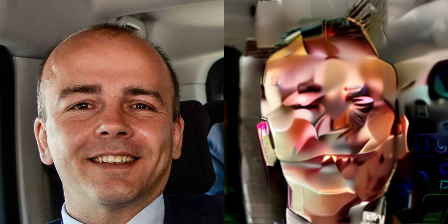

In [21]:
make_image_grid([image, gen_image], rows=1, cols=2)

In [27]:
from diffusers import DiffusionPipeline
pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True)
pipe.to("cuda")



100%|██████████| 50/50 [00:13<00:00,  3.76it/s]


In [99]:
import random

def build_prompt(has_mask=True):
    """
    Randomly builds a prompt describing a person wearing (or not wearing) a face mask
    with various attributes such as ethnicity, age, hair color, background, etc.

    Returns:
        A string (prompt).
    """

    # Define the possible choices for each attribute
    #8x3x6x7x5x6x3x5x6x3x6x4x4x2x3x4
    attributes = {
        "ethnicity": [
            "caucasian", "african", "asian", "hispanic", "middle eastern",
            "south asian", "native american", "<empty>"
        ],
        "gender": [
            "male", "female", "<empty>"
        ],
        "age": [
            "child", "teen", "young adult", "adult", "elderly", "<empty>"
        ],
        "hair_color": [
            "blond", "brown", "black", "red", "gray","ginger", "<empty>"
        ],
        "hair_structure": [
            "straight hair", "curly hair", "wavy hair","straight hair", "curly hair", "wavy hair","fine hair","slightly balding", "bald", "<empty>"
        ],
        "eye_color": [
            "blue eyes", "brown eyes", "green eyes", "hazel eyes", "gray eyes",
            "<empty>"
        ],
        "expression": [
            "neutral expression", "serious expression", "<empty>"
        ],
        "facemask_type": [
            "<face mask>", "ffp2 face mask", "surgical face mask",
            "cloth face mask","FFP-2 face mask","FFP-2 face mask","FFP-2 face mask"
        ],
        "face_mask_color": [
            "green mask", "blue mask", "white mask", "black mask", "red mask",
            "pink mask", "<empty>"
        ],
        "background_detail": [
            "blurred background", "detailed background", "<empty>"
        ],
        "background": [
            "outside", "living room", "office", "street", "nature",
            "studio backdrop", "<empty>"
        ],
        "position": [
            "front portrait", "profile","full-body profile","full-body frontal", "<empty>"
        ],
        "additional_angle": [
            "slightly above", "low angle","high angle", "<empty>"
        ],
        "additional_angle2": [
            "left", "right", "<empty>"
        ],
        "lighting": [
            "bright lighting", "dim lighting", "natural lighting", "<empty>"
        ],
        "clothing_style": [
            "casual clothing", "formal clothing", "sportswear", "<empty>"
        ],
        "resolution": [
            "high-res 8k", "low-res", "black and white","film-grain"
        ]
    }

    # Randomly choose one value for each attribute
    chosen = {}
    for attr_name, attr_values in attributes.items():
        chosen[attr_name] = random.choice(attr_values)

    # Build the prompt from the randomly chosen attributes
    # Skip adding the text if the choice is "<empty>"
    prompt_parts = []

    # Examples of how to add logic or formatting
    # (1) We skip face mask color if the mask type is "no face mask" or "<empty>".



    # Helper function to append attribute to prompt if not <empty>
    def add_to_prompt(value):
        if value != "<empty>":
            prompt_parts.append(value)
            
    add_to_prompt(chosen["ethnicity"])
    add_to_prompt(chosen["gender"])
    add_to_prompt(chosen["age"])
    add_to_prompt(chosen["hair_color"])
    add_to_prompt(chosen["hair_structure"])
    add_to_prompt(chosen["eye_color"])
    add_to_prompt(chosen["expression"])

    if has_mask:
        # Keep the chosen face mask color
        add_to_prompt(chosen["facemask_type"])
        facemask_color = chosen["face_mask_color"]
    else:
        # Force face mask color to <empty> if there's no face mask
        facemask_color = "<empty>"
    # Add each (in a meaningful order)

    
    add_to_prompt(facemask_color)
    add_to_prompt(chosen["background_detail"])
    add_to_prompt(chosen["background"])
    add_to_prompt(chosen["position"])
    add_to_prompt(chosen["additional_angle"])
    add_to_prompt(chosen["additional_angle2"])
    add_to_prompt(chosen["resolution"])
    # Combine all non-empty attributes into a single comma-separated string
    if has_mask:
        prompt = ", ".join(["a real person wearing a facemask: "]+prompt_parts)
    else:
        prompt = ", ".join(["a real photo of a real person: "]+prompt_parts) 
    return prompt





  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:13<00:00,  3.76it/s]


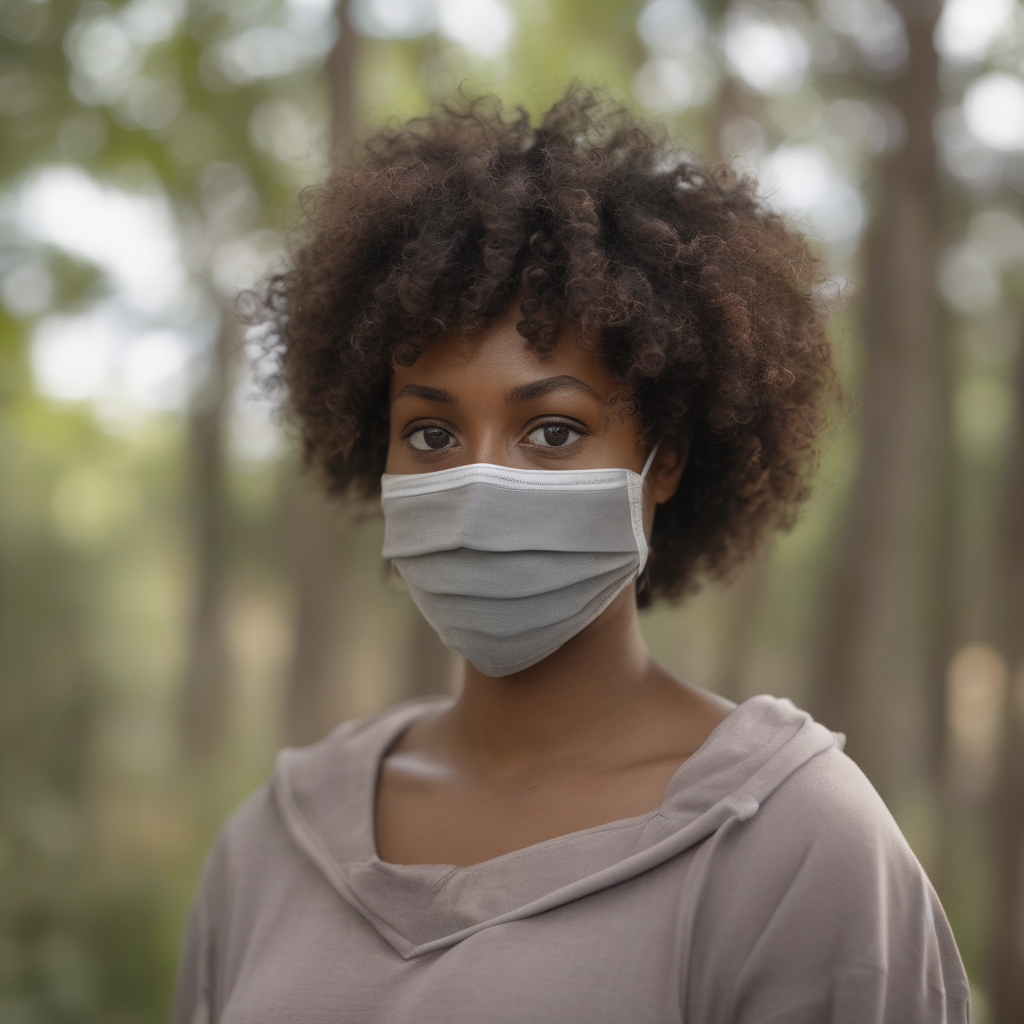

In [95]:
#prompt = "An african person wearing a green face mask outside"
prompt=build_prompt()
image = pipe(prompt=prompt).images[0]
image

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


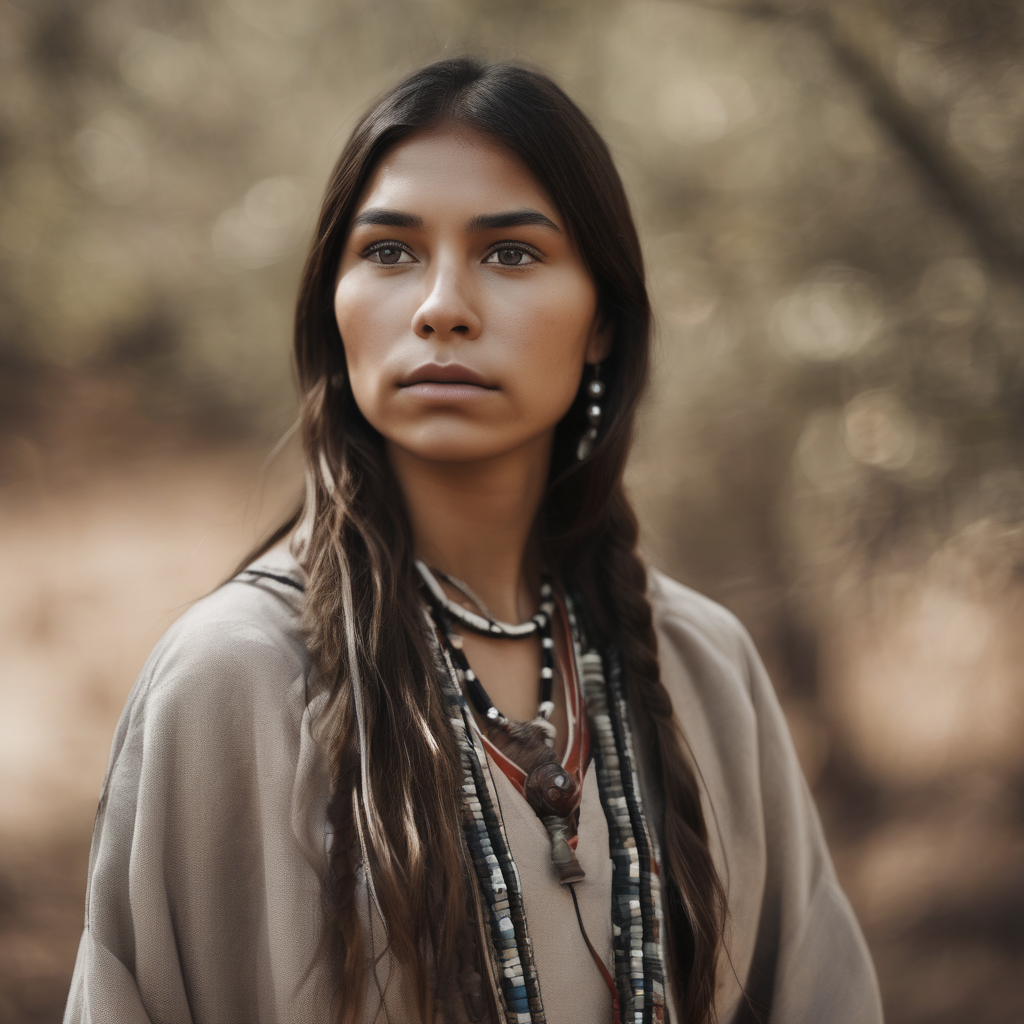

In [76]:
prompt=build_prompt(has_mask=False)
images = pipe(prompt=prompt).images[0]
images

In [89]:
import os
from PIL import Image

def generate_and_save_images(pipe, build_prompt, n, output_folder,mask=True):
    os.makedirs(output_folder, exist_ok=True)
    for i in range(n):
        prompt = build_prompt(has_mask=mask)
        print(prompt)
        result = pipe(prompt=prompt)
        image = result.images[0]
        image = image.resize((224, 224), Image.LANCZOS)
        image.save(os.path.join(output_folder, f"image_{random.randint(0,1000000)+i}.jpg"), format="JPEG", quality=85)



In [97]:
generate_and_save_images(pipe=pipe,build_prompt=build_prompt,n=1000,output_folder="synth_data/train/mask", )

a real person wearing a facemask: , middle eastern, male, child, blond, bald, gray eyes, neutral expression, cloth face mask, black mask, detailed background, nature, front portrait, right, high-res 8k


  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real person wearing a facemask: , hispanic, teen, red, wavy hair, gray eyes, serious expression, ffp2 face mask, red mask, living room, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real person wearing a facemask: , african, male, black, wavy hair, blue eyes, serious expression, ffp2 face mask, white mask, blurred background, nature, full-body frontal, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real person wearing a facemask: , middle eastern, female, gray, curly hair, serious expression, FFP-2 face mask, blue mask, detailed background, front portrait, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , asian, teen, brown, straight hair, gray eyes, neutral expression, FFP-2 face mask, green mask, detailed background, street, profile, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, elderly, black, curly hair, gray eyes, FFP-2 face mask, pink mask, blurred background, office, full-body frontal, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.83it/s]


a real person wearing a facemask: , south asian, male, child, ginger, curly hair, green eyes, neutral expression, ffp2 face mask, white mask, detailed background, full-body profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.75it/s]


a real person wearing a facemask: , caucasian, elderly, black, straight hair, neutral expression, FFP-2 face mask, green mask, studio backdrop, profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, female, adult, straight hair, blue eyes, cloth face mask, red mask, studio backdrop, profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.78it/s]


a real person wearing a facemask: , asian, female, young adult, ginger, curly hair, brown eyes, FFP-2 face mask, red mask, nature, profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


a real person wearing a facemask: , asian, adult, brown, wavy hair, brown eyes, neutral expression, surgical face mask, white mask, outside, full-body profile, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.82it/s]


a real person wearing a facemask: , middle eastern, female, child, black, bald, brown eyes, ffp2 face mask, white mask, street, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.76it/s]


a real person wearing a facemask: , asian, female, young adult, gray, slightly balding, hazel eyes, <face mask>, pink mask, blurred background, full-body frontal, film-grain


100%|██████████| 50/50 [00:12<00:00,  3.86it/s]


a real person wearing a facemask: , middle eastern, male, teen, wavy hair, gray eyes, neutral expression, surgical face mask, green mask, blurred background, outside, full-body profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.82it/s]


a real person wearing a facemask: , middle eastern, male, adult, gray, neutral expression, FFP-2 face mask, red mask, detailed background, office, full-body frontal, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, young adult, red, bald, blue eyes, FFP-2 face mask, white mask, blurred background, outside, front portrait, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , hispanic, female, child, brown, curly hair, blue eyes, serious expression, surgical face mask, white mask, detailed background, living room, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , native american, elderly, gray, curly hair, neutral expression, cloth face mask, red mask, blurred background, nature, front portrait, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.76it/s]


a real person wearing a facemask: , female, child, gray, wavy hair, hazel eyes, serious expression, <face mask>, detailed background, studio backdrop, profile, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.77it/s]


a real person wearing a facemask: , african, female, adult, gray, slightly balding, hazel eyes, serious expression, <face mask>, green mask, detailed background, living room, profile, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.78it/s]


a real person wearing a facemask: , caucasian, female, child, ginger, slightly balding, neutral expression, FFP-2 face mask, black mask, blurred background, office, full-body frontal, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.80it/s]


a real person wearing a facemask: , native american, female, red, bald, gray eyes, serious expression, FFP-2 face mask, green mask, blurred background, outside, profile, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


a real person wearing a facemask: , hispanic, male, elderly, ginger, straight hair, serious expression, FFP-2 face mask, red mask, profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.80it/s]


a real person wearing a facemask: , hispanic, male, young adult, black, curly hair, brown eyes, surgical face mask, blue mask, blurred background, front portrait, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.76it/s]


a real person wearing a facemask: , african, teen, straight hair, green eyes, neutral expression, FFP-2 face mask, white mask, detailed background, nature, profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , caucasian, adult, black, wavy hair, blue eyes, serious expression, <face mask>, pink mask, blurred background, living room, full-body frontal, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , south asian, elderly, ginger, straight hair, hazel eyes, serious expression, surgical face mask, green mask, office, full-body profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , middle eastern, male, adult, black, straight hair, gray eyes, neutral expression, FFP-2 face mask, black mask, detailed background, nature, full-body frontal, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , male, elderly, straight hair, serious expression, FFP-2 face mask, green mask, detailed background, outside, full-body frontal, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , hispanic, child, brown, fine hair, <face mask>, blue mask, detailed background, office, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, male, ginger, straight hair, serious expression, cloth face mask, black mask, blurred background, street, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, elderly, red, curly hair, gray eyes, neutral expression, FFP-2 face mask, black mask, street, full-body frontal, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, young adult, black, straight hair, gray eyes, serious expression, <face mask>, pink mask, nature, full-body profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, female, teen, gray, slightly balding, green eyes, FFP-2 face mask, green mask, detailed background, front portrait, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, adult, gray, straight hair, hazel eyes, neutral expression, FFP-2 face mask, black mask, blurred background, studio backdrop, front portrait, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, female, elderly, gray, straight hair, hazel eyes, serious expression, ffp2 face mask, black mask, detailed background, nature, profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, elderly, ginger, bald, green eyes, neutral expression, FFP-2 face mask, black mask, blurred background, studio backdrop, profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, male, elderly, brown, slightly balding, neutral expression, cloth face mask, red mask, blurred background, full-body frontal, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , middle eastern, female, red, curly hair, brown eyes, FFP-2 face mask, blue mask, detailed background, nature, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , asian, female, elderly, brown, straight hair, brown eyes, <face mask>, green mask, nature, profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, adult, red, slightly balding, brown eyes, FFP-2 face mask, green mask, blurred background, living room, full-body frontal, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , native american, female, elderly, black, slightly balding, hazel eyes, serious expression, ffp2 face mask, green mask, office, full-body frontal, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , caucasian, male, child, red, serious expression, cloth face mask, blurred background, street, full-body profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, elderly, gray, wavy hair, blue eyes, neutral expression, surgical face mask, green mask, blurred background, street, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , asian, female, adult, blond, wavy hair, green eyes, neutral expression, ffp2 face mask, white mask, blurred background, living room, profile, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, male, adult, gray, wavy hair, brown eyes, serious expression, FFP-2 face mask, black mask, full-body profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, elderly, ginger, curly hair, gray eyes, FFP-2 face mask, blue mask, office, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, elderly, gray, straight hair, brown eyes, serious expression, surgical face mask, green mask, detailed background, studio backdrop, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, young adult, blond, slightly balding, blue eyes, serious expression, FFP-2 face mask, red mask, detailed background, living room, full-body frontal, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , child, blond, wavy hair, gray eyes, serious expression, FFP-2 face mask, blue mask, detailed background, office, full-body profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, male, adult, ginger, curly hair, green eyes, FFP-2 face mask, green mask, detailed background, profile, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, elderly, black, straight hair, brown eyes, FFP-2 face mask, red mask, detailed background, living room, full-body frontal, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, teen, bald, blue eyes, neutral expression, surgical face mask, white mask, blurred background, studio backdrop, front portrait, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, child, black, straight hair, hazel eyes, serious expression, FFP-2 face mask, red mask, detailed background, street, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , male, teen, red, hazel eyes, cloth face mask, green mask, detailed background, studio backdrop, profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, male, adult, fine hair, green eyes, neutral expression, surgical face mask, red mask, detailed background, outside, full-body frontal, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, adult, brown, slightly balding, green eyes, FFP-2 face mask, detailed background, nature, full-body frontal, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, teen, bald, green eyes, neutral expression, ffp2 face mask, detailed background, living room, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , adult, straight hair, blue eyes, serious expression, FFP-2 face mask, blue mask, blurred background, studio backdrop, full-body profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, female, teen, blond, wavy hair, green eyes, cloth face mask, green mask, blurred background, nature, profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, elderly, black, fine hair, serious expression, ffp2 face mask, red mask, nature, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, young adult, ginger, brown eyes, neutral expression, cloth face mask, red mask, blurred background, street, full-body profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, male, elderly, gray, straight hair, neutral expression, FFP-2 face mask, blue mask, detailed background, living room, full-body frontal, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, blond, gray eyes, surgical face mask, black mask, office, full-body profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, elderly, gray, fine hair, blue eyes, neutral expression, surgical face mask, white mask, blurred background, outside, front portrait, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, brown, wavy hair, blue eyes, serious expression, FFP-2 face mask, black mask, detailed background, street, profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, teen, straight hair, FFP-2 face mask, blue mask, street, profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, young adult, ginger, curly hair, gray eyes, neutral expression, cloth face mask, white mask, blurred background, outside, profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, elderly, black, straight hair, hazel eyes, serious expression, <face mask>, pink mask, detailed background, nature, full-body profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, male, straight hair, FFP-2 face mask, detailed background, living room, profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, blond, slightly balding, blue eyes, FFP-2 face mask, outside, front portrait, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, male, adult, black, bald, <face mask>, white mask, blurred background, front portrait, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, female, elderly, red, green eyes, serious expression, ffp2 face mask, blue mask, blurred background, nature, full-body frontal, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, brown, straight hair, green eyes, neutral expression, FFP-2 face mask, red mask, outside, full-body profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, young adult, red, straight hair, serious expression, <face mask>, pink mask, detailed background, outside, full-body frontal, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, female, child, blond, fine hair, blue eyes, neutral expression, surgical face mask, blue mask, detailed background, studio backdrop, front portrait, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, adult, red, curly hair, green eyes, neutral expression, FFP-2 face mask, red mask, detailed background, outside, full-body frontal, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, adult, straight hair, hazel eyes, serious expression, <face mask>, detailed background, living room, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, teen, blond, straight hair, brown eyes, FFP-2 face mask, green mask, detailed background, outside, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , young adult, blond, straight hair, blue eyes, neutral expression, FFP-2 face mask, blue mask, detailed background, living room, full-body frontal, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, adult, wavy hair, cloth face mask, blue mask, detailed background, nature, front portrait, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , elderly, ginger, fine hair, brown eyes, FFP-2 face mask, green mask, nature, profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, female, elderly, red, fine hair, blue eyes, neutral expression, FFP-2 face mask, blue mask, detailed background, living room, front portrait, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , child, gray, curly hair, hazel eyes, cloth face mask, pink mask, office, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, young adult, brown, straight hair, blue eyes, neutral expression, <face mask>, black mask, blurred background, living room, full-body frontal, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, child, ginger, fine hair, serious expression, FFP-2 face mask, blurred background, street, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, male, elderly, black, straight hair, brown eyes, FFP-2 face mask, black mask, front portrait, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, young adult, black, fine hair, green eyes, neutral expression, FFP-2 face mask, blurred background, nature, front portrait, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, straight hair, hazel eyes, serious expression, ffp2 face mask, red mask, detailed background, outside, profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, female, child, ginger, wavy hair, blue eyes, ffp2 face mask, red mask, blurred background, office, front portrait, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, female, young adult, black, curly hair, gray eyes, FFP-2 face mask, green mask, living room, profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, child, ginger, wavy hair, green eyes, serious expression, FFP-2 face mask, living room, profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, young adult, ginger, slightly balding, green eyes, serious expression, cloth face mask, green mask, detailed background, office, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, male, young adult, gray, slightly balding, gray eyes, neutral expression, FFP-2 face mask, blurred background, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, teen, ginger, wavy hair, blue eyes, neutral expression, ffp2 face mask, detailed background, living room, front portrait, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, elderly, curly hair, green eyes, serious expression, cloth face mask, black mask, blurred background, outside, front portrait, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, adult, bald, hazel eyes, serious expression, cloth face mask, living room, front portrait, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , middle eastern, male, adult, brown, curly hair, brown eyes, cloth face mask, green mask, blurred background, street, front portrait, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, female, child, red, wavy hair, FFP-2 face mask, blurred background, full-body profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, female, elderly, fine hair, gray eyes, surgical face mask, front portrait, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, elderly, gray, slightly balding, hazel eyes, neutral expression, FFP-2 face mask, white mask, detailed background, profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , teen, gray, bald, cloth face mask, green mask, living room, front portrait, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, wavy hair, blue eyes, FFP-2 face mask, white mask, office, profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, female, child, blue eyes, cloth face mask, detailed background, street, front portrait, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , male, elderly, ginger, slightly balding, hazel eyes, neutral expression, ffp2 face mask, green mask, outside, full-body frontal, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, elderly, bald, serious expression, surgical face mask, black mask, studio backdrop, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, male, child, gray, curly hair, neutral expression, <face mask>, blue mask, detailed background, street, profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, adult, brown, bald, green eyes, FFP-2 face mask, blue mask, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, male, teen, slightly balding, green eyes, <face mask>, red mask, blurred background, nature, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , male, slightly balding, FFP-2 face mask, red mask, full-body profile, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, young adult, straight hair, brown eyes, cloth face mask, green mask, detailed background, front portrait, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, teen, black, curly hair, green eyes, neutral expression, FFP-2 face mask, red mask, office, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, male, adult, gray, straight hair, hazel eyes, surgical face mask, blue mask, blurred background, nature, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, young adult, brown, bald, blue eyes, neutral expression, FFP-2 face mask, pink mask, blurred background, nature, full-body frontal, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, female, teen, brown, curly hair, green eyes, serious expression, <face mask>, black mask, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, young adult, black, fine hair, serious expression, cloth face mask, red mask, detailed background, office, full-body profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, female, adult, brown, straight hair, hazel eyes, serious expression, cloth face mask, red mask, blurred background, nature, profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, female, adult, gray, straight hair, green eyes, FFP-2 face mask, office, front portrait, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, adult, blond, straight hair, green eyes, ffp2 face mask, pink mask, full-body profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, male, young adult, brown, straight hair, gray eyes, <face mask>, white mask, living room, front portrait, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, young adult, gray, straight hair, green eyes, neutral expression, surgical face mask, pink mask, full-body profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, male, adult, blond, straight hair, blue eyes, ffp2 face mask, pink mask, blurred background, studio backdrop, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, female, elderly, gray, slightly balding, brown eyes, neutral expression, cloth face mask, black mask, studio backdrop, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, female, blond, curly hair, blue eyes, serious expression, surgical face mask, green mask, blurred background, nature, full-body frontal, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, adult, brown, straight hair, green eyes, serious expression, surgical face mask, blurred background, outside, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, female, adult, brown, wavy hair, neutral expression, ffp2 face mask, pink mask, blurred background, studio backdrop, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, straight hair, gray eyes, surgical face mask, black mask, blurred background, living room, full-body frontal, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, curly hair, hazel eyes, serious expression, FFP-2 face mask, blue mask, detailed background, living room, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, female, adult, red, straight hair, hazel eyes, neutral expression, <face mask>, blurred background, nature, profile, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, elderly, black, curly hair, hazel eyes, serious expression, <face mask>, white mask, detailed background, office, profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, bald, blue eyes, cloth face mask, white mask, blurred background, studio backdrop, full-body profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, child, blond, straight hair, brown eyes, neutral expression, FFP-2 face mask, red mask, blurred background, street, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, gray, curly hair, neutral expression, FFP-2 face mask, black mask, detailed background, full-body frontal, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, young adult, red, straight hair, serious expression, surgical face mask, pink mask, office, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, child, black, fine hair, green eyes, serious expression, FFP-2 face mask, white mask, blurred background, nature, front portrait, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, child, gray, fine hair, gray eyes, serious expression, surgical face mask, pink mask, blurred background, street, profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, child, blond, wavy hair, gray eyes, neutral expression, FFP-2 face mask, pink mask, blurred background, nature, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, young adult, brown, fine hair, gray eyes, FFP-2 face mask, red mask, blurred background, street, profile, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, elderly, ginger, straight hair, gray eyes, serious expression, cloth face mask, blue mask, detailed background, full-body profile, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, elderly, brown, straight hair, hazel eyes, surgical face mask, white mask, blurred background, nature, front portrait, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, male, child, ginger, fine hair, blue eyes, neutral expression, <face mask>, detailed background, outside, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, ginger, curly hair, gray eyes, cloth face mask, black mask, front portrait, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, child, red, green eyes, surgical face mask, pink mask, blurred background, street, full-body profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, child, ginger, straight hair, blue eyes, FFP-2 face mask, red mask, blurred background, outside, full-body frontal, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, adult, ginger, curly hair, green eyes, neutral expression, <face mask>, detailed background, outside, full-body frontal, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, male, teen, ginger, wavy hair, green eyes, cloth face mask, white mask, blurred background, front portrait, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, young adult, ginger, wavy hair, serious expression, surgical face mask, pink mask, outside, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, adult, black, curly hair, brown eyes, serious expression, <face mask>, office, profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, child, brown, wavy hair, green eyes, neutral expression, cloth face mask, red mask, detailed background, office, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, blond, wavy hair, hazel eyes, neutral expression, ffp2 face mask, green mask, blurred background, outside, front portrait, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, elderly, blond, wavy hair, blue eyes, ffp2 face mask, pink mask, studio backdrop, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , young adult, gray, curly hair, blue eyes, ffp2 face mask, green mask, blurred background, studio backdrop, front portrait, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, male, young adult, black, fine hair, brown eyes, <face mask>, detailed background, street, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, ginger, wavy hair, cloth face mask, red mask, blurred background, nature, full-body profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, adult, red, straight hair, gray eyes, neutral expression, surgical face mask, green mask, detailed background, nature, profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, male, adult, black, bald, FFP-2 face mask, red mask, detailed background, office, full-body frontal, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, male, child, brown, wavy hair, blue eyes, serious expression, FFP-2 face mask, red mask, outside, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , curly hair, serious expression, FFP-2 face mask, blue mask, blurred background, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , male, elderly, brown, straight hair, brown eyes, neutral expression, ffp2 face mask, detailed background, studio backdrop, profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, child, brown, curly hair, gray eyes, neutral expression, FFP-2 face mask, green mask, blurred background, office, full-body profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , male, child, black, blue eyes, ffp2 face mask, black mask, detailed background, office, full-body frontal, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , male, elderly, ginger, wavy hair, blue eyes, neutral expression, FFP-2 face mask, green mask, detailed background, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, male, elderly, ginger, slightly balding, gray eyes, FFP-2 face mask, green mask, detailed background, outside, full-body profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, male, teen, slightly balding, hazel eyes, ffp2 face mask, white mask, detailed background, studio backdrop, profile, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, elderly, blond, curly hair, brown eyes, FFP-2 face mask, black mask, detailed background, outside, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, male, young adult, curly hair, brown eyes, <face mask>, detailed background, living room, profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, elderly, red, straight hair, green eyes, neutral expression, FFP-2 face mask, red mask, detailed background, street, full-body frontal, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, female, teen, curly hair, gray eyes, <face mask>, white mask, outside, full-body profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, female, adult, brown, curly hair, blue eyes, cloth face mask, pink mask, studio backdrop, profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, child, red, wavy hair, brown eyes, serious expression, surgical face mask, green mask, street, front portrait, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, gray, green eyes, neutral expression, surgical face mask, pink mask, detailed background, full-body frontal, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, child, straight hair, gray eyes, <face mask>, black mask, detailed background, living room, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, young adult, fine hair, green eyes, serious expression, FFP-2 face mask, blue mask, blurred background, studio backdrop, full-body profile, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, adult, green eyes, FFP-2 face mask, blue mask, blurred background, studio backdrop, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, blond, straight hair, hazel eyes, neutral expression, FFP-2 face mask, outside, profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, adult, brown, slightly balding, brown eyes, FFP-2 face mask, pink mask, nature, full-body profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, elderly, blue eyes, serious expression, ffp2 face mask, black mask, blurred background, nature, front portrait, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, teen, brown, fine hair, neutral expression, surgical face mask, red mask, nature, full-body frontal, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , male, young adult, black, bald, gray eyes, serious expression, cloth face mask, black mask, blurred background, front portrait, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, elderly, black, fine hair, green eyes, ffp2 face mask, blue mask, blurred background, street, full-body frontal, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, child, blond, curly hair, brown eyes, surgical face mask, black mask, detailed background, outside, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, adult, ginger, wavy hair, surgical face mask, blurred background, living room, profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, elderly, black, fine hair, gray eyes, neutral expression, FFP-2 face mask, green mask, detailed background, street, full-body profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, adult, brown, straight hair, gray eyes, surgical face mask, pink mask, outside, full-body frontal, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , teen, ginger, straight hair, hazel eyes, serious expression, surgical face mask, pink mask, blurred background, street, full-body frontal, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, teen, gray, curly hair, serious expression, cloth face mask, blue mask, detailed background, street, profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, male, young adult, black, slightly balding, hazel eyes, serious expression, cloth face mask, blue mask, blurred background, nature, full-body frontal, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, teen, black, straight hair, green eyes, serious expression, FFP-2 face mask, white mask, detailed background, office, full-body profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, teen, FFP-2 face mask, green mask, detailed background, nature, full-body profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, adult, blond, wavy hair, gray eyes, neutral expression, FFP-2 face mask, red mask, detailed background, nature, full-body profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, female, red, curly hair, brown eyes, serious expression, FFP-2 face mask, green mask, detailed background, outside, full-body profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, elderly, slightly balding, gray eyes, FFP-2 face mask, blue mask, blurred background, living room, front portrait, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, young adult, black, gray eyes, neutral expression, surgical face mask, white mask, blurred background, street, full-body frontal, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, adult, blond, straight hair, gray eyes, serious expression, surgical face mask, black mask, blurred background, living room, profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, teen, ginger, fine hair, hazel eyes, neutral expression, surgical face mask, blue mask, office, profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, male, adult, blond, wavy hair, hazel eyes, serious expression, surgical face mask, white mask, blurred background, nature, full-body frontal, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, adult, black, curly hair, brown eyes, neutral expression, cloth face mask, white mask, detailed background, living room, full-body frontal, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, elderly, blond, fine hair, hazel eyes, serious expression, FFP-2 face mask, red mask, outside, full-body profile, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, elderly, blond, curly hair, hazel eyes, serious expression, FFP-2 face mask, pink mask, detailed background, nature, full-body frontal, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, young adult, gray, slightly balding, green eyes, serious expression, cloth face mask, pink mask, blurred background, nature, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, adult, ginger, straight hair, brown eyes, neutral expression, surgical face mask, blurred background, studio backdrop, full-body frontal, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, teen, red, fine hair, brown eyes, cloth face mask, pink mask, full-body profile, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, child, black, slightly balding, green eyes, neutral expression, <face mask>, blue mask, detailed background, street, front portrait, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, female, curly hair, green eyes, serious expression, surgical face mask, pink mask, living room, profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, teen, ginger, wavy hair, green eyes, neutral expression, ffp2 face mask, white mask, detailed background, office, profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, adult, black, wavy hair, blue eyes, surgical face mask, black mask, outside, full-body profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, adult, red, curly hair, brown eyes, <face mask>, white mask, detailed background, street, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, gray, bald, gray eyes, FFP-2 face mask, green mask, street, full-body frontal, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, child, blond, curly hair, neutral expression, FFP-2 face mask, red mask, detailed background, living room, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, ginger, straight hair, blue eyes, ffp2 face mask, blurred background, street, profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, young adult, blond, wavy hair, green eyes, FFP-2 face mask, green mask, outside, profile, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, teen, blond, slightly balding, hazel eyes, serious expression, FFP-2 face mask, white mask, blurred background, street, full-body profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, teen, wavy hair, gray eyes, neutral expression, <face mask>, green mask, blurred background, full-body frontal, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, female, gray, bald, green eyes, FFP-2 face mask, pink mask, nature, full-body frontal, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, black, wavy hair, gray eyes, neutral expression, ffp2 face mask, black mask, living room, profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, teen, curly hair, green eyes, ffp2 face mask, white mask, outside, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , male, adult, bald, blue eyes, serious expression, FFP-2 face mask, white mask, detailed background, living room, full-body profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, adult, black, straight hair, blue eyes, neutral expression, <face mask>, black mask, blurred background, street, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, teen, red, blue eyes, neutral expression, FFP-2 face mask, blue mask, profile, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , young adult, black, wavy hair, FFP-2 face mask, white mask, detailed background, profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, adult, neutral expression, FFP-2 face mask, pink mask, nature, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, teen, red, slightly balding, hazel eyes, serious expression, FFP-2 face mask, pink mask, outside, front portrait, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, male, teen, brown, curly hair, FFP-2 face mask, pink mask, detailed background, street, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, ginger, curly hair, gray eyes, neutral expression, cloth face mask, white mask, full-body frontal, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, red, wavy hair, FFP-2 face mask, green mask, detailed background, studio backdrop, front portrait, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, female, young adult, blond, slightly balding, brown eyes, neutral expression, FFP-2 face mask, green mask, blurred background, outside, profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, teen, red, neutral expression, surgical face mask, pink mask, street, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, young adult, red, curly hair, blue eyes, serious expression, FFP-2 face mask, red mask, detailed background, full-body profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, teen, fine hair, blue eyes, serious expression, ffp2 face mask, red mask, blurred background, front portrait, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, adult, black, wavy hair, hazel eyes, FFP-2 face mask, black mask, detailed background, studio backdrop, full-body frontal, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, female, adult, red, straight hair, gray eyes, ffp2 face mask, white mask, blurred background, office, full-body frontal, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , asian, female, young adult, brown, hazel eyes, FFP-2 face mask, white mask, outside, front portrait, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, female, young adult, red, gray eyes, serious expression, ffp2 face mask, blue mask, living room, front portrait, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, female, adult, red, fine hair, hazel eyes, serious expression, cloth face mask, black mask, full-body frontal, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, young adult, wavy hair, blue eyes, serious expression, FFP-2 face mask, white mask, blurred background, studio backdrop, full-body frontal, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, ginger, blue eyes, serious expression, FFP-2 face mask, white mask, detailed background, studio backdrop, full-body frontal, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, young adult, brown, curly hair, gray eyes, FFP-2 face mask, green mask, detailed background, street, full-body profile, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, teen, gray, curly hair, gray eyes, serious expression, <face mask>, black mask, blurred background, street, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, teen, bald, brown eyes, FFP-2 face mask, red mask, detailed background, living room, profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, male, young adult, ginger, straight hair, green eyes, FFP-2 face mask, blurred background, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, elderly, brown, curly hair, <face mask>, red mask, office, profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, teen, gray, wavy hair, hazel eyes, serious expression, surgical face mask, black mask, blurred background, nature, full-body profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, child, slightly balding, green eyes, <face mask>, profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, adult, ginger, curly hair, green eyes, serious expression, cloth face mask, blue mask, blurred background, nature, full-body frontal, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, teen, gray, straight hair, gray eyes, serious expression, cloth face mask, black mask, studio backdrop, full-body frontal, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, child, blond, bald, gray eyes, FFP-2 face mask, pink mask, blurred background, nature, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, young adult, ginger, curly hair, brown eyes, neutral expression, FFP-2 face mask, pink mask, studio backdrop, front portrait, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, child, gray, straight hair, gray eyes, neutral expression, FFP-2 face mask, pink mask, blurred background, nature, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, female, elderly, gray, slightly balding, hazel eyes, FFP-2 face mask, red mask, detailed background, profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, young adult, blond, curly hair, hazel eyes, ffp2 face mask, pink mask, living room, profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , young adult, gray, curly hair, green eyes, serious expression, FFP-2 face mask, red mask, studio backdrop, front portrait, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, teen, curly hair, gray eyes, serious expression, cloth face mask, blurred background, studio backdrop, full-body profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, child, ginger, wavy hair, hazel eyes, surgical face mask, white mask, blurred background, nature, full-body frontal, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, female, adult, ginger, straight hair, blue eyes, serious expression, FFP-2 face mask, red mask, blurred background, outside, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, female, ginger, straight hair, hazel eyes, serious expression, FFP-2 face mask, green mask, blurred background, office, full-body profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , native american, female, young adult, ginger, straight hair, brown eyes, neutral expression, FFP-2 face mask, white mask, blurred background, street, profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, female, young adult, ginger, bald, green eyes, serious expression, surgical face mask, pink mask, detailed background, living room, front portrait, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, young adult, ginger, bald, green eyes, serious expression, surgical face mask, blurred background, studio backdrop, front portrait, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, teen, black, gray eyes, neutral expression, FFP-2 face mask, red mask, detailed background, street, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, young adult, red, straight hair, hazel eyes, surgical face mask, green mask, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, elderly, ginger, wavy hair, green eyes, neutral expression, ffp2 face mask, pink mask, detailed background, nature, front portrait, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, teen, brown, wavy hair, hazel eyes, neutral expression, FFP-2 face mask, pink mask, detailed background, street, full-body profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, child, black, curly hair, green eyes, FFP-2 face mask, white mask, blurred background, office, full-body profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, teen, green eyes, serious expression, FFP-2 face mask, office, profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, female, brown, slightly balding, hazel eyes, cloth face mask, red mask, detailed background, studio backdrop, front portrait, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, child, gray, slightly balding, hazel eyes, <face mask>, pink mask, profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, young adult, brown, fine hair, gray eyes, ffp2 face mask, black mask, detailed background, front portrait, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, child, gray, curly hair, neutral expression, FFP-2 face mask, black mask, office, front portrait, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, teen, gray, straight hair, neutral expression, <face mask>, white mask, living room, full-body profile, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, male, teen, red, fine hair, green eyes, FFP-2 face mask, blurred background, nature, front portrait, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, adult, straight hair, gray eyes, neutral expression, surgical face mask, blue mask, blurred background, nature, front portrait, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , ginger, bald, brown eyes, neutral expression, <face mask>, red mask, blurred background, office, full-body profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, young adult, straight hair, green eyes, <face mask>, detailed background, outside, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, male, child, gray, bald, brown eyes, serious expression, <face mask>, black mask, blurred background, studio backdrop, full-body profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, female, child, black, straight hair, gray eyes, surgical face mask, pink mask, detailed background, street, full-body profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, female, elderly, blond, slightly balding, brown eyes, serious expression, <face mask>, living room, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, young adult, black, fine hair, green eyes, neutral expression, FFP-2 face mask, green mask, blurred background, outside, full-body frontal, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , teen, gray, blue eyes, ffp2 face mask, blue mask, blurred background, outside, front portrait, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, female, elderly, red, wavy hair, blue eyes, neutral expression, FFP-2 face mask, profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, teen, ginger, curly hair, hazel eyes, neutral expression, cloth face mask, red mask, detailed background, outside, front portrait, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, child, brown, slightly balding, green eyes, serious expression, FFP-2 face mask, pink mask, nature, full-body profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, male, elderly, ginger, wavy hair, blue eyes, neutral expression, <face mask>, pink mask, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, child, black, bald, gray eyes, neutral expression, FFP-2 face mask, black mask, detailed background, living room, full-body frontal, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, child, ginger, fine hair, blue eyes, cloth face mask, green mask, detailed background, outside, full-body frontal, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , male, elderly, gray, bald, brown eyes, serious expression, FFP-2 face mask, white mask, detailed background, nature, full-body frontal, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, male, adult, ginger, curly hair, gray eyes, serious expression, FFP-2 face mask, white mask, blurred background, full-body profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, adult, black, wavy hair, ffp2 face mask, pink mask, blurred background, outside, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, female, young adult, gray, wavy hair, green eyes, neutral expression, <face mask>, blue mask, nature, profile, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, adult, gray, fine hair, green eyes, FFP-2 face mask, green mask, living room, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, ginger, fine hair, <face mask>, blue mask, blurred background, studio backdrop, profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, elderly, straight hair, green eyes, cloth face mask, red mask, street, full-body profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, female, teen, gray, serious expression, FFP-2 face mask, red mask, office, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, male, teen, gray, straight hair, brown eyes, neutral expression, cloth face mask, blurred background, office, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, child, blond, bald, green eyes, neutral expression, ffp2 face mask, pink mask, studio backdrop, front portrait, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, male, teen, brown, bald, blue eyes, serious expression, cloth face mask, green mask, detailed background, outside, front portrait, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, male, elderly, red, slightly balding, FFP-2 face mask, red mask, detailed background, outside, full-body frontal, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, female, child, brown, slightly balding, neutral expression, <face mask>, red mask, outside, full-body frontal, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, child, brown, wavy hair, brown eyes, cloth face mask, red mask, blurred background, office, full-body frontal, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, young adult, red, wavy hair, hazel eyes, neutral expression, ffp2 face mask, red mask, detailed background, outside, full-body frontal, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, female, elderly, brown, wavy hair, hazel eyes, serious expression, <face mask>, detailed background, street, profile, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, female, elderly, slightly balding, green eyes, neutral expression, surgical face mask, blue mask, detailed background, studio backdrop, full-body profile, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , caucasian, male, child, ginger, wavy hair, green eyes, neutral expression, FFP-2 face mask, pink mask, blurred background, full-body frontal, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, elderly, black, green eyes, neutral expression, FFP-2 face mask, green mask, detailed background, nature, front portrait, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , young adult, fine hair, green eyes, FFP-2 face mask, green mask, detailed background, nature, full-body frontal, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, adult, ginger, green eyes, ffp2 face mask, white mask, street, full-body profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, child, black, straight hair, hazel eyes, neutral expression, surgical face mask, white mask, outside, profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, child, wavy hair, brown eyes, serious expression, FFP-2 face mask, pink mask, blurred background, outside, full-body profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, red, curly hair, gray eyes, serious expression, FFP-2 face mask, red mask, detailed background, front portrait, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, female, teen, black, slightly balding, cloth face mask, red mask, blurred background, outside, full-body profile, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, young adult, curly hair, neutral expression, FFP-2 face mask, black mask, nature, profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, teen, ginger, straight hair, gray eyes, FFP-2 face mask, red mask, blurred background, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, child, black, curly hair, neutral expression, surgical face mask, black mask, blurred background, street, full-body frontal, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, young adult, gray, fine hair, brown eyes, FFP-2 face mask, blurred background, profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, young adult, blond, curly hair, blue eyes, FFP-2 face mask, detailed background, studio backdrop, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, female, teen, fine hair, green eyes, neutral expression, FFP-2 face mask, green mask, blurred background, studio backdrop, profile, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, female, teen, brown, fine hair, brown eyes, serious expression, ffp2 face mask, pink mask, nature, full-body frontal, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, child, gray, curly hair, green eyes, neutral expression, FFP-2 face mask, detailed background, street, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, female, elderly, ginger, fine hair, green eyes, surgical face mask, pink mask, detailed background, studio backdrop, front portrait, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, child, gray, bald, FFP-2 face mask, black mask, front portrait, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, brown, wavy hair, blue eyes, FFP-2 face mask, red mask, full-body frontal, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, male, adult, blond, wavy hair, hazel eyes, neutral expression, surgical face mask, blue mask, detailed background, nature, full-body profile, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, male, young adult, gray, bald, gray eyes, neutral expression, <face mask>, red mask, blurred background, street, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , adult, brown, fine hair, FFP-2 face mask, studio backdrop, full-body frontal, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, elderly, curly hair, green eyes, FFP-2 face mask, black mask, detailed background, nature, full-body frontal, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, elderly, brown, fine hair, neutral expression, <face mask>, white mask, nature, full-body profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, teen, black, straight hair, gray eyes, serious expression, <face mask>, red mask, blurred background, living room, full-body profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, teen, black, wavy hair, brown eyes, neutral expression, FFP-2 face mask, blue mask, blurred background, full-body frontal, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, adult, ginger, blue eyes, surgical face mask, blue mask, blurred background, street, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, child, brown, fine hair, neutral expression, FFP-2 face mask, red mask, living room, front portrait, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, young adult, black, curly hair, brown eyes, neutral expression, FFP-2 face mask, blurred background, studio backdrop, profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, teen, red, green eyes, neutral expression, FFP-2 face mask, white mask, full-body frontal, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, teen, brown, curly hair, green eyes, neutral expression, FFP-2 face mask, detailed background, nature, profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, female, teen, blond, bald, brown eyes, neutral expression, FFP-2 face mask, blurred background, office, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, blond, curly hair, hazel eyes, serious expression, <face mask>, blurred background, outside, profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, wavy hair, <face mask>, green mask, blurred background, studio backdrop, full-body profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, adult, gray, curly hair, brown eyes, ffp2 face mask, blue mask, blurred background, living room, full-body frontal, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, elderly, red, curly hair, FFP-2 face mask, white mask, detailed background, office, full-body frontal, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , teen, blond, blue eyes, serious expression, FFP-2 face mask, green mask, street, full-body profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, teen, gray, curly hair, blue eyes, serious expression, FFP-2 face mask, red mask, blurred background, studio backdrop, full-body profile, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, brown, straight hair, green eyes, serious expression, ffp2 face mask, black mask, blurred background, outside, front portrait, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, male, elderly, red, straight hair, serious expression, surgical face mask, black mask, detailed background, studio backdrop, full-body profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, female, young adult, brown, curly hair, green eyes, neutral expression, <face mask>, black mask, blurred background, living room, full-body profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , middle eastern, female, young adult, gray, fine hair, surgical face mask, black mask, detailed background, office, front portrait, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, adult, blond, straight hair, green eyes, neutral expression, FFP-2 face mask, white mask, detailed background, living room, front portrait, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, teen, black, straight hair, green eyes, FFP-2 face mask, black mask, studio backdrop, front portrait, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, adult, blond, bald, blue eyes, serious expression, FFP-2 face mask, blue mask, detailed background, front portrait, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, male, child, ginger, straight hair, gray eyes, cloth face mask, outside, full-body frontal, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, adult, gray, fine hair, brown eyes, neutral expression, ffp2 face mask, white mask, blurred background, outside, profile, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, teen, black, straight hair, hazel eyes, serious expression, <face mask>, blurred background, office, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, young adult, blond, straight hair, gray eyes, neutral expression, FFP-2 face mask, blue mask, detailed background, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, young adult, curly hair, brown eyes, serious expression, FFP-2 face mask, black mask, detailed background, living room, full-body frontal, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, young adult, black, straight hair, brown eyes, neutral expression, FFP-2 face mask, green mask, blurred background, studio backdrop, profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, child, black, bald, green eyes, neutral expression, cloth face mask, black mask, blurred background, studio backdrop, full-body frontal, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, child, wavy hair, gray eyes, neutral expression, cloth face mask, red mask, blurred background, living room, full-body profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, female, black, straight hair, <face mask>, pink mask, detailed background, street, full-body profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, female, young adult, blond, curly hair, FFP-2 face mask, white mask, detailed background, outside, full-body profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, male, elderly, ginger, wavy hair, blue eyes, <face mask>, blue mask, detailed background, street, full-body profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, brown, hazel eyes, serious expression, surgical face mask, detailed background, office, full-body frontal, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, male, teen, fine hair, blue eyes, FFP-2 face mask, black mask, street, full-body profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, adult, brown, hazel eyes, serious expression, FFP-2 face mask, red mask, office, profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, young adult, straight hair, hazel eyes, serious expression, <face mask>, white mask, detailed background, street, full-body frontal, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, red, blue eyes, neutral expression, ffp2 face mask, pink mask, blurred background, street, front portrait, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, teen, black, wavy hair, brown eyes, neutral expression, FFP-2 face mask, black mask, blurred background, office, profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, adult, red, straight hair, serious expression, <face mask>, blue mask, blurred background, studio backdrop, profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, blond, curly hair, brown eyes, serious expression, FFP-2 face mask, green mask, detailed background, living room, full-body profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, adult, black, slightly balding, hazel eyes, cloth face mask, white mask, living room, full-body frontal, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, teen, gray, curly hair, green eyes, neutral expression, surgical face mask, black mask, blurred background, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, male, adult, wavy hair, blue eyes, serious expression, ffp2 face mask, black mask, living room, profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, male, adult, ginger, fine hair, hazel eyes, serious expression, FFP-2 face mask, outside, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, teen, curly hair, neutral expression, cloth face mask, red mask, blurred background, studio backdrop, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, male, young adult, red, wavy hair, surgical face mask, blue mask, living room, profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, elderly, gray, straight hair, hazel eyes, serious expression, cloth face mask, red mask, blurred background, office, full-body profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, teen, black, wavy hair, brown eyes, FFP-2 face mask, detailed background, nature, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, female, elderly, brown, wavy hair, hazel eyes, FFP-2 face mask, red mask, blurred background, street, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, female, elderly, gray, curly hair, blue eyes, serious expression, FFP-2 face mask, blurred background, office, profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, male, adult, blond, FFP-2 face mask, black mask, detailed background, office, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, young adult, blond, wavy hair, brown eyes, surgical face mask, pink mask, detailed background, office, full-body profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, male, teen, wavy hair, neutral expression, FFP-2 face mask, blue mask, detailed background, nature, front portrait, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, young adult, ginger, curly hair, brown eyes, serious expression, FFP-2 face mask, green mask, office, full-body frontal, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, adult, fine hair, blue eyes, serious expression, ffp2 face mask, pink mask, outside, full-body frontal, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, ginger, curly hair, hazel eyes, serious expression, FFP-2 face mask, red mask, studio backdrop, profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, male, elderly, slightly balding, brown eyes, neutral expression, FFP-2 face mask, blurred background, outside, front portrait, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, elderly, gray, curly hair, hazel eyes, surgical face mask, black mask, detailed background, street, full-body frontal, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, female, child, gray, wavy hair, brown eyes, neutral expression, <face mask>, white mask, living room, full-body profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, female, adult, gray, fine hair, brown eyes, FFP-2 face mask, full-body frontal, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, elderly, black, straight hair, brown eyes, serious expression, FFP-2 face mask, black mask, blurred background, street, profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, child, brown, curly hair, serious expression, FFP-2 face mask, blue mask, blurred background, street, front portrait, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, male, ginger, straight hair, green eyes, surgical face mask, red mask, blurred background, front portrait, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, black, slightly balding, blue eyes, FFP-2 face mask, street, full-body frontal, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, adult, blond, fine hair, green eyes, neutral expression, FFP-2 face mask, red mask, blurred background, outside, profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, teen, brown, straight hair, neutral expression, <face mask>, black mask, blurred background, outside, profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, elderly, brown, blue eyes, serious expression, cloth face mask, blue mask, blurred background, nature, front portrait, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, male, child, red, curly hair, blue eyes, serious expression, surgical face mask, pink mask, studio backdrop, full-body frontal, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, young adult, ginger, slightly balding, hazel eyes, neutral expression, FFP-2 face mask, green mask, blurred background, living room, profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, female, young adult, black, slightly balding, hazel eyes, serious expression, FFP-2 face mask, pink mask, blurred background, studio backdrop, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, elderly, gray, bald, neutral expression, cloth face mask, blue mask, blurred background, office, full-body frontal, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, elderly, black, slightly balding, green eyes, FFP-2 face mask, blue mask, nature, full-body frontal, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , elderly, ginger, curly hair, brown eyes, neutral expression, FFP-2 face mask, red mask, blurred background, outside, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, elderly, blond, curly hair, hazel eyes, FFP-2 face mask, red mask, studio backdrop, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, female, elderly, blond, slightly balding, hazel eyes, neutral expression, ffp2 face mask, blue mask, nature, profile, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, male, young adult, blond, wavy hair, brown eyes, FFP-2 face mask, green mask, full-body frontal, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, male, elderly, blond, fine hair, hazel eyes, surgical face mask, pink mask, blurred background, nature, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, young adult, blond, curly hair, blue eyes, neutral expression, <face mask>, green mask, detailed background, office, profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, fine hair, gray eyes, <face mask>, blue mask, office, full-body profile, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, elderly, ginger, blue eyes, cloth face mask, pink mask, detailed background, outside, full-body frontal, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, teen, ginger, brown eyes, FFP-2 face mask, blue mask, blurred background, outside, profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, brown, wavy hair, neutral expression, surgical face mask, pink mask, studio backdrop, full-body profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, female, child, ginger, slightly balding, <face mask>, blue mask, nature, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, female, child, red, straight hair, gray eyes, neutral expression, cloth face mask, white mask, office, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, elderly, red, straight hair, brown eyes, neutral expression, ffp2 face mask, black mask, blurred background, office, full-body frontal, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, adult, red, wavy hair, hazel eyes, serious expression, <face mask>, red mask, blurred background, studio backdrop, profile, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


a real person wearing a facemask: , female, brown, wavy hair, neutral expression, cloth face mask, green mask, blurred background, outside, full-body frontal, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real person wearing a facemask: , native american, male, young adult, gray, straight hair, gray eyes, serious expression, <face mask>, black mask, blurred background, studio backdrop, front portrait, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


a real person wearing a facemask: , middle eastern, female, elderly, straight hair, green eyes, surgical face mask, black mask, detailed background, nature, front portrait, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


a real person wearing a facemask: , native american, female, young adult, black, curly hair, neutral expression, FFP-2 face mask, red mask, detailed background, office, full-body frontal, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.82it/s]


a real person wearing a facemask: , caucasian, male, young adult, red, slightly balding, green eyes, <face mask>, pink mask, blurred background, studio backdrop, full-body frontal, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.76it/s]


a real person wearing a facemask: , hispanic, male, elderly, gray, fine hair, cloth face mask, blue mask, detailed background, nature, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.78it/s]


a real person wearing a facemask: , african, adult, brown, slightly balding, green eyes, serious expression, cloth face mask, pink mask, nature, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.81it/s]


a real person wearing a facemask: , hispanic, female, teen, gray, straight hair, gray eyes, FFP-2 face mask, pink mask, nature, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.76it/s]


a real person wearing a facemask: , african, female, child, gray, curly hair, brown eyes, neutral expression, ffp2 face mask, detailed background, office, full-body profile, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.81it/s]


a real person wearing a facemask: , caucasian, young adult, red, fine hair, serious expression, FFP-2 face mask, white mask, blurred background, outside, full-body profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


a real person wearing a facemask: , middle eastern, adult, blond, fine hair, gray eyes, neutral expression, cloth face mask, white mask, blurred background, nature, front portrait, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.78it/s]


a real person wearing a facemask: , south asian, black, straight hair, hazel eyes, neutral expression, FFP-2 face mask, blue mask, blurred background, living room, front portrait, black and white


100%|██████████| 50/50 [00:13<00:00,  3.81it/s]


a real person wearing a facemask: , asian, male, child, gray, wavy hair, neutral expression, ffp2 face mask, blue mask, studio backdrop, profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.80it/s]


a real person wearing a facemask: , african, female, young adult, black, wavy hair, gray eyes, neutral expression, surgical face mask, blue mask, detailed background, living room, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.76it/s]


a real person wearing a facemask: , african, female, adult, ginger, straight hair, brown eyes, serious expression, ffp2 face mask, pink mask, blurred background, living room, full-body profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.77it/s]


a real person wearing a facemask: , african, male, adult, gray, curly hair, gray eyes, ffp2 face mask, red mask, front portrait, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.80it/s]


a real person wearing a facemask: , hispanic, child, blond, ffp2 face mask, white mask, detailed background, studio backdrop, full-body profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


a real person wearing a facemask: , hispanic, female, young adult, black, curly hair, blue eyes, serious expression, FFP-2 face mask, detailed background, studio backdrop, full-body profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.78it/s]


a real person wearing a facemask: , hispanic, female, adult, ginger, slightly balding, hazel eyes, ffp2 face mask, white mask, blurred background, office, front portrait, black and white


100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


a real person wearing a facemask: , south asian, male, teen, blond, slightly balding, brown eyes, serious expression, <face mask>, red mask, office, profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.80it/s]


a real person wearing a facemask: , african, brown, straight hair, blue eyes, surgical face mask, black mask, detailed background, nature, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.76it/s]


a real person wearing a facemask: , african, male, elderly, red, slightly balding, brown eyes, FFP-2 face mask, white mask, detailed background, full-body profile, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, female, blond, bald, green eyes, neutral expression, <face mask>, black mask, detailed background, street, full-body frontal, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.60it/s]


a real person wearing a facemask: , asian, male, young adult, gray, wavy hair, green eyes, serious expression, FFP-2 face mask, white mask, outside, front portrait, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


a real person wearing a facemask: , asian, female, elderly, ginger, fine hair, hazel eyes, surgical face mask, black mask, office, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, adult, ginger, bald, hazel eyes, serious expression, surgical face mask, blue mask, studio backdrop, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


a real person wearing a facemask: , asian, female, blond, wavy hair, brown eyes, neutral expression, FFP-2 face mask, blue mask, detailed background, outside, front portrait, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


a real person wearing a facemask: , caucasian, female, adult, brown, straight hair, neutral expression, <face mask>, green mask, detailed background, full-body profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , asian, male, child, black, wavy hair, blue eyes, FFP-2 face mask, detailed background, street, profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , male, teen, brown, curly hair, blue eyes, serious expression, cloth face mask, white mask, outside, full-body frontal, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , african, female, curly hair, brown eyes, ffp2 face mask, outside, full-body frontal, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , caucasian, elderly, ginger, wavy hair, neutral expression, FFP-2 face mask, green mask, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, male, elderly, brown, straight hair, <face mask>, red mask, blurred background, front portrait, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , native american, female, elderly, curly hair, blue eyes, neutral expression, ffp2 face mask, black mask, blurred background, studio backdrop, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , male, teen, black, slightly balding, green eyes, serious expression, ffp2 face mask, white mask, street, front portrait, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, young adult, wavy hair, hazel eyes, serious expression, cloth face mask, blue mask, blurred background, studio backdrop, front portrait, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , caucasian, female, child, ginger, wavy hair, brown eyes, neutral expression, surgical face mask, red mask, studio backdrop, profile, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , middle eastern, male, child, gray, wavy hair, gray eyes, surgical face mask, pink mask, detailed background, office, profile, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , hispanic, teen, straight hair, gray eyes, neutral expression, FFP-2 face mask, blue mask, detailed background, outside, front portrait, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , hispanic, female, young adult, blond, wavy hair, blue eyes, neutral expression, ffp2 face mask, red mask, detailed background, street, front portrait, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real person wearing a facemask: , hispanic, elderly, black, straight hair, gray eyes, ffp2 face mask, black mask, blurred background, outside, full-body frontal, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real person wearing a facemask: , asian, female, adult, ginger, bald, hazel eyes, serious expression, cloth face mask, blue mask, blurred background, living room, full-body frontal, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real person wearing a facemask: , african, female, elderly, gray, brown eyes, neutral expression, <face mask>, pink mask, detailed background, living room, profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real person wearing a facemask: , native american, female, slightly balding, blue eyes, surgical face mask, red mask, nature, full-body frontal, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real person wearing a facemask: , african, adult, gray, fine hair, serious expression, <face mask>, red mask, studio backdrop, full-body profile, black and white


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real person wearing a facemask: , south asian, teen, blond, fine hair, green eyes, surgical face mask, blue mask, living room, full-body frontal, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real person wearing a facemask: , hispanic, female, teen, red, curly hair, brown eyes, neutral expression, <face mask>, black mask, detailed background, living room, profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real person wearing a facemask: , african, male, brown, bald, brown eyes, FFP-2 face mask, white mask, street, full-body profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real person wearing a facemask: , asian, male, elderly, gray, slightly balding, blue eyes, FFP-2 face mask, green mask, blurred background, outside, profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real person wearing a facemask: , african, female, teen, curly hair, surgical face mask, white mask, detailed background, nature, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real person wearing a facemask: , middle eastern, adult, brown, wavy hair, gray eyes, <face mask>, green mask, detailed background, outside, front portrait, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real person wearing a facemask: , asian, male, adult, brown, curly hair, neutral expression, FFP-2 face mask, red mask, living room, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, female, teen, gray, bald, hazel eyes, <face mask>, pink mask, detailed background, studio backdrop, profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, female, elderly, red, curly hair, brown eyes, <face mask>, white mask, detailed background, street, full-body frontal, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , south asian, female, adult, brown, gray eyes, serious expression, FFP-2 face mask, green mask, profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , middle eastern, young adult, blond, wavy hair, blue eyes, neutral expression, FFP-2 face mask, blurred background, living room, full-body frontal, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, male, teen, red, wavy hair, gray eyes, FFP-2 face mask, pink mask, outside, full-body profile, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , native american, female, teen, ginger, straight hair, gray eyes, serious expression, <face mask>, white mask, detailed background, living room, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


a real person wearing a facemask: , male, elderly, ginger, slightly balding, green eyes, surgical face mask, white mask, blurred background, nature, profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , caucasian, young adult, red, wavy hair, brown eyes, FFP-2 face mask, red mask, office, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, young adult, black, straight hair, hazel eyes, neutral expression, cloth face mask, blue mask, nature, full-body frontal, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , male, adult, gray, fine hair, blue eyes, neutral expression, FFP-2 face mask, blue mask, detailed background, street, profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , native american, female, young adult, gray, straight hair, blue eyes, neutral expression, FFP-2 face mask, black mask, detailed background, nature, full-body frontal, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, elderly, red, straight hair, hazel eyes, neutral expression, FFP-2 face mask, green mask, full-body frontal, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , african, female, ginger, straight hair, hazel eyes, serious expression, surgical face mask, detailed background, outside, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , native american, male, elderly, red, straight hair, brown eyes, ffp2 face mask, detailed background, office, profile, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, male, gray, straight hair, brown eyes, serious expression, FFP-2 face mask, blue mask, detailed background, studio backdrop, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , south asian, child, blond, bald, hazel eyes, neutral expression, ffp2 face mask, black mask, blurred background, profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, female, adult, black, neutral expression, surgical face mask, green mask, nature, full-body profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, elderly, gray, fine hair, blue eyes, serious expression, FFP-2 face mask, pink mask, living room, full-body frontal, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , caucasian, adult, gray, curly hair, blue eyes, neutral expression, FFP-2 face mask, black mask, blurred background, street, front portrait, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, female, black, curly hair, green eyes, neutral expression, FFP-2 face mask, green mask, detailed background, living room, front portrait, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, blue eyes, serious expression, FFP-2 face mask, black mask, blurred background, street, profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , caucasian, male, red, curly hair, hazel eyes, neutral expression, ffp2 face mask, white mask, blurred background, studio backdrop, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, young adult, ginger, bald, green eyes, serious expression, FFP-2 face mask, studio backdrop, full-body frontal, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, child, brown, curly hair, hazel eyes, FFP-2 face mask, green mask, nature, full-body profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , middle eastern, male, teen, brown, bald, blue eyes, neutral expression, <face mask>, pink mask, detailed background, nature, full-body frontal, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, child, gray, straight hair, hazel eyes, neutral expression, FFP-2 face mask, blue mask, street, front portrait, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, young adult, black, straight hair, hazel eyes, <face mask>, blue mask, blurred background, nature, profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , native american, female, child, bald, blue eyes, neutral expression, cloth face mask, green mask, detailed background, front portrait, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, male, blond, curly hair, green eyes, serious expression, ffp2 face mask, blurred background, office, full-body frontal, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , male, young adult, brown, wavy hair, brown eyes, serious expression, FFP-2 face mask, green mask, nature, full-body frontal, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , hispanic, male, child, brown, brown eyes, FFP-2 face mask, green mask, street, front portrait, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , male, young adult, red, curly hair, green eyes, serious expression, ffp2 face mask, red mask, living room, full-body profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, female, teen, black, slightly balding, neutral expression, cloth face mask, green mask, street, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , caucasian, black, straight hair, gray eyes, serious expression, FFP-2 face mask, blue mask, outside, profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , asian, male, adult, red, wavy hair, brown eyes, neutral expression, ffp2 face mask, black mask, outside, full-body frontal, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, male, adult, ginger, fine hair, brown eyes, FFP-2 face mask, green mask, detailed background, street, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , african, female, brown, straight hair, hazel eyes, serious expression, surgical face mask, black mask, living room, full-body frontal, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , elderly, ginger, wavy hair, blue eyes, neutral expression, FFP-2 face mask, white mask, blurred background, full-body profile, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, red, fine hair, hazel eyes, FFP-2 face mask, front portrait, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , female, teen, black, curly hair, serious expression, FFP-2 face mask, green mask, detailed background, office, profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, child, red, brown eyes, neutral expression, FFP-2 face mask, pink mask, detailed background, profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, adult, blond, wavy hair, blue eyes, FFP-2 face mask, outside, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, teen, ginger, bald, brown eyes, serious expression, cloth face mask, white mask, blurred background, full-body profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, male, teen, blond, curly hair, brown eyes, neutral expression, FFP-2 face mask, red mask, blurred background, office, full-body frontal, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, young adult, wavy hair, hazel eyes, serious expression, FFP-2 face mask, green mask, blurred background, office, full-body profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, child, blond, fine hair, FFP-2 face mask, blue mask, blurred background, outside, front portrait, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, young adult, red, fine hair, green eyes, serious expression, FFP-2 face mask, pink mask, detailed background, street, front portrait, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , caucasian, young adult, ginger, bald, FFP-2 face mask, white mask, studio backdrop, profile, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, gray, wavy hair, brown eyes, FFP-2 face mask, white mask, profile, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , caucasian, gray, curly hair, hazel eyes, neutral expression, <face mask>, red mask, blurred background, living room, full-body profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, young adult, brown, gray eyes, serious expression, FFP-2 face mask, green mask, outside, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , female, young adult, wavy hair, cloth face mask, red mask, detailed background, office, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , middle eastern, adult, black, straight hair, neutral expression, surgical face mask, blue mask, detailed background, studio backdrop, front portrait, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , adult, red, straight hair, green eyes, serious expression, FFP-2 face mask, red mask, detailed background, nature, full-body profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , native american, male, adult, blond, hazel eyes, surgical face mask, blue mask, outside, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , asian, ginger, straight hair, brown eyes, FFP-2 face mask, detailed background, street, full-body frontal, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, male, young adult, brown, neutral expression, FFP-2 face mask, white mask, studio backdrop, front portrait, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, teen, red, slightly balding, brown eyes, serious expression, FFP-2 face mask, white mask, blurred background, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , hispanic, female, straight hair, blue eyes, ffp2 face mask, detailed background, living room, front portrait, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , native american, male, child, red, curly hair, green eyes, FFP-2 face mask, blurred background, living room, full-body frontal, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , native american, male, red, wavy hair, blue eyes, neutral expression, cloth face mask, white mask, studio backdrop, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , caucasian, young adult, wavy hair, blue eyes, <face mask>, red mask, studio backdrop, profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, red, wavy hair, gray eyes, serious expression, cloth face mask, black mask, blurred background, street, profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, child, gray, curly hair, brown eyes, neutral expression, ffp2 face mask, pink mask, office, profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , caucasian, male, elderly, blond, curly hair, blue eyes, FFP-2 face mask, white mask, studio backdrop, full-body profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, young adult, blond, bald, brown eyes, neutral expression, <face mask>, green mask, detailed background, office, profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, black, curly hair, green eyes, serious expression, <face mask>, blue mask, living room, full-body profile, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , south asian, female, adult, red, wavy hair, serious expression, <face mask>, pink mask, blurred background, outside, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, young adult, gray, wavy hair, gray eyes, neutral expression, cloth face mask, nature, front portrait, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , african, female, young adult, black, wavy hair, brown eyes, serious expression, surgical face mask, black mask, full-body frontal, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , asian, female, red, curly hair, blue eyes, surgical face mask, pink mask, detailed background, living room, profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, child, brown, curly hair, green eyes, <face mask>, pink mask, detailed background, living room, profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , african, male, brown, curly hair, green eyes, neutral expression, ffp2 face mask, white mask, blurred background, profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , middle eastern, female, child, red, fine hair, brown eyes, FFP-2 face mask, black mask, living room, full-body frontal, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, brown, straight hair, hazel eyes, serious expression, ffp2 face mask, green mask, blurred background, living room, front portrait, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , caucasian, adult, slightly balding, FFP-2 face mask, pink mask, detailed background, living room, front portrait, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , south asian, male, elderly, curly hair, gray eyes, cloth face mask, black mask, blurred background, street, full-body frontal, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , south asian, teen, fine hair, blue eyes, serious expression, FFP-2 face mask, red mask, detailed background, profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , caucasian, teen, brown, curly hair, brown eyes, neutral expression, cloth face mask, green mask, full-body frontal, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , caucasian, female, young adult, black, wavy hair, green eyes, neutral expression, surgical face mask, office, full-body profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , african, child, red, bald, brown eyes, neutral expression, FFP-2 face mask, blue mask, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , middle eastern, elderly, blond, wavy hair, gray eyes, serious expression, <face mask>, green mask, blurred background, outside, full-body frontal, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , native american, female, gray, FFP-2 face mask, pink mask, detailed background, living room, profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , native american, child, blond, green eyes, serious expression, FFP-2 face mask, white mask, outside, front portrait, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , native american, male, young adult, brown, curly hair, brown eyes, neutral expression, FFP-2 face mask, pink mask, detailed background, outside, full-body profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , african, male, adult, red, curly hair, serious expression, surgical face mask, black mask, blurred background, office, profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , young adult, ginger, curly hair, neutral expression, surgical face mask, blue mask, blurred background, street, full-body frontal, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , native american, young adult, red, wavy hair, FFP-2 face mask, detailed background, street, full-body profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, teen, black, curly hair, green eyes, neutral expression, FFP-2 face mask, green mask, profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , male, elderly, red, curly hair, neutral expression, ffp2 face mask, red mask, outside, full-body profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , caucasian, teen, brown, curly hair, serious expression, FFP-2 face mask, blurred background, studio backdrop, front portrait, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, child, curly hair, green eyes, FFP-2 face mask, red mask, outside, full-body frontal, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , native american, teen, blond, curly hair, brown eyes, neutral expression, FFP-2 face mask, black mask, blurred background, outside, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, gray, curly hair, blue eyes, FFP-2 face mask, red mask, living room, front portrait, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , middle eastern, child, curly hair, green eyes, <face mask>, blue mask, nature, full-body frontal, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , hispanic, male, teen, gray, bald, brown eyes, FFP-2 face mask, green mask, detailed background, outside, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, male, young adult, gray, wavy hair, serious expression, FFP-2 face mask, black mask, detailed background, street, full-body profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , female, black, fine hair, brown eyes, serious expression, FFP-2 face mask, pink mask, nature, full-body profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , caucasian, female, red, green eyes, FFP-2 face mask, blue mask, nature, front portrait, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, male, teen, red, gray eyes, FFP-2 face mask, blue mask, detailed background, nature, full-body profile, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, female, child, ginger, curly hair, gray eyes, FFP-2 face mask, black mask, blurred background, living room, front portrait, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , asian, male, elderly, blond, curly hair, gray eyes, FFP-2 face mask, green mask, blurred background, studio backdrop, full-body profile, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , caucasian, male, teen, gray, wavy hair, green eyes, neutral expression, cloth face mask, black mask, outside, front portrait, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , caucasian, male, child, gray, gray eyes, neutral expression, FFP-2 face mask, pink mask, detailed background, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , asian, male, adult, black, curly hair, green eyes, neutral expression, <face mask>, white mask, blurred background, front portrait, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, female, child, blond, fine hair, green eyes, cloth face mask, white mask, detailed background, front portrait, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, female, adult, black, wavy hair, gray eyes, neutral expression, FFP-2 face mask, detailed background, living room, front portrait, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, female, young adult, red, curly hair, serious expression, surgical face mask, red mask, blurred background, nature, profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, young adult, red, gray eyes, neutral expression, ffp2 face mask, white mask, outside, profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, male, blond, slightly balding, gray eyes, serious expression, cloth face mask, blurred background, living room, profile, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, brown, wavy hair, green eyes, serious expression, FFP-2 face mask, black mask, front portrait, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, female, brown, brown eyes, cloth face mask, white mask, living room, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, male, teen, brown, fine hair, <face mask>, white mask, detailed background, office, full-body profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, child, black, curly hair, blue eyes, serious expression, cloth face mask, green mask, detailed background, nature, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, young adult, slightly balding, blue eyes, surgical face mask, blue mask, detailed background, street, profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , female, adult, blond, curly hair, FFP-2 face mask, green mask, studio backdrop, full-body frontal, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , female, child, red, slightly balding, blue eyes, serious expression, FFP-2 face mask, white mask, detailed background, living room, full-body profile, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, elderly, ginger, curly hair, hazel eyes, serious expression, <face mask>, black mask, blurred background, office, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , male, young adult, blond, wavy hair, brown eyes, serious expression, FFP-2 face mask, detailed background, street, full-body profile, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , middle eastern, male, wavy hair, <face mask>, blue mask, living room, front portrait, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, adult, wavy hair, hazel eyes, neutral expression, FFP-2 face mask, black mask, blurred background, nature, front portrait, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , asian, male, young adult, straight hair, green eyes, neutral expression, FFP-2 face mask, blue mask, detailed background, street, full-body profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, male, teen, gray, wavy hair, serious expression, ffp2 face mask, red mask, detailed background, office, front portrait, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , female, red, wavy hair, serious expression, surgical face mask, white mask, blurred background, office, front portrait, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, child, red, bald, hazel eyes, serious expression, surgical face mask, white mask, detailed background, studio backdrop, full-body profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , female, elderly, blond, curly hair, gray eyes, serious expression, FFP-2 face mask, pink mask, outside, full-body profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, female, teen, red, bald, brown eyes, serious expression, cloth face mask, blue mask, nature, full-body profile, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, male, elderly, brown, curly hair, hazel eyes, neutral expression, FFP-2 face mask, white mask, detailed background, street, full-body profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, young adult, fine hair, neutral expression, <face mask>, green mask, detailed background, living room, full-body profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , native american, teen, gray, straight hair, green eyes, serious expression, ffp2 face mask, pink mask, street, profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , asian, male, brown, <face mask>, green mask, living room, profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, male, elderly, blond, wavy hair, neutral expression, surgical face mask, blue mask, detailed background, office, full-body profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, teen, gray, fine hair, hazel eyes, cloth face mask, green mask, street, full-body frontal, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, male, young adult, blond, straight hair, blue eyes, serious expression, surgical face mask, red mask, street, front portrait, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , middle eastern, elderly, brown, straight hair, FFP-2 face mask, green mask, detailed background, full-body profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, female, teen, black, bald, hazel eyes, serious expression, FFP-2 face mask, blurred background, full-body profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, female, young adult, gray, straight hair, green eyes, serious expression, <face mask>, green mask, living room, full-body profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, child, brown, curly hair, brown eyes, FFP-2 face mask, black mask, living room, full-body frontal, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , child, blond, curly hair, gray eyes, FFP-2 face mask, green mask, nature, full-body frontal, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, female, child, black, slightly balding, brown eyes, serious expression, FFP-2 face mask, blue mask, street, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, female, child, blond, straight hair, hazel eyes, neutral expression, FFP-2 face mask, black mask, detailed background, nature, front portrait, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , middle eastern, male, adult, gray, straight hair, brown eyes, surgical face mask, red mask, blurred background, nature, front portrait, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, female, teen, gray, curly hair, brown eyes, neutral expression, surgical face mask, blurred background, studio backdrop, full-body profile, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, male, young adult, straight hair, neutral expression, <face mask>, red mask, blurred background, studio backdrop, profile, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , african, male, gray, curly hair, brown eyes, serious expression, ffp2 face mask, blue mask, blurred background, studio backdrop, front portrait, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , asian, female, teen, brown, wavy hair, green eyes, cloth face mask, red mask, nature, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, male, young adult, hazel eyes, neutral expression, FFP-2 face mask, black mask, living room, full-body frontal, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , african, male, elderly, ginger, straight hair, gray eyes, <face mask>, black mask, blurred background, street, front portrait, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, male, young adult, ginger, curly hair, blue eyes, neutral expression, cloth face mask, black mask, blurred background, street, full-body frontal, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, female, elderly, black, wavy hair, brown eyes, FFP-2 face mask, office, full-body profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , middle eastern, elderly, red, curly hair, gray eyes, serious expression, surgical face mask, pink mask, outside, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, female, gray, straight hair, brown eyes, neutral expression, <face mask>, detailed background, office, profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , caucasian, female, young adult, red, wavy hair, green eyes, serious expression, FFP-2 face mask, blue mask, detailed background, studio backdrop, profile, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, brown, wavy hair, blue eyes, FFP-2 face mask, detailed background, street, profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , male, adult, ginger, slightly balding, green eyes, cloth face mask, red mask, blurred background, studio backdrop, full-body profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , asian, gray, straight hair, blue eyes, serious expression, surgical face mask, detailed background, street, profile, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, teen, gray, curly hair, blue eyes, ffp2 face mask, green mask, nature, full-body frontal, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, elderly, blond, curly hair, hazel eyes, FFP-2 face mask, white mask, detailed background, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , asian, young adult, ginger, straight hair, green eyes, FFP-2 face mask, blue mask, detailed background, living room, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, child, red, straight hair, hazel eyes, surgical face mask, blue mask, blurred background, living room, full-body profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, male, elderly, red, serious expression, ffp2 face mask, green mask, detailed background, outside, full-body frontal, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , male, child, ginger, fine hair, green eyes, serious expression, cloth face mask, black mask, detailed background, office, full-body frontal, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, male, adult, slightly balding, hazel eyes, ffp2 face mask, white mask, office, front portrait, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, male, straight hair, gray eyes, serious expression, ffp2 face mask, blue mask, office, full-body profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , female, elderly, brown, bald, hazel eyes, neutral expression, FFP-2 face mask, blue mask, office, full-body frontal, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , middle eastern, female, young adult, red, bald, blue eyes, serious expression, cloth face mask, blue mask, detailed background, living room, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, female, elderly, blond, straight hair, green eyes, serious expression, FFP-2 face mask, blurred background, studio backdrop, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , native american, young adult, black, curly hair, blue eyes, serious expression, cloth face mask, blue mask, detailed background, living room, profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, teen, ginger, bald, gray eyes, ffp2 face mask, red mask, studio backdrop, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , asian, young adult, brown, curly hair, gray eyes, FFP-2 face mask, red mask, blurred background, living room, profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , middle eastern, female, red, slightly balding, blue eyes, FFP-2 face mask, green mask, nature, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , caucasian, female, brown, straight hair, serious expression, FFP-2 face mask, pink mask, studio backdrop, full-body frontal, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, adult, red, fine hair, hazel eyes, neutral expression, cloth face mask, white mask, detailed background, nature, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , asian, female, teen, curly hair, green eyes, neutral expression, FFP-2 face mask, white mask, detailed background, street, full-body frontal, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, female, young adult, black, wavy hair, hazel eyes, serious expression, surgical face mask, pink mask, blurred background, office, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, child, red, wavy hair, green eyes, FFP-2 face mask, white mask, detailed background, studio backdrop, profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , adult, red, straight hair, hazel eyes, FFP-2 face mask, white mask, blurred background, nature, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, ginger, curly hair, brown eyes, surgical face mask, black mask, detailed background, living room, full-body frontal, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, male, ginger, fine hair, blue eyes, serious expression, FFP-2 face mask, blue mask, detailed background, office, front portrait, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , elderly, black, wavy hair, hazel eyes, serious expression, ffp2 face mask, black mask, blurred background, outside, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, female, elderly, black, straight hair, brown eyes, neutral expression, FFP-2 face mask, white mask, detailed background, outside, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, male, blond, wavy hair, ffp2 face mask, green mask, nature, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , female, black, slightly balding, hazel eyes, FFP-2 face mask, detailed background, office, full-body frontal, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, elderly, red, slightly balding, serious expression, FFP-2 face mask, detailed background, living room, profile, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, male, adult, ginger, wavy hair, hazel eyes, FFP-2 face mask, pink mask, blurred background, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, elderly, black, straight hair, brown eyes, serious expression, cloth face mask, green mask, blurred background, office, full-body frontal, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, male, adult, brown, bald, brown eyes, neutral expression, surgical face mask, red mask, living room, profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , african, male, elderly, red, wavy hair, blue eyes, serious expression, surgical face mask, pink mask, blurred background, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, female, young adult, bald, green eyes, neutral expression, surgical face mask, pink mask, detailed background, living room, profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, adult, gray, fine hair, gray eyes, neutral expression, ffp2 face mask, blue mask, detailed background, living room, profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, young adult, brown, curly hair, brown eyes, surgical face mask, red mask, blurred background, full-body frontal, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, female, blond, wavy hair, blue eyes, serious expression, surgical face mask, black mask, detailed background, office, full-body profile, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, female, child, red, wavy hair, hazel eyes, <face mask>, blue mask, living room, profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , native american, male, elderly, wavy hair, blue eyes, serious expression, FFP-2 face mask, black mask, office, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, teen, black, straight hair, brown eyes, ffp2 face mask, green mask, nature, profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, adult, bald, hazel eyes, <face mask>, blue mask, detailed background, office, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, adult, ginger, serious expression, cloth face mask, red mask, outside, front portrait, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, teen, red, curly hair, blue eyes, FFP-2 face mask, white mask, blurred background, outside, full-body profile, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, male, young adult, blond, straight hair, brown eyes, neutral expression, ffp2 face mask, black mask, detailed background, office, front portrait, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, brown, bald, serious expression, FFP-2 face mask, green mask, blurred background, profile, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, child, brown, straight hair, serious expression, surgical face mask, pink mask, studio backdrop, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , female, young adult, ginger, wavy hair, green eyes, FFP-2 face mask, nature, profile, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, teen, black, curly hair, green eyes, neutral expression, FFP-2 face mask, white mask, detailed background, nature, front portrait, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, female, child, straight hair, brown eyes, neutral expression, <face mask>, white mask, blurred background, living room, profile, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, male, brown, bald, hazel eyes, neutral expression, ffp2 face mask, pink mask, detailed background, street, full-body profile, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, teen, gray, bald, hazel eyes, serious expression, surgical face mask, pink mask, outside, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, female, adult, red, blue eyes, <face mask>, white mask, blurred background, nature, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , native american, female, child, red, curly hair, brown eyes, <face mask>, blue mask, front portrait, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, teen, gray, slightly balding, gray eyes, serious expression, cloth face mask, red mask, blurred background, full-body profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, male, elderly, blond, wavy hair, hazel eyes, serious expression, FFP-2 face mask, black mask, nature, front portrait, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , caucasian, child, ginger, hazel eyes, serious expression, cloth face mask, detailed background, street, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , native american, male, teen, slightly balding, brown eyes, serious expression, FFP-2 face mask, pink mask, blurred background, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, male, adult, ginger, straight hair, brown eyes, neutral expression, FFP-2 face mask, pink mask, blurred background, street, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , female, young adult, blond, wavy hair, green eyes, neutral expression, ffp2 face mask, blue mask, detailed background, office, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, female, teen, gray, fine hair, blue eyes, FFP-2 face mask, black mask, blurred background, living room, full-body frontal, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , asian, male, child, brown, wavy hair, gray eyes, serious expression, FFP-2 face mask, white mask, blurred background, outside, full-body frontal, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, female, brown, straight hair, hazel eyes, neutral expression, FFP-2 face mask, black mask, street, front portrait, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, female, young adult, curly hair, hazel eyes, serious expression, ffp2 face mask, blue mask, full-body profile, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , caucasian, elderly, ginger, fine hair, gray eyes, neutral expression, surgical face mask, black mask, office, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , blond, bald, neutral expression, FFP-2 face mask, detailed background, studio backdrop, front portrait, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, adult, blond, slightly balding, blue eyes, FFP-2 face mask, pink mask, detailed background, living room, full-body frontal, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, black, bald, hazel eyes, serious expression, <face mask>, blue mask, detailed background, street, profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , young adult, red, slightly balding, green eyes, neutral expression, ffp2 face mask, green mask, living room, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, female, blond, curly hair, green eyes, FFP-2 face mask, black mask, detailed background, nature, full-body frontal, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, adult, brown, curly hair, hazel eyes, FFP-2 face mask, pink mask, blurred background, outside, full-body frontal, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, child, ginger, straight hair, blue eyes, ffp2 face mask, white mask, blurred background, nature, full-body frontal, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , middle eastern, male, young adult, brown, wavy hair, green eyes, neutral expression, FFP-2 face mask, blue mask, detailed background, living room, full-body profile, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, adult, black, straight hair, FFP-2 face mask, white mask, detailed background, office, front portrait, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, female, adult, ginger, wavy hair, blue eyes, <face mask>, detailed background, street, full-body profile, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, male, child, gray, straight hair, brown eyes, cloth face mask, pink mask, living room, profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, male, adult, black, bald, brown eyes, neutral expression, FFP-2 face mask, pink mask, street, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, female, teen, black, curly hair, gray eyes, serious expression, FFP-2 face mask, pink mask, detailed background, outside, profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, adult, ginger, straight hair, surgical face mask, red mask, detailed background, office, full-body profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, male, child, black, fine hair, neutral expression, <face mask>, detailed background, full-body frontal, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, fine hair, gray eyes, serious expression, FFP-2 face mask, pink mask, front portrait, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, female, child, bald, brown eyes, <face mask>, red mask, blurred background, nature, profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , native american, male, child, black, bald, surgical face mask, green mask, detailed background, outside, front portrait, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, female, young adult, red, fine hair, brown eyes, FFP-2 face mask, green mask, street, full-body frontal, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, female, teen, blond, straight hair, hazel eyes, FFP-2 face mask, street, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, red, curly hair, serious expression, surgical face mask, green mask, blurred background, nature, full-body profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, male, elderly, blond, wavy hair, gray eyes, neutral expression, surgical face mask, green mask, studio backdrop, front portrait, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, female, gray, bald, hazel eyes, serious expression, FFP-2 face mask, pink mask, outside, full-body frontal, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, teen, brown, straight hair, green eyes, ffp2 face mask, blue mask, detailed background, profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, female, elderly, blond, straight hair, brown eyes, neutral expression, ffp2 face mask, pink mask, detailed background, office, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, female, young adult, red, slightly balding, green eyes, serious expression, ffp2 face mask, green mask, detailed background, office, profile, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, teen, red, curly hair, blue eyes, FFP-2 face mask, blurred background, office, front portrait, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, female, teen, gray, fine hair, green eyes, serious expression, surgical face mask, black mask, blurred background, street, front portrait, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, female, elderly, blond, straight hair, brown eyes, surgical face mask, green mask, detailed background, office, profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, female, adult, fine hair, green eyes, cloth face mask, green mask, nature, profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, child, blond, slightly balding, blue eyes, neutral expression, cloth face mask, red mask, detailed background, street, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, male, teen, gray, hazel eyes, neutral expression, surgical face mask, red mask, detailed background, street, front portrait, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, elderly, ginger, curly hair, green eyes, serious expression, cloth face mask, pink mask, detailed background, office, full-body profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, male, child, red, wavy hair, blue eyes, <face mask>, green mask, detailed background, street, full-body frontal, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , asian, male, blond, curly hair, green eyes, cloth face mask, blurred background, living room, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, child, gray, bald, hazel eyes, serious expression, <face mask>, green mask, detailed background, nature, full-body frontal, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, female, child, black, wavy hair, brown eyes, surgical face mask, red mask, outside, full-body frontal, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, male, teen, ginger, green eyes, neutral expression, FFP-2 face mask, detailed background, nature, profile, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , asian, young adult, gray, curly hair, brown eyes, neutral expression, ffp2 face mask, green mask, blurred background, street, profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , native american, male, elderly, blond, slightly balding, hazel eyes, surgical face mask, blurred background, street, profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, male, adult, ginger, slightly balding, neutral expression, FFP-2 face mask, black mask, nature, full-body profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , young adult, bald, gray eyes, serious expression, surgical face mask, black mask, detailed background, living room, full-body frontal, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , female, young adult, ginger, brown eyes, neutral expression, surgical face mask, white mask, detailed background, street, full-body profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , caucasian, male, child, red, curly hair, hazel eyes, neutral expression, FFP-2 face mask, outside, full-body profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, elderly, bald, brown eyes, surgical face mask, pink mask, blurred background, office, profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, red, curly hair, gray eyes, serious expression, cloth face mask, white mask, blurred background, nature, profile, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , middle eastern, wavy hair, blue eyes, FFP-2 face mask, white mask, outside, front portrait, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , male, young adult, fine hair, neutral expression, FFP-2 face mask, pink mask, living room, profile, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, teen, red, curly hair, gray eyes, serious expression, FFP-2 face mask, pink mask, detailed background, studio backdrop, full-body frontal, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , caucasian, teen, brown, wavy hair, hazel eyes, serious expression, ffp2 face mask, blue mask, detailed background, nature, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, female, young adult, red, fine hair, gray eyes, serious expression, <face mask>, black mask, nature, front portrait, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, young adult, wavy hair, blue eyes, serious expression, FFP-2 face mask, red mask, detailed background, studio backdrop, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , asian, child, ginger, wavy hair, green eyes, cloth face mask, pink mask, blurred background, living room, full-body profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, elderly, gray, slightly balding, gray eyes, ffp2 face mask, red mask, nature, front portrait, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, child, red, curly hair, brown eyes, serious expression, <face mask>, blurred background, outside, full-body frontal, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, child, black, slightly balding, serious expression, FFP-2 face mask, black mask, detailed background, studio backdrop, full-body profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, female, teen, ginger, slightly balding, brown eyes, FFP-2 face mask, blue mask, office, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , elderly, brown, straight hair, green eyes, FFP-2 face mask, blurred background, outside, full-body frontal, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, child, red, straight hair, gray eyes, surgical face mask, blue mask, detailed background, outside, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, teen, fine hair, gray eyes, surgical face mask, black mask, living room, full-body profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, young adult, gray, bald, brown eyes, serious expression, FFP-2 face mask, red mask, detailed background, office, profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , young adult, brown, wavy hair, blue eyes, neutral expression, FFP-2 face mask, red mask, studio backdrop, profile, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, male, child, red, slightly balding, brown eyes, neutral expression, ffp2 face mask, green mask, full-body frontal, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, elderly, brown, fine hair, hazel eyes, neutral expression, surgical face mask, green mask, detailed background, studio backdrop, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , teen, brown, wavy hair, green eyes, serious expression, FFP-2 face mask, green mask, street, full-body profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, female, child, brown, bald, serious expression, surgical face mask, white mask, blurred background, front portrait, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, teen, red, straight hair, gray eyes, neutral expression, FFP-2 face mask, pink mask, front portrait, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, male, adult, black, wavy hair, hazel eyes, surgical face mask, green mask, blurred background, nature, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, male, red, wavy hair, neutral expression, FFP-2 face mask, white mask, blurred background, office, full-body frontal, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, male, teen, red, wavy hair, green eyes, neutral expression, FFP-2 face mask, green mask, blurred background, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, female, elderly, brown, wavy hair, neutral expression, <face mask>, green mask, blurred background, living room, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, adult, gray, curly hair, brown eyes, serious expression, FFP-2 face mask, pink mask, nature, profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , female, elderly, straight hair, blue eyes, FFP-2 face mask, red mask, street, full-body profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , adult, black, curly hair, gray eyes, neutral expression, ffp2 face mask, red mask, nature, full-body profile, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, female, young adult, black, curly hair, hazel eyes, serious expression, <face mask>, blue mask, blurred background, living room, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, young adult, ginger, wavy hair, brown eyes, FFP-2 face mask, pink mask, detailed background, studio backdrop, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, male, adult, black, fine hair, brown eyes, cloth face mask, detailed background, office, full-body profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, female, elderly, brown, wavy hair, blue eyes, FFP-2 face mask, blue mask, street, profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, child, curly hair, brown eyes, serious expression, cloth face mask, blue mask, blurred background, nature, full-body frontal, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.59it/s]


a real person wearing a facemask: , caucasian, male, young adult, wavy hair, FFP-2 face mask, pink mask, blurred background, street, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , teen, red, straight hair, hazel eyes, ffp2 face mask, detailed background, outside, profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real person wearing a facemask: , young adult, red, green eyes, ffp2 face mask, red mask, street, profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


a real person wearing a facemask: , south asian, male, teen, slightly balding, gray eyes, serious expression, FFP-2 face mask, green mask, blurred background, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


a real person wearing a facemask: , asian, adult, gray, hazel eyes, neutral expression, surgical face mask, blue mask, blurred background, living room, full-body frontal, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


a real person wearing a facemask: , middle eastern, male, elderly, blond, wavy hair, brown eyes, neutral expression, ffp2 face mask, pink mask, detailed background, outside, front portrait, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, elderly, gray, straight hair, hazel eyes, neutral expression, FFP-2 face mask, detailed background, street, full-body frontal, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, male, teen, black, straight hair, serious expression, <face mask>, pink mask, detailed background, full-body profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , middle eastern, male, child, brown, serious expression, cloth face mask, black mask, detailed background, living room, front portrait, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, adult, black, wavy hair, gray eyes, ffp2 face mask, nature, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , male, child, gray, slightly balding, neutral expression, FFP-2 face mask, detailed background, office, full-body profile, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, female, adult, straight hair, hazel eyes, cloth face mask, green mask, detailed background, nature, full-body profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, red, bald, surgical face mask, blue mask, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , middle eastern, male, adult, brown, bald, gray eyes, ffp2 face mask, white mask, blurred background, street, full-body profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, male, child, ginger, fine hair, brown eyes, serious expression, cloth face mask, red mask, full-body profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , male, adult, blond, wavy hair, blue eyes, neutral expression, surgical face mask, blue mask, detailed background, living room, profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, female, elderly, gray, bald, gray eyes, neutral expression, FFP-2 face mask, white mask, front portrait, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, teen, gray, slightly balding, green eyes, cloth face mask, blue mask, detailed background, nature, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , middle eastern, elderly, gray, wavy hair, gray eyes, ffp2 face mask, pink mask, street, profile, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, child, black, curly hair, brown eyes, serious expression, FFP-2 face mask, black mask, street, full-body frontal, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, young adult, brown, wavy hair, FFP-2 face mask, pink mask, detailed background, nature, full-body frontal, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, child, blue eyes, serious expression, FFP-2 face mask, blurred background, office, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, female, black, bald, gray eyes, surgical face mask, pink mask, blurred background, street, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , asian, adult, black, fine hair, hazel eyes, FFP-2 face mask, red mask, living room, full-body frontal, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, female, child, blond, fine hair, hazel eyes, serious expression, cloth face mask, white mask, outside, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, male, elderly, gray, bald, blue eyes, serious expression, ffp2 face mask, detailed background, street, profile, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , gray, curly hair, blue eyes, serious expression, ffp2 face mask, blue mask, blurred background, front portrait, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, male, elderly, blond, wavy hair, blue eyes, serious expression, FFP-2 face mask, detailed background, outside, profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, female, brown, fine hair, gray eyes, neutral expression, cloth face mask, black mask, blurred background, living room, front portrait, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , native american, female, teen, blond, wavy hair, green eyes, serious expression, FFP-2 face mask, blue mask, street, profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, child, ginger, straight hair, brown eyes, neutral expression, ffp2 face mask, red mask, detailed background, full-body profile, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , caucasian, elderly, brown, brown eyes, neutral expression, <face mask>, studio backdrop, full-body profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , middle eastern, male, adult, slightly balding, gray eyes, FFP-2 face mask, green mask, street, full-body frontal, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, adult, ginger, fine hair, brown eyes, serious expression, cloth face mask, white mask, outside, profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, female, teen, black, straight hair, green eyes, neutral expression, cloth face mask, red mask, detailed background, profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, brown, straight hair, gray eyes, neutral expression, surgical face mask, white mask, detailed background, nature, profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, adult, red, fine hair, blue eyes, FFP-2 face mask, pink mask, detailed background, outside, full-body profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , male, adult, red, straight hair, hazel eyes, neutral expression, cloth face mask, street, front portrait, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, elderly, black, slightly balding, gray eyes, serious expression, surgical face mask, green mask, blurred background, street, full-body frontal, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, female, teen, black, slightly balding, brown eyes, neutral expression, <face mask>, pink mask, street, full-body profile, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, male, elderly, ginger, curly hair, blue eyes, FFP-2 face mask, white mask, detailed background, living room, profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , male, adult, gray eyes, ffp2 face mask, blue mask, detailed background, nature, full-body frontal, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , male, red, straight hair, gray eyes, neutral expression, <face mask>, blurred background, nature, full-body frontal, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, male, elderly, brown, straight hair, brown eyes, serious expression, <face mask>, blue mask, detailed background, nature, front portrait, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, female, elderly, red, bald, brown eyes, serious expression, FFP-2 face mask, pink mask, studio backdrop, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, elderly, blond, straight hair, gray eyes, serious expression, surgical face mask, red mask, office, front portrait, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, elderly, gray, slightly balding, green eyes, serious expression, FFP-2 face mask, blue mask, blurred background, street, full-body profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, female, elderly, black, curly hair, green eyes, neutral expression, surgical face mask, white mask, blurred background, outside, full-body frontal, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, female, young adult, blond, straight hair, hazel eyes, serious expression, cloth face mask, black mask, blurred background, living room, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, female, adult, blond, curly hair, green eyes, neutral expression, surgical face mask, black mask, blurred background, studio backdrop, front portrait, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, female, red, bald, brown eyes, serious expression, cloth face mask, green mask, studio backdrop, full-body profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.60it/s]


a real person wearing a facemask: , native american, male, adult, brown, bald, hazel eyes, FFP-2 face mask, pink mask, blurred background, living room, full-body frontal, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.58it/s]


a real person wearing a facemask: , native american, adult, black, straight hair, hazel eyes, FFP-2 face mask, blue mask, office, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real person wearing a facemask: , african, male, elderly, gray, wavy hair, blue eyes, neutral expression, FFP-2 face mask, black mask, detailed background, profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


a real person wearing a facemask: , south asian, female, gray, gray eyes, neutral expression, FFP-2 face mask, white mask, detailed background, street, front portrait, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.60it/s]


a real person wearing a facemask: , caucasian, adult, red, wavy hair, hazel eyes, neutral expression, surgical face mask, red mask, office, front portrait, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real person wearing a facemask: , south asian, adult, wavy hair, green eyes, FFP-2 face mask, green mask, nature, profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , caucasian, male, teen, red, straight hair, brown eyes, serious expression, FFP-2 face mask, blurred background, living room, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


a real person wearing a facemask: , native american, female, young adult, black, slightly balding, neutral expression, ffp2 face mask, green mask, detailed background, street, profile, right, black and white


100%|██████████| 50/50 [00:14<00:00,  3.57it/s]


a real person wearing a facemask: , asian, teen, blond, serious expression, cloth face mask, blue mask, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


a real person wearing a facemask: , african, female, child, black, straight hair, hazel eyes, neutral expression, ffp2 face mask, red mask, blurred background, street, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , south asian, elderly, blond, wavy hair, blue eyes, serious expression, cloth face mask, blue mask, detailed background, outside, profile, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , asian, young adult, brown, wavy hair, brown eyes, serious expression, FFP-2 face mask, black mask, detailed background, living room, front portrait, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real person wearing a facemask: , asian, male, young adult, blond, curly hair, blue eyes, neutral expression, ffp2 face mask, pink mask, street, front portrait, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, young adult, ginger, wavy hair, blue eyes, serious expression, FFP-2 face mask, green mask, detailed background, studio backdrop, full-body frontal, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , hispanic, female, adult, green eyes, FFP-2 face mask, blue mask, detailed background, office, front portrait, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.59it/s]


a real person wearing a facemask: , african, female, red, slightly balding, brown eyes, surgical face mask, black mask, blurred background, living room, full-body profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , asian, young adult, brown, fine hair, green eyes, serious expression, FFP-2 face mask, black mask, detailed background, outside, profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, female, child, wavy hair, hazel eyes, <face mask>, red mask, full-body frontal, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real person wearing a facemask: , african, teen, ginger, wavy hair, hazel eyes, FFP-2 face mask, blue mask, detailed background, nature, full-body profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, female, elderly, straight hair, blue eyes, <face mask>, red mask, blurred background, office, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , native american, adult, brown, straight hair, FFP-2 face mask, green mask, detailed background, office, full-body frontal, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real person wearing a facemask: , african, male, elderly, wavy hair, gray eyes, neutral expression, surgical face mask, white mask, living room, full-body frontal, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, adult, red, fine hair, green eyes, serious expression, ffp2 face mask, white mask, blurred background, nature, profile, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , african, female, child, black, curly hair, brown eyes, neutral expression, FFP-2 face mask, detailed background, street, profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , male, child, gray, curly hair, blue eyes, FFP-2 face mask, white mask, office, full-body frontal, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real person wearing a facemask: , middle eastern, female, elderly, black, wavy hair, green eyes, serious expression, FFP-2 face mask, pink mask, full-body profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, male, teen, brown, straight hair, neutral expression, FFP-2 face mask, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real person wearing a facemask: , native american, male, adult, brown, bald, blue eyes, serious expression, FFP-2 face mask, green mask, outside, front portrait, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


a real person wearing a facemask: , african, young adult, gray, bald, green eyes, serious expression, <face mask>, black mask, blurred background, street, full-body profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real person wearing a facemask: , caucasian, young adult, ginger, bald, serious expression, FFP-2 face mask, black mask, blurred background, studio backdrop, full-body frontal, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


a real person wearing a facemask: , caucasian, child, gray, curly hair, gray eyes, FFP-2 face mask, red mask, detailed background, office, full-body profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, teen, brown, wavy hair, brown eyes, serious expression, FFP-2 face mask, red mask, living room, full-body frontal, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real person wearing a facemask: , native american, female, young adult, red, wavy hair, brown eyes, neutral expression, FFP-2 face mask, pink mask, detailed background, outside, front portrait, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , asian, elderly, red, slightly balding, gray eyes, cloth face mask, blue mask, blurred background, living room, full-body frontal, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , south asian, elderly, black, wavy hair, gray eyes, serious expression, surgical face mask, blue mask, blurred background, nature, full-body profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, female, young adult, blond, slightly balding, hazel eyes, serious expression, FFP-2 face mask, blue mask, detailed background, street, full-body profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, elderly, black, wavy hair, brown eyes, <face mask>, black mask, nature, profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


a real person wearing a facemask: , south asian, female, elderly, red, slightly balding, green eyes, neutral expression, FFP-2 face mask, black mask, blurred background, studio backdrop, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, male, child, red, curly hair, brown eyes, cloth face mask, blue mask, blurred background, studio backdrop, profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, male, teen, blond, bald, blue eyes, neutral expression, <face mask>, red mask, detailed background, office, profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real person wearing a facemask: , asian, female, young adult, black, green eyes, neutral expression, FFP-2 face mask, black mask, detailed background, studio backdrop, full-body frontal, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, male, red, bald, brown eyes, cloth face mask, blurred background, street, full-body frontal, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, male, elderly, ginger, wavy hair, gray eyes, serious expression, FFP-2 face mask, outside, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , asian, female, blond, straight hair, gray eyes, serious expression, <face mask>, pink mask, blurred background, street, full-body profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, female, elderly, gray, slightly balding, <face mask>, street, front portrait, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, elderly, gray, fine hair, gray eyes, FFP-2 face mask, black mask, blurred background, living room, front portrait, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , asian, adult, fine hair, gray eyes, serious expression, FFP-2 face mask, red mask, blurred background, office, full-body profile, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , female, teen, red, fine hair, green eyes, neutral expression, ffp2 face mask, blue mask, blurred background, outside, full-body profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , male, teen, black, blue eyes, neutral expression, FFP-2 face mask, black mask, nature, full-body profile, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , hispanic, female, blond, curly hair, brown eyes, <face mask>, black mask, outside, full-body profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , african, female, teen, blond, curly hair, blue eyes, serious expression, FFP-2 face mask, red mask, detailed background, office, full-body frontal, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


a real person wearing a facemask: , female, child, brown, wavy hair, brown eyes, neutral expression, FFP-2 face mask, blue mask, blurred background, front portrait, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, male, child, ginger, bald, green eyes, neutral expression, ffp2 face mask, red mask, street, full-body frontal, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , asian, young adult, blond, slightly balding, serious expression, FFP-2 face mask, red mask, detailed background, outside, profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real person wearing a facemask: , male, teen, black, wavy hair, hazel eyes, <face mask>, detailed background, office, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , south asian, male, black, fine hair, gray eyes, FFP-2 face mask, black mask, living room, full-body frontal, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


a real person wearing a facemask: , hispanic, male, child, brown, straight hair, hazel eyes, cloth face mask, red mask, street, profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, female, brown, straight hair, green eyes, cloth face mask, green mask, detailed background, studio backdrop, profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, child, blond, straight hair, cloth face mask, black mask, studio backdrop, full-body profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , male, teen, black, slightly balding, cloth face mask, red mask, profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , female, child, FFP-2 face mask, white mask, detailed background, studio backdrop, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , caucasian, female, elderly, brown, straight hair, gray eyes, FFP-2 face mask, white mask, blurred background, studio backdrop, full-body profile, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


a real person wearing a facemask: , african, male, brown, bald, green eyes, <face mask>, green mask, studio backdrop, front portrait, black and white


100%|██████████| 50/50 [00:13<00:00,  3.60it/s]


a real person wearing a facemask: , hispanic, teen, ginger, fine hair, blue eyes, ffp2 face mask, pink mask, detailed background, full-body frontal, black and white


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real person wearing a facemask: , asian, male, young adult, black, curly hair, gray eyes, serious expression, cloth face mask, blue mask, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.61it/s]


a real person wearing a facemask: , native american, male, blond, bald, neutral expression, FFP-2 face mask, pink mask, detailed background, nature, front portrait, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real person wearing a facemask: , native american, female, teen, black, straight hair, gray eyes, FFP-2 face mask, pink mask, nature, full-body profile, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real person wearing a facemask: , african, young adult, slightly balding, green eyes, cloth face mask, red mask, street, full-body profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


a real person wearing a facemask: , asian, male, young adult, blond, green eyes, neutral expression, FFP-2 face mask, white mask, detailed background, living room, full-body profile, right, high-res 8k


100%|██████████| 50/50 [00:14<00:00,  3.52it/s]


a real person wearing a facemask: , hispanic, male, young adult, black, curly hair, brown eyes, neutral expression, FFP-2 face mask, blue mask, street, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


a real person wearing a facemask: , middle eastern, female, black, straight hair, green eyes, FFP-2 face mask, red mask, slightly above, right, film-grain


100%|██████████| 50/50 [00:14<00:00,  3.52it/s]


a real person wearing a facemask: , middle eastern, young adult, gray, straight hair, blue eyes, ffp2 face mask, blue mask, detailed background, street, full-body frontal, slightly above, right, black and white


100%|██████████| 50/50 [00:14<00:00,  3.55it/s]


a real person wearing a facemask: , caucasian, female, elderly, red, slightly balding, brown eyes, serious expression, FFP-2 face mask, red mask, detailed background, outside, profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, female, young adult, brown, wavy hair, green eyes, serious expression, ffp2 face mask, pink mask, studio backdrop, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


a real person wearing a facemask: , hispanic, young adult, ginger, hazel eyes, neutral expression, <face mask>, detailed background, studio backdrop, full-body frontal, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, child, red, hazel eyes, neutral expression, <face mask>, black mask, blurred background, street, profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , female, young adult, brown, slightly balding, brown eyes, <face mask>, black mask, detailed background, studio backdrop, profile, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , female, teen, ginger, curly hair, brown eyes, serious expression, surgical face mask, pink mask, office, full-body profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, female, elderly, blond, fine hair, gray eyes, neutral expression, FFP-2 face mask, white mask, office, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, female, elderly, blond, bald, gray eyes, cloth face mask, pink mask, detailed background, studio backdrop, front portrait, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, female, child, curly hair, blue eyes, neutral expression, <face mask>, red mask, blurred background, outside, full-body profile, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, female, curly hair, serious expression, surgical face mask, detailed background, nature, full-body frontal, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , caucasian, female, teen, ginger, curly hair, hazel eyes, <face mask>, red mask, blurred background, full-body frontal, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, female, brown, wavy hair, gray eyes, serious expression, FFP-2 face mask, blurred background, studio backdrop, full-body profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, adult, red, straight hair, gray eyes, neutral expression, FFP-2 face mask, green mask, nature, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , female, ginger, blue eyes, cloth face mask, white mask, living room, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, teen, brown, slightly balding, hazel eyes, ffp2 face mask, green mask, street, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, male, young adult, red, fine hair, green eyes, <face mask>, red mask, blurred background, street, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , asian, child, blond, bald, serious expression, <face mask>, black mask, living room, front portrait, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, male, teen, red, slightly balding, brown eyes, cloth face mask, outside, full-body frontal, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, female, young adult, ginger, gray eyes, serious expression, FFP-2 face mask, white mask, outside, front portrait, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , male, child, black, bald, neutral expression, ffp2 face mask, green mask, blurred background, street, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, female, adult, blond, neutral expression, surgical face mask, red mask, nature, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, adult, red, bald, brown eyes, neutral expression, ffp2 face mask, black mask, front portrait, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , south asian, female, black, curly hair, neutral expression, cloth face mask, black mask, blurred background, street, full-body profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , asian, female, young adult, gray eyes, FFP-2 face mask, green mask, blurred background, front portrait, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, male, young adult, brown, curly hair, hazel eyes, serious expression, cloth face mask, white mask, detailed background, studio backdrop, front portrait, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, elderly, wavy hair, gray eyes, serious expression, FFP-2 face mask, red mask, detailed background, office, profile, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , male, child, gray, wavy hair, blue eyes, ffp2 face mask, detailed background, street, full-body frontal, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, blond, blue eyes, <face mask>, office, full-body frontal, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , female, child, ginger, fine hair, hazel eyes, serious expression, FFP-2 face mask, street, full-body profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, male, adult, red, slightly balding, green eyes, <face mask>, black mask, blurred background, front portrait, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , hispanic, female, child, black, curly hair, gray eyes, ffp2 face mask, red mask, blurred background, outside, full-body profile, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , african, male, child, red, wavy hair, brown eyes, serious expression, ffp2 face mask, green mask, front portrait, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, adult, fine hair, brown eyes, neutral expression, FFP-2 face mask, white mask, detailed background, nature, profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , middle eastern, male, elderly, wavy hair, hazel eyes, neutral expression, surgical face mask, blue mask, blurred background, outside, profile, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , south asian, male, teen, red, fine hair, brown eyes, serious expression, <face mask>, red mask, blurred background, outside, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , native american, female, elderly, slightly balding, hazel eyes, serious expression, FFP-2 face mask, black mask, detailed background, street, profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , caucasian, child, gray, bald, neutral expression, FFP-2 face mask, green mask, detailed background, living room, full-body frontal, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , asian, elderly, black, wavy hair, blue eyes, serious expression, FFP-2 face mask, green mask, street, profile, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, female, teen, gray, straight hair, hazel eyes, neutral expression, FFP-2 face mask, blue mask, outside, full-body frontal, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , hispanic, female, child, blond, straight hair, brown eyes, FFP-2 face mask, white mask, detailed background, studio backdrop, profile, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, male, young adult, black, fine hair, serious expression, cloth face mask, black mask, profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , south asian, adult, gray, straight hair, FFP-2 face mask, blurred background, office, profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , south asian, brown, slightly balding, green eyes, cloth face mask, pink mask, blurred background, nature, profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, teen, black, bald, blue eyes, cloth face mask, green mask, detailed background, living room, full-body profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , teen, brown, green eyes, <face mask>, pink mask, blurred background, living room, full-body profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , caucasian, female, adult, curly hair, brown eyes, FFP-2 face mask, nature, full-body frontal, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, female, child, black, curly hair, blue eyes, neutral expression, <face mask>, green mask, blurred background, office, front portrait, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, child, red, bald, cloth face mask, street, full-body frontal, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , middle eastern, male, child, blond, curly hair, blue eyes, neutral expression, ffp2 face mask, detailed background, nature, front portrait, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, elderly, gray, brown eyes, surgical face mask, detailed background, outside, front portrait, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , caucasian, adult, ginger, straight hair, blue eyes, serious expression, FFP-2 face mask, red mask, detailed background, office, profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , elderly, blond, curly hair, blue eyes, serious expression, cloth face mask, blue mask, detailed background, profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, elderly, black, straight hair, <face mask>, blue mask, detailed background, full-body profile, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, adult, wavy hair, brown eyes, surgical face mask, full-body frontal, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, female, child, brown, straight hair, gray eyes, ffp2 face mask, white mask, living room, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, male, elderly, brown, curly hair, brown eyes, neutral expression, cloth face mask, black mask, living room, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , middle eastern, male, young adult, ginger, bald, green eyes, serious expression, FFP-2 face mask, white mask, outside, front portrait, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, female, teen, red, FFP-2 face mask, black mask, detailed background, profile, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, female, adult, red, wavy hair, blue eyes, cloth face mask, pink mask, detailed background, outside, full-body frontal, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, female, young adult, black, fine hair, gray eyes, surgical face mask, blurred background, street, front portrait, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, male, adult, black, curly hair, hazel eyes, <face mask>, red mask, blurred background, living room, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, female, teen, gray, wavy hair, serious expression, FFP-2 face mask, blue mask, living room, full-body frontal, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , male, elderly, blond, curly hair, serious expression, ffp2 face mask, green mask, blurred background, office, front portrait, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , middle eastern, male, adult, brown, serious expression, FFP-2 face mask, black mask, detailed background, street, full-body frontal, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, female, teen, black, curly hair, neutral expression, surgical face mask, pink mask, living room, front portrait, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, female, teen, red, curly hair, hazel eyes, FFP-2 face mask, blue mask, detailed background, living room, front portrait, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, male, adult, ginger, fine hair, hazel eyes, serious expression, ffp2 face mask, red mask, outside, profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, male, red, slightly balding, gray eyes, neutral expression, FFP-2 face mask, green mask, blurred background, living room, full-body profile, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, female, teen, blond, curly hair, blue eyes, serious expression, FFP-2 face mask, red mask, detailed background, street, profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, male, teen, brown, curly hair, brown eyes, FFP-2 face mask, black mask, blurred background, outside, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, teen, gray, straight hair, brown eyes, neutral expression, FFP-2 face mask, detailed background, office, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , native american, young adult, black, gray eyes, FFP-2 face mask, white mask, blurred background, profile, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, male, young adult, red, bald, serious expression, surgical face mask, pink mask, detailed background, living room, profile, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, female, young adult, ginger, slightly balding, neutral expression, FFP-2 face mask, red mask, detailed background, profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , south asian, female, gray, wavy hair, brown eyes, FFP-2 face mask, white mask, detailed background, living room, profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, male, teen, straight hair, green eyes, serious expression, ffp2 face mask, blue mask, detailed background, street, front portrait, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, male, teen, gray, curly hair, gray eyes, neutral expression, cloth face mask, white mask, detailed background, studio backdrop, front portrait, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , male, adult, brown, curly hair, brown eyes, FFP-2 face mask, black mask, blurred background, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , teen, gray, wavy hair, hazel eyes, neutral expression, FFP-2 face mask, pink mask, blurred background, office, full-body profile, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, female, gray, straight hair, hazel eyes, neutral expression, ffp2 face mask, green mask, detailed background, profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , native american, female, adult, blond, bald, brown eyes, <face mask>, pink mask, blurred background, outside, full-body profile, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , caucasian, male, black, wavy hair, neutral expression, cloth face mask, white mask, full-body profile, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, blond, straight hair, FFP-2 face mask, blurred background, street, full-body profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , native american, elderly, red, slightly balding, neutral expression, <face mask>, white mask, nature, front portrait, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, elderly, black, curly hair, brown eyes, neutral expression, ffp2 face mask, office, front portrait, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , middle eastern, female, adult, black, curly hair, serious expression, <face mask>, black mask, outside, full-body frontal, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , south asian, black, curly hair, cloth face mask, pink mask, studio backdrop, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , female, young adult, brown, straight hair, gray eyes, serious expression, cloth face mask, pink mask, detailed background, office, full-body frontal, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , south asian, female, adult, blond, straight hair, green eyes, neutral expression, <face mask>, red mask, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , african, female, ginger, bald, gray eyes, serious expression, FFP-2 face mask, detailed background, office, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , hispanic, male, elderly, red, curly hair, hazel eyes, serious expression, <face mask>, blue mask, blurred background, living room, full-body frontal, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , middle eastern, male, elderly, black, gray eyes, serious expression, FFP-2 face mask, pink mask, blurred background, living room, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, child, brown, straight hair, green eyes, neutral expression, FFP-2 face mask, blue mask, outside, full-body profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , asian, female, child, gray, curly hair, blue eyes, <face mask>, white mask, detailed background, studio backdrop, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , middle eastern, teen, brown, hazel eyes, neutral expression, <face mask>, white mask, detailed background, nature, front portrait, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, male, elderly, gray, wavy hair, serious expression, surgical face mask, black mask, blurred background, office, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, female, child, ginger, curly hair, FFP-2 face mask, green mask, outside, full-body profile, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , hispanic, male, blond, straight hair, serious expression, cloth face mask, black mask, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, male, young adult, red, curly hair, <face mask>, nature, full-body profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , male, teen, black, bald, hazel eyes, neutral expression, surgical face mask, blurred background, nature, full-body frontal, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , teen, red, wavy hair, hazel eyes, serious expression, <face mask>, red mask, blurred background, office, full-body frontal, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, male, adult, brown, curly hair, blue eyes, serious expression, cloth face mask, red mask, living room, profile, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, male, teen, brown, fine hair, hazel eyes, serious expression, FFP-2 face mask, white mask, detailed background, profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, adult, gray, straight hair, blue eyes, neutral expression, <face mask>, blurred background, office, full-body frontal, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, male, teen, ginger, wavy hair, gray eyes, <face mask>, detailed background, outside, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , native american, female, elderly, red, wavy hair, hazel eyes, serious expression, ffp2 face mask, black mask, outside, front portrait, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, female, adult, black, wavy hair, gray eyes, neutral expression, FFP-2 face mask, blurred background, outside, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, wavy hair, blue eyes, neutral expression, FFP-2 face mask, black mask, blurred background, nature, front portrait, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, young adult, gray, fine hair, blue eyes, neutral expression, ffp2 face mask, red mask, detailed background, nature, front portrait, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, male, young adult, ginger, slightly balding, hazel eyes, serious expression, FFP-2 face mask, white mask, full-body frontal, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, female, child, ginger, straight hair, blue eyes, neutral expression, ffp2 face mask, blue mask, blurred background, studio backdrop, full-body frontal, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, child, blond, curly hair, brown eyes, neutral expression, ffp2 face mask, white mask, profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real person wearing a facemask: , native american, female, elderly, bald, green eyes, serious expression, <face mask>, blue mask, blurred background, studio backdrop, full-body profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real person wearing a facemask: , asian, male, black, slightly balding, neutral expression, cloth face mask, red mask, blurred background, studio backdrop, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , middle eastern, female, gray, straight hair, brown eyes, neutral expression, FFP-2 face mask, blue mask, nature, profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, elderly, brown, wavy hair, serious expression, <face mask>, black mask, street, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


In [100]:
generate_and_save_images(pipe=pipe,build_prompt=build_prompt,n=1000,output_folder="synth_data/train/nomask",mask=False )

a real photo of a real person: , south asian, female, teen, brown, wavy hair, neutral expression, blurred background, living room, full-body frontal, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.75it/s]


a real photo of a real person: , male, wavy hair, green eyes, neutral expression, blurred background, living room, front portrait, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.78it/s]


a real photo of a real person: , hispanic, child, wavy hair, blue eyes, nature, profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.75it/s]


a real photo of a real person: , african, male, elderly, gray, curly hair, detailed background, living room, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, male, adult, bald, brown eyes, serious expression, studio backdrop, front portrait, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, male, elderly, gray, curly hair, hazel eyes, serious expression, blurred background, studio backdrop, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , south asian, female, young adult, brown, wavy hair, brown eyes, neutral expression, living room, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , gray, slightly balding, green eyes, neutral expression, blurred background, living room, full-body frontal, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, male, young adult, blond, wavy hair, green eyes, neutral expression, blurred background, street, full-body profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, elderly, gray, bald, green eyes, serious expression, studio backdrop, profile, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, male, teen, bald, brown eyes, neutral expression, full-body profile, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, teen, gray, wavy hair, green eyes, street, profile, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


a real photo of a real person: , asian, young adult, black, slightly balding, gray eyes, serious expression, detailed background, nature, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real photo of a real person: , south asian, female, adult, gray, hazel eyes, blurred background, street, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , hispanic, teen, black, straight hair, detailed background, street, full-body profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , middle eastern, male, elderly, red, wavy hair, brown eyes, neutral expression, blurred background, full-body frontal, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, female, elderly, black, curly hair, gray eyes, blurred background, studio backdrop, full-body frontal, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real photo of a real person: , native american, male, black, straight hair, neutral expression, street, full-body profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , middle eastern, young adult, red, straight hair, blue eyes, outside, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , female, brown, fine hair, brown eyes, blurred background, studio backdrop, full-body profile, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real photo of a real person: , hispanic, adult, black, blue eyes, neutral expression, detailed background, profile, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , middle eastern, male, elderly, straight hair, green eyes, serious expression, street, front portrait, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, young adult, blond, brown eyes, nature, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real photo of a real person: , south asian, male, adult, blond, brown eyes, outside, front portrait, high angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , african, male, adult, ginger, fine hair, blue eyes, detailed background, street, front portrait, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, male, elderly, ginger, slightly balding, hazel eyes, detailed background, nature, full-body frontal, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real photo of a real person: , native american, curly hair, green eyes, street, front portrait, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , middle eastern, male, gray, wavy hair, brown eyes, outside, full-body frontal, high angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, teen, blond, straight hair, green eyes, neutral expression, street, profile, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real photo of a real person: , hispanic, male, adult, red, slightly balding, gray eyes, neutral expression, street, front portrait, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real photo of a real person: , hispanic, male, teen, gray, wavy hair, brown eyes, neutral expression, blurred background, full-body profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


a real photo of a real person: , middle eastern, female, elderly, brown eyes, serious expression, blurred background, nature, front portrait, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , african, child, gray, bald, brown eyes, serious expression, detailed background, full-body profile, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.77it/s]


a real photo of a real person: , native american, elderly, red, curly hair, detailed background, profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.82it/s]


a real photo of a real person: , middle eastern, adult, gray, hazel eyes, serious expression, blurred background, studio backdrop, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.82it/s]


a real photo of a real person: , caucasian, male, adult, gray, bald, gray eyes, neutral expression, street, full-body frontal, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.81it/s]


a real photo of a real person: , middle eastern, male, adult, red, wavy hair, blue eyes, neutral expression, detailed background, living room, profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.82it/s]


a real photo of a real person: , hispanic, male, brown, wavy hair, brown eyes, serious expression, blurred background, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.82it/s]


a real photo of a real person: , native american, male, child, blond, nature, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.80it/s]


a real photo of a real person: , teen, black, fine hair, green eyes, neutral expression, detailed background, nature, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , ginger, straight hair, serious expression, blurred background, street, full-body frontal, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


a real photo of a real person: , caucasian, male, child, straight hair, neutral expression, street, full-body profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real photo of a real person: , south asian, male, young adult, curly hair, gray eyes, serious expression, blurred background, nature, profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real photo of a real person: , caucasian, male, child, red, wavy hair, serious expression, office, profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , caucasian, brown, gray eyes, detailed background, street, full-body profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real photo of a real person: , caucasian, male, child, curly hair, brown eyes, serious expression, outside, profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, male, ginger, curly hair, blue eyes, profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, ginger, curly hair, brown eyes, serious expression, detailed background, nature, full-body profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , caucasian, female, young adult, brown, wavy hair, blurred background, street, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, female, adult, ginger, hazel eyes, serious expression, detailed background, office, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, adult, brown, wavy hair, gray eyes, serious expression, living room, front portrait, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , female, blond, straight hair, office, full-body frontal, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, adult, ginger, slightly balding, brown eyes, blurred background, living room, front portrait, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, teen, wavy hair, neutral expression, blurred background, living room, front portrait, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , asian, serious expression, front portrait, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , adult, blond, curly hair, detailed background, full-body frontal, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, elderly, brown, straight hair, serious expression, detailed background, outside, front portrait, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , native american, elderly, slightly balding, serious expression, detailed background, living room, full-body profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , male, adult, gray, curly hair, hazel eyes, blurred background, nature, full-body frontal, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, male, young adult, fine hair, neutral expression, blurred background, office, full-body frontal, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, male, teen, gray, straight hair, hazel eyes, serious expression, blurred background, outside, full-body frontal, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, female, teen, ginger, gray eyes, serious expression, studio backdrop, full-body frontal, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, young adult, gray, slightly balding, blue eyes, serious expression, detailed background, living room, full-body profile, high angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, male, child, red, wavy hair, neutral expression, detailed background, outside, front portrait, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , red, wavy hair, green eyes, detailed background, full-body profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, male, adult, bald, blue eyes, detailed background, office, full-body frontal, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , asian, male, elderly, blond, bald, gray eyes, neutral expression, detailed background, studio backdrop, front portrait, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, teen, gray, curly hair, gray eyes, blurred background, office, front portrait, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, female, young adult, blond, curly hair, hazel eyes, serious expression, detailed background, office, full-body frontal, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, adult, gray, straight hair, blue eyes, serious expression, blurred background, nature, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, young adult, ginger, bald, serious expression, blurred background, outside, full-body frontal, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, female, teen, red, wavy hair, blue eyes, serious expression, office, full-body profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, female, young adult, gray, wavy hair, green eyes, serious expression, detailed background, studio backdrop, full-body frontal, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, female, elderly, brown, straight hair, gray eyes, office, front portrait, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, female, elderly, brown, bald, hazel eyes, serious expression, blurred background, office, front portrait, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, adult, gray, bald, hazel eyes, office, full-body profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, female, adult, ginger, straight hair, blurred background, studio backdrop, profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, adult, brown, gray eyes, detailed background, living room, profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, female, teen, ginger, slightly balding, gray eyes, blurred background, street, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , native american, teen, brown, curly hair, neutral expression, blurred background, studio backdrop, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, male, blond, curly hair, green eyes, serious expression, detailed background, outside, profile, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, teen, blurred background, street, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , hispanic, young adult, red, bald, green eyes, nature, full-body frontal, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, male, teen, black, wavy hair, green eyes, neutral expression, blurred background, street, profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, male, red, straight hair, detailed background, office, full-body frontal, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , native american, adult, ginger, wavy hair, gray eyes, serious expression, blurred background, outside, front portrait, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, male, elderly, ginger, hazel eyes, neutral expression, detailed background, living room, full-body profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, female, elderly, bald, green eyes, detailed background, street, full-body profile, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , middle eastern, female, adult, blue eyes, serious expression, blurred background, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, brown, fine hair, blue eyes, serious expression, studio backdrop, front portrait, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, elderly, brown, curly hair, hazel eyes, neutral expression, studio backdrop, full-body profile, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , middle eastern, red, bald, brown eyes, neutral expression, detailed background, street, profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, male, elderly, black, curly hair, hazel eyes, neutral expression, detailed background, studio backdrop, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, female, child, brown, wavy hair, hazel eyes, serious expression, nature, profile, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, gray, straight hair, gray eyes, neutral expression, blurred background, studio backdrop, full-body frontal, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, teen, ginger, wavy hair, gray eyes, serious expression, street, profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, male, adult, black, wavy hair, neutral expression, detailed background, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , native american, male, young adult, neutral expression, blurred background, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, male, adult, brown, curly hair, gray eyes, serious expression, nature, front portrait, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, young adult, black, slightly balding, brown eyes, blurred background, studio backdrop, front portrait, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , hispanic, elderly, black, wavy hair, hazel eyes, serious expression, blurred background, street, full-body profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, male, young adult, black, bald, gray eyes, detailed background, outside, full-body profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, female, elderly, red, curly hair, brown eyes, neutral expression, blurred background, nature, profile, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , middle eastern, teen, gray, brown eyes, neutral expression, detailed background, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , female, young adult, brown, fine hair, blurred background, living room, profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, male, blond, wavy hair, hazel eyes, serious expression, detailed background, outside, full-body profile, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , middle eastern, female, brown, straight hair, hazel eyes, neutral expression, detailed background, profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , female, elderly, gray, fine hair, hazel eyes, nature, front portrait, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, male, young adult, gray, bald, gray eyes, neutral expression, detailed background, nature, full-body profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, female, brown, curly hair, blue eyes, neutral expression, detailed background, outside, full-body frontal, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, female, elderly, blond, straight hair, gray eyes, blurred background, studio backdrop, full-body frontal, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, female, teen, gray, wavy hair, blue eyes, serious expression, profile, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , asian, male, adult, blond, bald, brown eyes, neutral expression, blurred background, outside, profile, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, male, young adult, gray, straight hair, gray eyes, neutral expression, blurred background, street, high angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, teen, gray, fine hair, gray eyes, serious expression, blurred background, office, profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, blond, bald, brown eyes, serious expression, blurred background, outside, full-body profile, high angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , asian, female, adult, brown, slightly balding, brown eyes, detailed background, street, full-body frontal, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, female, child, black, slightly balding, hazel eyes, neutral expression, detailed background, living room, profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, male, teen, gray, slightly balding, blue eyes, neutral expression, living room, profile, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, adult, ginger, wavy hair, brown eyes, serious expression, living room, front portrait, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, female, brown, straight hair, hazel eyes, serious expression, nature, full-body frontal, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, elderly, wavy hair, hazel eyes, serious expression, blurred background, living room, profile, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, female, bald, hazel eyes, neutral expression, outside, profile, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, male, child, ginger, straight hair, gray eyes, neutral expression, street, full-body frontal, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, female, brown, fine hair, green eyes, serious expression, nature, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, adult, ginger, bald, hazel eyes, serious expression, detailed background, street, full-body profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , adult, brown, slightly balding, brown eyes, detailed background, profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, male, elderly, brown, bald, green eyes, blurred background, living room, full-body profile, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , male, child, blond, brown eyes, detailed background, office, full-body frontal, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , young adult, red, straight hair, gray eyes, blurred background, studio backdrop, profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, curly hair, gray eyes, serious expression, detailed background, full-body frontal, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, male, teen, straight hair, blue eyes, neutral expression, detailed background, outside, full-body frontal, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, female, child, gray, curly hair, hazel eyes, neutral expression, outside, full-body profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, blond, wavy hair, brown eyes, serious expression, detailed background, office, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , south asian, female, brown, fine hair, green eyes, neutral expression, blurred background, outside, high angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, female, child, red, curly hair, serious expression, living room, full-body frontal, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, adult, red, straight hair, blue eyes, blurred background, living room, front portrait, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , caucasian, male, child, red, straight hair, green eyes, blurred background, nature, profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, male, adult, red, curly hair, blue eyes, serious expression, blurred background, office, profile, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, teen, ginger, curly hair, brown eyes, outside, front portrait, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , asian, female, red, fine hair, brown eyes, neutral expression, detailed background, street, full-body frontal, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, male, young adult, black, brown eyes, neutral expression, studio backdrop, full-body profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, adult, brown, bald, hazel eyes, neutral expression, detailed background, office, full-body frontal, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , south asian, elderly, brown, brown eyes, blurred background, street, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, male, elderly, gray, wavy hair, brown eyes, serious expression, detailed background, office, front portrait, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , male, slightly balding, blue eyes, serious expression, street, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , hispanic, male, young adult, brown, fine hair, gray eyes, neutral expression, blurred background, living room, profile, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, male, teen, ginger, fine hair, brown eyes, detailed background, office, full-body profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, female, adult, red, straight hair, green eyes, serious expression, blurred background, nature, profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , asian, male, black, bald, green eyes, serious expression, detailed background, living room, full-body profile, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, female, young adult, gray, straight hair, blue eyes, serious expression, nature, profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, male, young adult, red, wavy hair, brown eyes, studio backdrop, front portrait, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.62it/s]


a real photo of a real person: , caucasian, female, teen, red, brown eyes, neutral expression, detailed background, studio backdrop, full-body profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , african, male, gray, slightly balding, detailed background, outside, profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , asian, female, black, slightly balding, blue eyes, detailed background, nature, profile, slightly above, film-grain


100%|██████████| 50/50 [00:12<00:00,  3.85it/s]


a real photo of a real person: , south asian, female, young adult, curly hair, gray eyes, serious expression, detailed background, street, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.77it/s]


a real photo of a real person: , middle eastern, female, child, brown, curly hair, brown eyes, neutral expression, detailed background, outside, full-body profile, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.79it/s]


a real photo of a real person: , hispanic, bald, gray eyes, serious expression, blurred background, office, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.85it/s]


a real photo of a real person: , middle eastern, child, blond, fine hair, gray eyes, detailed background, full-body profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.84it/s]


a real photo of a real person: , african, male, young adult, brown, straight hair, blue eyes, detailed background, nature, profile, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , middle eastern, elderly, gray, wavy hair, hazel eyes, detailed background, front portrait, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , caucasian, adult, black, bald, blurred background, outside, full-body profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , asian, male, blond, straight hair, gray eyes, serious expression, blurred background, outside, full-body frontal, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, male, child, red, wavy hair, green eyes, detailed background, nature, front portrait, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, gray, curly hair, blurred background, nature, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , caucasian, male, elderly, gray, bald, green eyes, full-body frontal, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , asian, adult, black, straight hair, brown eyes, neutral expression, blurred background, nature, front portrait, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , asian, male, black, curly hair, hazel eyes, detailed background, nature, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , native american, male, adult, brown, slightly balding, gray eyes, serious expression, blurred background, living room, full-body profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , native american, female, red, straight hair, gray eyes, neutral expression, blurred background, nature, full-body profile, high angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , hispanic, child, gray, curly hair, serious expression, detailed background, outside, full-body frontal, black and white


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , hispanic, female, adult, ginger, brown eyes, office, full-body profile, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , hispanic, teen, gray, brown eyes, serious expression, outside, full-body frontal, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , african, female, adult, red, straight hair, green eyes, nature, full-body frontal, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , hispanic, male, child, black, curly hair, hazel eyes, blurred background, street, profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , brown, brown eyes, serious expression, detailed background, living room, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , middle eastern, male, straight hair, hazel eyes, detailed background, office, full-body frontal, low-res


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , hispanic, female, elderly, blond, curly hair, gray eyes, neutral expression, detailed background, full-body frontal, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , middle eastern, young adult, slightly balding, green eyes, serious expression, blurred background, street, full-body frontal, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , south asian, child, gray, green eyes, neutral expression, blurred background, full-body profile, black and white


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , south asian, female, elderly, gray, slightly balding, gray eyes, serious expression, nature, full-body profile, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , middle eastern, female, young adult, red, wavy hair, green eyes, neutral expression, blurred background, nature, full-body frontal, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , caucasian, young adult, red, straight hair, green eyes, street, front portrait, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , female, young adult, black, curly hair, gray eyes, neutral expression, studio backdrop, profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , caucasian, male, child, red, neutral expression, detailed background, office, full-body profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , caucasian, male, blond, curly hair, gray eyes, outside, full-body frontal, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , teen, black, curly hair, brown eyes, serious expression, detailed background, full-body profile, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , middle eastern, child, ginger, fine hair, brown eyes, blurred background, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , african, female, elderly, blond, bald, serious expression, office, full-body profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , african, young adult, gray, slightly balding, front portrait, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , native american, male, young adult, ginger, slightly balding, green eyes, neutral expression, detailed background, living room, full-body profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , asian, female, teen, brown, curly hair, serious expression, detailed background, street, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , middle eastern, red, blue eyes, neutral expression, profile, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , male, adult, curly hair, blue eyes, blurred background, outside, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , female, child, ginger, fine hair, green eyes, serious expression, detailed background, front portrait, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, female, child, fine hair, green eyes, detailed background, nature, profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, female, teen, black, straight hair, blue eyes, neutral expression, detailed background, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, female, ginger, green eyes, serious expression, office, full-body frontal, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, male, teen, brown, straight hair, blue eyes, serious expression, detailed background, living room, profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, male, teen, gray, straight hair, gray eyes, neutral expression, blurred background, office, profile, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, young adult, brown, wavy hair, serious expression, blurred background, street, front portrait, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , native american, elderly, gray, slightly balding, brown eyes, neutral expression, blurred background, outside, full-body profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, female, child, black, slightly balding, blue eyes, serious expression, street, full-body profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , female, child, ginger, curly hair, green eyes, neutral expression, living room, full-body profile, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, female, ginger, neutral expression, living room, front portrait, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, female, adult, blond, wavy hair, neutral expression, detailed background, living room, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, female, adult, red, wavy hair, green eyes, serious expression, detailed background, street, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, teen, gray, wavy hair, hazel eyes, neutral expression, outside, full-body frontal, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, male, young adult, black, wavy hair, hazel eyes, neutral expression, street, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , caucasian, female, child, ginger, straight hair, gray eyes, serious expression, blurred background, nature, front portrait, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , female, child, gray, curly hair, blue eyes, neutral expression, detailed background, street, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, male, child, gray, fine hair, gray eyes, detailed background, living room, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, female, young adult, red, straight hair, brown eyes, serious expression, detailed background, front portrait, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, teen, black, fine hair, gray eyes, blurred background, front portrait, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, young adult, blond, straight hair, brown eyes, serious expression, street, full-body profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, female, elderly, red, bald, brown eyes, serious expression, blurred background, nature, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, female, elderly, curly hair, hazel eyes, neutral expression, blurred background, profile, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , male, ginger, fine hair, gray eyes, neutral expression, nature, front portrait, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, female, gray, slightly balding, brown eyes, neutral expression, street, front portrait, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, male, elderly, red, curly hair, brown eyes, blurred background, studio backdrop, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, male, child, ginger, hazel eyes, neutral expression, profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , female, young adult, blond, brown eyes, detailed background, nature, profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, male, teen, ginger, curly hair, hazel eyes, neutral expression, living room, full-body profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, elderly, ginger, curly hair, hazel eyes, detailed background, nature, full-body frontal, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, male, child, brown, wavy hair, gray eyes, neutral expression, blurred background, studio backdrop, full-body frontal, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, elderly, wavy hair, blue eyes, serious expression, blurred background, studio backdrop, front portrait, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, female, adult, gray, curly hair, blue eyes, serious expression, outside, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, young adult, ginger, curly hair, green eyes, neutral expression, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , male, young adult, ginger, curly hair, brown eyes, neutral expression, detailed background, studio backdrop, front portrait, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, male, young adult, gray, bald, brown eyes, studio backdrop, profile, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , male, adult, black, wavy hair, blue eyes, detailed background, nature, profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, female, young adult, curly hair, neutral expression, office, front portrait, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , middle eastern, elderly, gray, blue eyes, neutral expression, detailed background, street, profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, male, adult, brown, blue eyes, serious expression, outside, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, male, young adult, ginger, curly hair, neutral expression, detailed background, outside, full-body frontal, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, female, elderly, gray, curly hair, hazel eyes, neutral expression, blurred background, office, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, child, blond, brown eyes, serious expression, nature, front portrait, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, young adult, ginger, straight hair, green eyes, neutral expression, street, full-body profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, male, elderly, black, curly hair, gray eyes, living room, full-body frontal, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, young adult, black, curly hair, gray eyes, serious expression, nature, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, female, teen, red, fine hair, hazel eyes, detailed background, outside, full-body frontal, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, male, teen, ginger, slightly balding, blue eyes, neutral expression, front portrait, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, female, adult, gray, straight hair, gray eyes, blurred background, full-body frontal, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, fine hair, green eyes, serious expression, detailed background, front portrait, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, female, adult, gray eyes, neutral expression, nature, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, adult, blond, straight hair, hazel eyes, street, full-body profile, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, female, elderly, brown, curly hair, brown eyes, detailed background, profile, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, female, child, blond, slightly balding, blue eyes, living room, front portrait, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, elderly, ginger, serious expression, blurred background, nature, profile, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, male, ginger, fine hair, hazel eyes, detailed background, living room, front portrait, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, elderly, red, straight hair, brown eyes, blurred background, street, front portrait, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, young adult, gray, wavy hair, green eyes, blurred background, street, profile, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , african, male, young adult, blond, fine hair, brown eyes, neutral expression, nature, full-body frontal, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , african, female, young adult, slightly balding, gray eyes, detailed background, street, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, teen, brown, curly hair, neutral expression, blurred background, studio backdrop, full-body profile, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , south asian, teen, ginger, wavy hair, hazel eyes, serious expression, outside, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , hispanic, female, young adult, ginger, straight hair, brown eyes, detailed background, living room, front portrait, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, black, straight hair, hazel eyes, serious expression, outside, full-body frontal, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , native american, male, adult, wavy hair, hazel eyes, street, front portrait, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , south asian, female, elderly, blond, curly hair, green eyes, serious expression, blurred background, office, front portrait, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, adult, blond, wavy hair, blue eyes, serious expression, detailed background, living room, profile, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , child, ginger, hazel eyes, street, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, male, young adult, brown, wavy hair, brown eyes, serious expression, living room, front portrait, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , asian, adult, black, straight hair, hazel eyes, detailed background, outside, profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, female, child, gray, curly hair, brown eyes, neutral expression, blurred background, studio backdrop, full-body profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , female, child, ginger, brown eyes, serious expression, detailed background, living room, front portrait, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, female, elderly, gray, wavy hair, green eyes, neutral expression, detailed background, living room, profile, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, black, straight hair, serious expression, detailed background, living room, full-body frontal, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, male, adult, brown, slightly balding, hazel eyes, serious expression, outside, full-body profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, blond, detailed background, street, full-body profile, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, male, young adult, gray, curly hair, hazel eyes, serious expression, detailed background, full-body frontal, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, male, child, fine hair, blue eyes, neutral expression, blurred background, full-body frontal, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, child, gray, fine hair, brown eyes, serious expression, office, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, female, adult, ginger, curly hair, brown eyes, blurred background, full-body profile, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , female, elderly, hazel eyes, serious expression, blurred background, street, front portrait, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , male, child, gray, straight hair, gray eyes, serious expression, front portrait, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, male, young adult, black, straight hair, blurred background, living room, front portrait, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , teen, blond, fine hair, brown eyes, blurred background, nature, full-body profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, male, blond, straight hair, brown eyes, studio backdrop, profile, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , teen, brown, curly hair, hazel eyes, detailed background, studio backdrop, profile, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, female, elderly, red, straight hair, hazel eyes, serious expression, detailed background, office, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, elderly, red, wavy hair, brown eyes, serious expression, blurred background, living room, profile, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, female, black, blue eyes, serious expression, detailed background, office, front portrait, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, elderly, black, wavy hair, brown eyes, neutral expression, blurred background, studio backdrop, profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , red, curly hair, green eyes, neutral expression, blurred background, outside, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, brown, wavy hair, green eyes, serious expression, outside, front portrait, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, adult, ginger, straight hair, blue eyes, neutral expression, street, full-body frontal, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, male, gray, straight hair, gray eyes, street, full-body frontal, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , middle eastern, female, elderly, black, bald, green eyes, detailed background, living room, front portrait, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, female, adult, brown, bald, hazel eyes, studio backdrop, full-body frontal, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, female, young adult, ginger, curly hair, green eyes, serious expression, living room, profile, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, female, teen, wavy hair, green eyes, neutral expression, detailed background, outside, full-body frontal, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, male, blond, curly hair, gray eyes, blurred background, nature, full-body frontal, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, female, adult, gray, straight hair, gray eyes, office, profile, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , adult, blond, wavy hair, brown eyes, detailed background, outside, full-body frontal, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , native american, female, red, hazel eyes, neutral expression, blurred background, outside, full-body frontal, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, child, ginger, curly hair, blue eyes, serious expression, blurred background, living room, front portrait, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, female, teen, slightly balding, detailed background, street, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , caucasian, male, bald, blue eyes, neutral expression, studio backdrop, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, male, young adult, gray, curly hair, blurred background, full-body frontal, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, male, brown, curly hair, hazel eyes, serious expression, blurred background, outside, front portrait, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , male, brown, wavy hair, hazel eyes, living room, full-body profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , male, gray, fine hair, blue eyes, serious expression, office, front portrait, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, young adult, ginger, brown eyes, blurred background, studio backdrop, profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , south asian, female, elderly, red, gray eyes, serious expression, blurred background, full-body frontal, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , asian, ginger, straight hair, gray eyes, blurred background, living room, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , child, blond, wavy hair, green eyes, detailed background, street, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, child, blond, fine hair, brown eyes, serious expression, blurred background, office, full-body frontal, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, male, adult, black, straight hair, blue eyes, serious expression, living room, front portrait, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, male, adult, black, slightly balding, hazel eyes, studio backdrop, front portrait, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, male, elderly, blond, curly hair, hazel eyes, full-body frontal, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, female, teen, blond, wavy hair, blue eyes, neutral expression, street, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, female, child, red, brown eyes, detailed background, office, profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, child, blond, straight hair, green eyes, serious expression, blurred background, office, front portrait, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, male, young adult, blond, curly hair, brown eyes, neutral expression, blurred background, living room, front portrait, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, child, red, bald, green eyes, serious expression, blurred background, street, front portrait, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, elderly, red, curly hair, hazel eyes, detailed background, living room, profile, high angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, young adult, ginger, bald, hazel eyes, neutral expression, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, female, slightly balding, brown eyes, neutral expression, blurred background, front portrait, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, child, black, straight hair, neutral expression, blurred background, studio backdrop, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, child, black, straight hair, brown eyes, neutral expression, detailed background, outside, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, male, straight hair, brown eyes, blurred background, office, front portrait, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, male, curly hair, green eyes, neutral expression, blurred background, nature, full-body frontal, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, male, child, blond, straight hair, hazel eyes, blurred background, office, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, male, teen, slightly balding, blue eyes, serious expression, detailed background, studio backdrop, profile, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, female, ginger, curly hair, blue eyes, neutral expression, blurred background, nature, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, child, ginger, wavy hair, gray eyes, neutral expression, nature, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, black, curly hair, green eyes, detailed background, nature, full-body profile, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, female, ginger, bald, neutral expression, nature, front portrait, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, female, child, ginger, slightly balding, green eyes, neutral expression, detailed background, living room, full-body frontal, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , middle eastern, male, elderly, blond, straight hair, serious expression, detailed background, outside, full-body frontal, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, female, elderly, brown, hazel eyes, detailed background, living room, profile, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, female, young adult, curly hair, detailed background, office, full-body profile, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, male, teen, black, slightly balding, hazel eyes, neutral expression, detailed background, nature, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , child, ginger, wavy hair, hazel eyes, serious expression, blurred background, studio backdrop, full-body profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , middle eastern, female, teen, brown, curly hair, outside, front portrait, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , teen, wavy hair, serious expression, nature, front portrait, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, young adult, black, curly hair, neutral expression, street, full-body frontal, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , middle eastern, male, teen, slightly balding, serious expression, blurred background, street, full-body frontal, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, adult, black, slightly balding, green eyes, serious expression, detailed background, street, front portrait, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , asian, male, teen, black, fine hair, green eyes, nature, full-body frontal, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , child, black, wavy hair, hazel eyes, serious expression, blurred background, living room, full-body profile, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, female, elderly, brown, slightly balding, gray eyes, neutral expression, full-body frontal, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , middle eastern, male, elderly, brown, bald, hazel eyes, serious expression, detailed background, outside, profile, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , caucasian, female, adult, wavy hair, neutral expression, studio backdrop, full-body frontal, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, female, teen, gray, curly hair, brown eyes, serious expression, blurred background, living room, full-body profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , asian, young adult, black, blue eyes, detailed background, office, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , asian, adult, brown, wavy hair, hazel eyes, blurred background, street, front portrait, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , female, elderly, black, straight hair, brown eyes, office, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , female, child, blond, fine hair, blue eyes, serious expression, detailed background, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , adult, gray, wavy hair, neutral expression, blurred background, office, full-body profile, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, teen, gray, curly hair, brown eyes, front portrait, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , child, curly hair, hazel eyes, serious expression, detailed background, nature, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, male, wavy hair, green eyes, neutral expression, blurred background, outside, full-body frontal, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, female, adult, ginger, straight hair, hazel eyes, blurred background, living room, full-body profile, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, female, adult, black, wavy hair, gray eyes, detailed background, outside, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, female, teen, blond, straight hair, blue eyes, blurred background, office, full-body frontal, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, male, adult, black, blue eyes, blurred background, outside, full-body profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, child, red, bald, brown eyes, serious expression, office, profile, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, female, teen, ginger, wavy hair, green eyes, neutral expression, detailed background, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, child, red, bald, brown eyes, studio backdrop, full-body profile, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, male, young adult, wavy hair, gray eyes, blurred background, front portrait, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, male, young adult, blond, curly hair, green eyes, neutral expression, detailed background, office, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, male, ginger, curly hair, gray eyes, serious expression, detailed background, outside, profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, female, teen, gray, curly hair, gray eyes, detailed background, nature, front portrait, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, female, elderly, blond, bald, blue eyes, serious expression, outside, full-body frontal, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, male, adult, ginger, straight hair, hazel eyes, detailed background, office, front portrait, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, elderly, blond, straight hair, serious expression, blurred background, profile, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, male, child, straight hair, hazel eyes, detailed background, front portrait, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, blond, neutral expression, blurred background, outside, profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, male, teen, black, wavy hair, gray eyes, serious expression, blurred background, front portrait, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, female, young adult, red, curly hair, serious expression, outside, profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, female, child, ginger, bald, gray eyes, outside, profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, adult, brown, curly hair, green eyes, serious expression, blurred background, street, front portrait, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, male, child, red, curly hair, neutral expression, blurred background, outside, full-body frontal, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, female, adult, blond, straight hair, detailed background, street, front portrait, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, child, straight hair, green eyes, serious expression, outside, full-body frontal, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , african, female, elderly, gray, wavy hair, hazel eyes, serious expression, detailed background, outside, front portrait, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, female, teen, ginger, curly hair, blue eyes, blurred background, studio backdrop, full-body frontal, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, male, young adult, ginger, fine hair, neutral expression, detailed background, front portrait, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, male, elderly, bald, blue eyes, serious expression, living room, full-body profile, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, male, teen, gray, bald, brown eyes, neutral expression, street, front portrait, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , african, female, blond, curly hair, blue eyes, serious expression, blurred background, nature, profile, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , asian, male, teen, wavy hair, gray eyes, serious expression, blurred background, studio backdrop, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, female, adult, blond, slightly balding, detailed background, street, front portrait, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, female, adult, black, blue eyes, neutral expression, blurred background, outside, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, teen, black, bald, gray eyes, detailed background, studio backdrop, full-body frontal, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, ginger, brown eyes, neutral expression, detailed background, office, profile, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, female, teen, blond, straight hair, brown eyes, neutral expression, detailed background, street, front portrait, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , african, male, teen, red, straight hair, blue eyes, neutral expression, blurred background, full-body frontal, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, male, elderly, ginger, fine hair, office, full-body frontal, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, male, blond, serious expression, detailed background, office, front portrait, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , male, child, gray, wavy hair, green eyes, outside, full-body frontal, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, male, young adult, wavy hair, green eyes, serious expression, street, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, female, elderly, red, curly hair, detailed background, studio backdrop, front portrait, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, female, adult, curly hair, gray eyes, serious expression, nature, full-body frontal, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, male, child, red, curly hair, brown eyes, neutral expression, blurred background, street, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, male, child, red, slightly balding, gray eyes, blurred background, nature, full-body profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, male, elderly, straight hair, gray eyes, neutral expression, living room, full-body profile, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, male, elderly, red, curly hair, green eyes, detailed background, street, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, female, young adult, brown, curly hair, hazel eyes, serious expression, detailed background, living room, full-body frontal, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, child, ginger, curly hair, blue eyes, street, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , teen, red, bald, brown eyes, neutral expression, blurred background, full-body frontal, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, male, elderly, gray, wavy hair, brown eyes, blurred background, living room, front portrait, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, female, elderly, brown, curly hair, green eyes, serious expression, blurred background, street, full-body profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, adult, red, wavy hair, serious expression, blurred background, living room, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, female, child, black, bald, detailed background, full-body frontal, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, male, adult, fine hair, hazel eyes, serious expression, profile, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, adult, gray, bald, brown eyes, blurred background, office, front portrait, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, male, adult, brown, curly hair, brown eyes, neutral expression, detailed background, office, profile, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , female, brown, straight hair, green eyes, serious expression, blurred background, office, full-body frontal, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, adult, curly hair, serious expression, blurred background, nature, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, male, elderly, blond, wavy hair, detailed background, studio backdrop, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, male, child, ginger, gray eyes, serious expression, detailed background, outside, profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, male, child, brown, curly hair, blue eyes, neutral expression, studio backdrop, full-body frontal, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , female, elderly, gray, slightly balding, brown eyes, serious expression, detailed background, studio backdrop, high angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , male, young adult, gray, wavy hair, blue eyes, blurred background, street, profile, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , african, male, adult, blond, straight hair, brown eyes, serious expression, blurred background, street, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, female, adult, gray, straight hair, blurred background, street, profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, child, gray, wavy hair, blue eyes, serious expression, blurred background, studio backdrop, front portrait, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, teen, red, straight hair, hazel eyes, serious expression, detailed background, studio backdrop, full-body frontal, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, young adult, gray, fine hair, blue eyes, neutral expression, blurred background, studio backdrop, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, female, adult, gray, straight hair, hazel eyes, neutral expression, blurred background, living room, full-body frontal, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, male, elderly, gray, curly hair, brown eyes, neutral expression, studio backdrop, full-body profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, child, blond, curly hair, gray eyes, blurred background, living room, full-body profile, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , asian, female, child, gray, straight hair, blue eyes, serious expression, living room, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , asian, child, blond, straight hair, hazel eyes, detailed background, street, profile, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , middle eastern, male, elderly, straight hair, brown eyes, neutral expression, detailed background, living room, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, male, elderly, gray, straight hair, gray eyes, studio backdrop, front portrait, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, female, adult, red, bald, brown eyes, serious expression, detailed background, street, full-body profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, male, teen, black, bald, blue eyes, office, front portrait, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, young adult, gray, curly hair, blurred background, outside, profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , asian, male, teen, ginger, wavy hair, brown eyes, serious expression, blurred background, outside, full-body frontal, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, young adult, gray, curly hair, nature, front portrait, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, young adult, ginger, straight hair, gray eyes, serious expression, detailed background, front portrait, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, male, child, brown, curly hair, neutral expression, blurred background, full-body frontal, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, female, young adult, blond, curly hair, green eyes, office, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, female, adult, blond, bald, blue eyes, neutral expression, detailed background, studio backdrop, full-body profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , female, young adult, gray, straight hair, gray eyes, neutral expression, detailed background, living room, full-body profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , male, young adult, brown, straight hair, brown eyes, serious expression, blurred background, studio backdrop, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, female, teen, black, slightly balding, green eyes, detailed background, studio backdrop, full-body frontal, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, female, teen, gray, slightly balding, green eyes, blurred background, full-body frontal, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, red, curly hair, green eyes, neutral expression, blurred background, living room, full-body profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, wavy hair, detailed background, street, front portrait, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, young adult, blond, curly hair, serious expression, blurred background, studio backdrop, full-body frontal, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, female, teen, black, full-body frontal, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, female, elderly, blond, curly hair, neutral expression, detailed background, living room, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, female, adult, black, wavy hair, hazel eyes, street, profile, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, teen, red, detailed background, office, full-body frontal, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, male, teen, brown, fine hair, gray eyes, serious expression, detailed background, street, full-body frontal, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, male, elderly, gray, fine hair, hazel eyes, blurred background, street, full-body frontal, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, female, brown, bald, brown eyes, nature, front portrait, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, female, teen, ginger, bald, neutral expression, detailed background, office, profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, female, adult, blond, green eyes, serious expression, office, full-body profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, female, ginger, straight hair, green eyes, neutral expression, nature, full-body profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , female, young adult, black, straight hair, neutral expression, blurred background, outside, front portrait, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, male, brown, wavy hair, brown eyes, neutral expression, blurred background, studio backdrop, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , middle eastern, male, child, black, straight hair, green eyes, detailed background, living room, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, male, teen, blond, straight hair, neutral expression, detailed background, street, profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, female, black, wavy hair, hazel eyes, neutral expression, detailed background, office, profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , middle eastern, female, brown, straight hair, gray eyes, serious expression, blurred background, studio backdrop, profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, male, child, gray, straight hair, blue eyes, neutral expression, living room, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , male, elderly, black, wavy hair, brown eyes, neutral expression, studio backdrop, profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, female, adult, red, blue eyes, blurred background, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, male, young adult, ginger, slightly balding, gray eyes, serious expression, living room, full-body frontal, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, elderly, ginger, curly hair, green eyes, blurred background, full-body frontal, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, adult, brown, slightly balding, green eyes, neutral expression, blurred background, nature, profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, male, adult, brown, straight hair, gray eyes, serious expression, studio backdrop, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, female, young adult, brown, bald, green eyes, neutral expression, blurred background, living room, full-body frontal, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, teen, black, wavy hair, green eyes, neutral expression, office, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, young adult, brown, bald, brown eyes, blurred background, nature, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, child, black, bald, hazel eyes, neutral expression, blurred background, profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, male, adult, wavy hair, hazel eyes, serious expression, blurred background, office, profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, adult, gray, green eyes, blurred background, living room, full-body frontal, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , elderly, black, wavy hair, blue eyes, neutral expression, outside, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , child, blond, bald, gray eyes, serious expression, office, profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, female, child, blond, wavy hair, hazel eyes, nature, full-body frontal, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, male, child, gray, bald, brown eyes, serious expression, blurred background, street, full-body profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , asian, male, elderly, blond, wavy hair, gray eyes, serious expression, blurred background, living room, profile, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, male, adult, neutral expression, detailed background, outside, front portrait, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , female, adult, ginger, curly hair, hazel eyes, serious expression, blurred background, profile, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, female, child, black, curly hair, hazel eyes, neutral expression, detailed background, street, full-body frontal, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , female, young adult, brown, wavy hair, brown eyes, neutral expression, blurred background, living room, full-body profile, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , child, brown, fine hair, brown eyes, serious expression, blurred background, nature, profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, young adult, blond, straight hair, hazel eyes, serious expression, blurred background, street, front portrait, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, elderly, gray, curly hair, serious expression, detailed background, living room, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, male, red, bald, blue eyes, neutral expression, studio backdrop, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, straight hair, brown eyes, detailed background, studio backdrop, full-body frontal, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , male, child, blond, slightly balding, brown eyes, blurred background, nature, front portrait, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, male, young adult, blond, bald, blue eyes, neutral expression, blurred background, street, full-body profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, male, adult, black, wavy hair, brown eyes, serious expression, office, profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, female, young adult, gray, straight hair, neutral expression, living room, full-body frontal, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, female, brown, curly hair, gray eyes, neutral expression, detailed background, nature, profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, male, teen, red, gray eyes, neutral expression, blurred background, street, full-body profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, female, child, brown, curly hair, brown eyes, studio backdrop, full-body frontal, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, female, black, wavy hair, green eyes, serious expression, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, male, adult, ginger, curly hair, blue eyes, living room, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , asian, elderly, ginger, curly hair, detailed background, front portrait, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , adult, ginger, curly hair, green eyes, detailed background, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, female, child, straight hair, blue eyes, serious expression, detailed background, street, full-body profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, teen, red, straight hair, hazel eyes, serious expression, street, profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, elderly, black, fine hair, green eyes, detailed background, nature, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, male, child, brown, curly hair, brown eyes, serious expression, blurred background, outside, profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, female, elderly, brown, fine hair, green eyes, detailed background, street, full-body profile, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, adult, ginger, wavy hair, gray eyes, serious expression, detailed background, street, profile, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , south asian, female, young adult, black, slightly balding, green eyes, serious expression, living room, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, adult, gray, wavy hair, gray eyes, neutral expression, detailed background, studio backdrop, profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , african, female, elderly, straight hair, blue eyes, detailed background, nature, full-body frontal, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, female, teen, blond, bald, neutral expression, blurred background, nature, profile, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, young adult, gray, curly hair, brown eyes, blurred background, living room, full-body frontal, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, elderly, brown, curly hair, green eyes, neutral expression, blurred background, street, full-body frontal, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , hispanic, gray, bald, blue eyes, serious expression, studio backdrop, full-body frontal, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, male, adult, brown, wavy hair, green eyes, neutral expression, detailed background, living room, full-body frontal, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, male, child, brown, fine hair, gray eyes, neutral expression, detailed background, studio backdrop, front portrait, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, male, brown, fine hair, hazel eyes, serious expression, blurred background, nature, full-body profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, child, straight hair, gray eyes, neutral expression, blurred background, outside, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, female, young adult, fine hair, gray eyes, neutral expression, office, full-body frontal, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, male, young adult, red, wavy hair, neutral expression, detailed background, front portrait, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, adult, ginger, wavy hair, neutral expression, studio backdrop, front portrait, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , female, elderly, black, wavy hair, gray eyes, serious expression, blurred background, nature, profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, female, teen, red, curly hair, brown eyes, neutral expression, nature, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, female, young adult, gray, curly hair, hazel eyes, street, full-body profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, adult, red, bald, green eyes, serious expression, detailed background, studio backdrop, full-body profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, male, young adult, gray, curly hair, hazel eyes, serious expression, blurred background, front portrait, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , male, elderly, ginger, fine hair, blue eyes, serious expression, detailed background, nature, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, male, adult, curly hair, green eyes, neutral expression, detailed background, nature, full-body frontal, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, child, gray, slightly balding, hazel eyes, serious expression, blurred background, street, profile, high angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, male, blond, bald, brown eyes, serious expression, studio backdrop, profile, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, male, young adult, ginger, curly hair, gray eyes, detailed background, living room, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, female, child, brown, wavy hair, hazel eyes, neutral expression, blurred background, outside, profile, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, male, elderly, slightly balding, blue eyes, serious expression, detailed background, full-body frontal, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, female, adult, red, slightly balding, brown eyes, serious expression, living room, profile, high angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, female, teen, ginger, straight hair, brown eyes, serious expression, blurred background, street, full-body profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , male, child, brown, straight hair, green eyes, neutral expression, nature, profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, brown, gray eyes, neutral expression, detailed background, street, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, teen, fine hair, green eyes, neutral expression, blurred background, office, profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, young adult, curly hair, brown eyes, serious expression, detailed background, nature, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , adult, gray, curly hair, blue eyes, blurred background, nature, front portrait, high angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, male, teen, ginger, slightly balding, brown eyes, serious expression, front portrait, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , male, red, straight hair, gray eyes, neutral expression, studio backdrop, front portrait, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, elderly, red, bald, brown eyes, detailed background, outside, front portrait, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, male, adult, red, slightly balding, hazel eyes, serious expression, office, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, teen, blond, bald, gray eyes, neutral expression, living room, front portrait, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, wavy hair, blue eyes, serious expression, blurred background, nature, profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, elderly, blond, curly hair, detailed background, nature, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, female, child, brown, hazel eyes, serious expression, blurred background, street, full-body profile, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, female, elderly, black, curly hair, green eyes, neutral expression, blurred background, living room, full-body profile, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, male, black, slightly balding, gray eyes, blurred background, front portrait, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, female, brown, slightly balding, serious expression, blurred background, street, front portrait, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , asian, male, teen, slightly balding, blue eyes, serious expression, blurred background, nature, full-body profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, male, elderly, red, curly hair, green eyes, serious expression, nature, full-body profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, male, child, red, wavy hair, gray eyes, detailed background, office, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , female, elderly, brown, slightly balding, blue eyes, detailed background, studio backdrop, front portrait, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, female, child, blond, wavy hair, gray eyes, serious expression, nature, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, female, teen, hazel eyes, neutral expression, blurred background, living room, full-body frontal, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , african, female, child, gray, wavy hair, blue eyes, serious expression, detailed background, street, full-body profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, male, adult, curly hair, brown eyes, serious expression, detailed background, profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, teen, red, curly hair, hazel eyes, serious expression, studio backdrop, full-body frontal, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , african, male, child, red, slightly balding, green eyes, neutral expression, nature, profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, fine hair, hazel eyes, nature, profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, female, ginger, wavy hair, hazel eyes, serious expression, detailed background, nature, front portrait, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, teen, gray, bald, neutral expression, blurred background, outside, front portrait, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , teen, blond, fine hair, neutral expression, street, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, adult, gray, curly hair, blue eyes, serious expression, detailed background, outside, full-body profile, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, male, teen, black, wavy hair, brown eyes, blurred background, profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, adult, gray, slightly balding, hazel eyes, neutral expression, street, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, ginger, bald, green eyes, blurred background, office, full-body profile, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , elderly, gray, straight hair, green eyes, neutral expression, detailed background, outside, full-body frontal, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, male, adult, black, straight hair, green eyes, serious expression, blurred background, living room, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, blond, hazel eyes, serious expression, studio backdrop, profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, female, adult, gray, curly hair, green eyes, detailed background, outside, profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, adult, gray, curly hair, gray eyes, serious expression, blurred background, street, full-body frontal, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, adult, gray, curly hair, brown eyes, neutral expression, blurred background, street, profile, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , female, adult, blond, blurred background, full-body profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , female, young adult, ginger, curly hair, gray eyes, serious expression, detailed background, office, full-body frontal, high angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, child, curly hair, neutral expression, office, profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, male, teen, gray, fine hair, detailed background, living room, profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, female, teen, gray, straight hair, blue eyes, serious expression, blurred background, nature, full-body frontal, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, female, black, wavy hair, gray eyes, neutral expression, blurred background, studio backdrop, profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, child, blond, wavy hair, brown eyes, serious expression, blurred background, studio backdrop, full-body frontal, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, female, ginger, blue eyes, serious expression, blurred background, nature, full-body frontal, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, child, black, fine hair, neutral expression, detailed background, outside, full-body profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, elderly, ginger, curly hair, serious expression, blurred background, full-body profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , middle eastern, male, gray, slightly balding, living room, full-body profile, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , male, adult, blond, slightly balding, green eyes, neutral expression, blurred background, studio backdrop, profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, male, adult, ginger, curly hair, brown eyes, serious expression, blurred background, outside, profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, female, blue eyes, serious expression, detailed background, outside, front portrait, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, male, blond, slightly balding, hazel eyes, detailed background, studio backdrop, profile, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, female, gray, straight hair, blue eyes, neutral expression, blurred background, nature, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, female, adult, ginger, slightly balding, gray eyes, neutral expression, detailed background, outside, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, female, child, black, bald, blue eyes, neutral expression, studio backdrop, front portrait, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , native american, female, child, black, straight hair, gray eyes, living room, full-body frontal, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , young adult, gray, wavy hair, gray eyes, serious expression, blurred background, outside, full-body frontal, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, adult, blond, curly hair, brown eyes, serious expression, studio backdrop, full-body profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, child, brown, wavy hair, green eyes, detailed background, living room, front portrait, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , asian, teen, black, bald, gray eyes, detailed background, living room, full-body frontal, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, child, slightly balding, neutral expression, profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , female, teen, black, bald, brown eyes, blurred background, outside, front portrait, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, child, blond, wavy hair, green eyes, detailed background, living room, full-body profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, male, elderly, black, wavy hair, street, profile, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, young adult, gray, green eyes, neutral expression, detailed background, full-body profile, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, male, adult, brown, bald, green eyes, living room, full-body frontal, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , african, female, teen, blond, straight hair, green eyes, neutral expression, blurred background, office, profile, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , african, male, teen, red, bald, green eyes, serious expression, blurred background, studio backdrop, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , caucasian, elderly, gray, curly hair, gray eyes, nature, profile, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , asian, female, child, red, bald, hazel eyes, detailed background, street, profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , south asian, male, gray, bald, blue eyes, serious expression, blurred background, living room, front portrait, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , hispanic, adult, red, curly hair, blue eyes, blurred background, studio backdrop, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , caucasian, female, teen, blond, curly hair, gray eyes, serious expression, blurred background, outside, profile, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , female, child, brown, fine hair, hazel eyes, serious expression, blurred background, full-body profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , native american, teen, brown, fine hair, neutral expression, detailed background, outside, low-res


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , south asian, teen, gray, bald, blue eyes, serious expression, blurred background, studio backdrop, profile, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , middle eastern, male, adult, red, wavy hair, hazel eyes, serious expression, blurred background, office, full-body profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , caucasian, female, child, fine hair, gray eyes, neutral expression, detailed background, outside, profile, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , native american, female, elderly, ginger, curly hair, hazel eyes, serious expression, detailed background, full-body frontal, high angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , adult, black, wavy hair, gray eyes, serious expression, blurred background, nature, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , african, female, elderly, black, wavy hair, blue eyes, detailed background, nature, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , native american, male, young adult, brown, bald, hazel eyes, neutral expression, nature, front portrait, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , caucasian, young adult, black, straight hair, brown eyes, blurred background, street, full-body frontal, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , asian, male, elderly, red, hazel eyes, serious expression, office, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , caucasian, male, teen, ginger, wavy hair, detailed background, street, front portrait, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , child, red, curly hair, blue eyes, neutral expression, living room, full-body frontal, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , asian, female, elderly, ginger, office, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , middle eastern, male, child, blond, straight hair, hazel eyes, detailed background, office, profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , middle eastern, male, young adult, black, blue eyes, neutral expression, blurred background, street, full-body frontal, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , african, female, young adult, gray, curly hair, green eyes, neutral expression, studio backdrop, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , south asian, female, young adult, blond, bald, hazel eyes, neutral expression, blurred background, street, front portrait, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , african, teen, gray, straight hair, blue eyes, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , middle eastern, male, ginger, curly hair, hazel eyes, neutral expression, blurred background, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , middle eastern, male, red, wavy hair, blue eyes, serious expression, detailed background, office, front portrait, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , middle eastern, female, adult, ginger, straight hair, brown eyes, neutral expression, nature, full-body frontal, high angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , hispanic, male, child, brown, curly hair, green eyes, serious expression, office, full-body profile, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , caucasian, male, elderly, black, straight hair, blue eyes, blurred background, studio backdrop, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , african, male, blond, wavy hair, brown eyes, neutral expression, blurred background, office, full-body profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , young adult, ginger, fine hair, blue eyes, studio backdrop, full-body frontal, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , hispanic, male, child, red, curly hair, serious expression, office, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , middle eastern, male, teen, brown, curly hair, brown eyes, neutral expression, office, full-body frontal, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , child, red, slightly balding, gray eyes, serious expression, nature, profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , hispanic, female, child, red, hazel eyes, neutral expression, blurred background, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , south asian, female, teen, ginger, bald, brown eyes, serious expression, living room, front portrait, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , middle eastern, female, blond, straight hair, office, full-body frontal, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , caucasian, female, young adult, blond, blue eyes, blurred background, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , middle eastern, female, brown, straight hair, blue eyes, neutral expression, blurred background, office, front portrait, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , native american, female, elderly, gray, bald, green eyes, outside, full-body frontal, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , asian, young adult, brown, neutral expression, nature, profile, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , female, wavy hair, gray eyes, serious expression, detailed background, profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , asian, female, young adult, blond, green eyes, serious expression, studio backdrop, full-body profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , middle eastern, teen, ginger, straight hair, brown eyes, neutral expression, outside, full-body profile, black and white


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , middle eastern, female, teen, red, fine hair, gray eyes, nature, profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , african, male, child, brown, serious expression, profile, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , caucasian, young adult, red, curly hair, blurred background, street, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , caucasian, female, child, blond, curly hair, hazel eyes, blurred background, studio backdrop, full-body profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , south asian, elderly, ginger, wavy hair, blue eyes, serious expression, blurred background, office, profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , hispanic, female, young adult, straight hair, green eyes, serious expression, detailed background, nature, front portrait, high angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , middle eastern, male, blond, wavy hair, serious expression, detailed background, office, profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , native american, red, curly hair, hazel eyes, neutral expression, blurred background, office, front portrait, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , asian, male, young adult, black, curly hair, neutral expression, blurred background, studio backdrop, full-body frontal, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , african, male, adult, black, brown eyes, neutral expression, street, full-body frontal, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , native american, female, teen, ginger, curly hair, green eyes, blurred background, office, full-body profile, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , elderly, gray, detailed background, nature, full-body profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , teen, blond, serious expression, blurred background, office, profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , female, young adult, black, straight hair, neutral expression, blurred background, street, low-res


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , african, female, blond, wavy hair, gray eyes, neutral expression, detailed background, street, front portrait, high angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , middle eastern, male, gray, hazel eyes, detailed background, street, full-body profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , south asian, male, red, slightly balding, blue eyes, serious expression, blurred background, full-body frontal, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , hispanic, elderly, blond, neutral expression, detailed background, nature, full-body frontal, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , african, child, slightly balding, blue eyes, neutral expression, living room, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , hispanic, young adult, ginger, straight hair, gray eyes, neutral expression, profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , asian, male, teen, blond, straight hair, gray eyes, office, full-body profile, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , hispanic, female, adult, black, fine hair, gray eyes, neutral expression, blurred background, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , african, male, gray, bald, brown eyes, serious expression, blurred background, studio backdrop, full-body frontal, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , middle eastern, male, brown, wavy hair, detailed background, street, full-body frontal, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , male, elderly, fine hair, hazel eyes, neutral expression, blurred background, nature, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , hispanic, male, child, blond, curly hair, green eyes, blurred background, nature, profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , caucasian, child, gray, curly hair, brown eyes, serious expression, blurred background, outside, full-body frontal, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , african, female, young adult, red, wavy hair, blue eyes, serious expression, full-body frontal, low-res


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , african, adult, curly hair, brown eyes, serious expression, detailed background, studio backdrop, profile, high angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , middle eastern, female, adult, gray, fine hair, blue eyes, blurred background, studio backdrop, full-body frontal, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , middle eastern, male, teen, ginger, fine hair, green eyes, detailed background, full-body frontal, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , caucasian, ginger, slightly balding, blue eyes, front portrait, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , hispanic, female, adult, wavy hair, green eyes, blurred background, street, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , female, teen, blond, curly hair, blue eyes, blurred background, living room, full-body frontal, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , african, female, elderly, ginger, curly hair, blue eyes, neutral expression, living room, full-body profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , asian, female, young adult, blond, brown eyes, serious expression, blurred background, studio backdrop, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , african, female, child, bald, blue eyes, blurred background, outside, full-body profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , native american, female, child, red, bald, neutral expression, blurred background, outside, full-body frontal, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , male, teen, gray, curly hair, blurred background, street, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , native american, child, wavy hair, blue eyes, serious expression, detailed background, living room, full-body profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , hispanic, male, young adult, blond, wavy hair, hazel eyes, neutral expression, detailed background, nature, front portrait, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , middle eastern, male, teen, fine hair, gray eyes, serious expression, blurred background, outside, full-body frontal, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , child, blond, straight hair, hazel eyes, neutral expression, detailed background, office, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , middle eastern, young adult, slightly balding, hazel eyes, neutral expression, blurred background, outside, front portrait, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , native american, male, child, red, serious expression, profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , hispanic, male, straight hair, blue eyes, neutral expression, detailed background, nature, front portrait, black and white


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , middle eastern, male, elderly, brown, blue eyes, neutral expression, street, full-body profile, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , native american, young adult, black, blue eyes, neutral expression, blurred background, full-body profile, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , asian, male, adult, black, curly hair, blue eyes, serious expression, outside, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , asian, gray, straight hair, gray eyes, neutral expression, outside, profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , asian, female, young adult, red, straight hair, hazel eyes, serious expression, blurred background, studio backdrop, profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , hispanic, male, teen, fine hair, brown eyes, detailed background, studio backdrop, front portrait, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , asian, male, elderly, brown, straight hair, gray eyes, serious expression, street, full-body frontal, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , female, young adult, ginger, wavy hair, neutral expression, full-body profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , female, elderly, black, straight hair, brown eyes, neutral expression, detailed background, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , south asian, female, elderly, brown, slightly balding, green eyes, detailed background, street, profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , south asian, teen, ginger, fine hair, gray eyes, serious expression, blurred background, nature, front portrait, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , asian, female, teen, blond, curly hair, green eyes, serious expression, detailed background, outside, full-body frontal, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , native american, adult, ginger, fine hair, serious expression, detailed background, nature, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , native american, male, elderly, black, slightly balding, brown eyes, office, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , hispanic, male, elderly, red, straight hair, neutral expression, detailed background, living room, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , native american, female, gray, fine hair, neutral expression, blurred background, outside, full-body profile, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , asian, female, adult, brown, bald, green eyes, blurred background, outside, full-body frontal, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , brown, wavy hair, green eyes, blurred background, studio backdrop, profile, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , hispanic, female, adult, black, curly hair, neutral expression, nature, full-body profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , asian, male, elderly, blue eyes, serious expression, detailed background, street, front portrait, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , native american, female, young adult, brown, straight hair, blue eyes, detailed background, nature, full-body frontal, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , hispanic, female, young adult, red, wavy hair, hazel eyes, full-body profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , native american, adult, wavy hair, green eyes, neutral expression, detailed background, nature, front portrait, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , african, teen, brown, straight hair, neutral expression, living room, profile, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , native american, male, adult, black, slightly balding, brown eyes, serious expression, detailed background, street, front portrait, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , middle eastern, female, child, blond, straight hair, blue eyes, neutral expression, office, full-body profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , teen, red, brown eyes, serious expression, blurred background, nature, full-body profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , hispanic, female, adult, blond, straight hair, brown eyes, blurred background, studio backdrop, profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , south asian, male, adult, blond, wavy hair, gray eyes, serious expression, blurred background, studio backdrop, full-body profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , south asian, female, adult, brown, slightly balding, gray eyes, neutral expression, blurred background, outside, full-body profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , native american, male, teen, blond, bald, green eyes, blurred background, studio backdrop, front portrait, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , native american, elderly, brown, slightly balding, gray eyes, detailed background, street, front portrait, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , native american, male, child, brown, bald, hazel eyes, neutral expression, street, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , middle eastern, female, adult, ginger, curly hair, blue eyes, serious expression, detailed background, outside, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , south asian, male, young adult, gray, straight hair, gray eyes, serious expression, detailed background, profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , female, gray, curly hair, green eyes, neutral expression, detailed background, studio backdrop, profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , asian, male, brown, straight hair, brown eyes, neutral expression, blurred background, studio backdrop, profile, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , male, black, straight hair, green eyes, neutral expression, detailed background, full-body profile, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , middle eastern, male, young adult, brown, fine hair, gray eyes, serious expression, blurred background, nature, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , african, female, child, black, fine hair, gray eyes, neutral expression, detailed background, nature, profile, black and white


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , male, teen, black, bald, gray eyes, serious expression, street, full-body profile, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , middle eastern, female, black, straight hair, green eyes, detailed background, studio backdrop, full-body profile, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , south asian, female, adult, bald, neutral expression, detailed background, outside, full-body profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , hispanic, male, elderly, ginger, wavy hair, gray eyes, serious expression, office, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , native american, brown, slightly balding, blue eyes, detailed background, studio backdrop, full-body frontal, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , hispanic, male, elderly, red, slightly balding, green eyes, neutral expression, blurred background, office, profile, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , caucasian, male, young adult, red, green eyes, neutral expression, blurred background, nature, profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , native american, male, young adult, red, wavy hair, green eyes, detailed background, office, front portrait, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , south asian, young adult, ginger, fine hair, brown eyes, detailed background, nature, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , african, male, elderly, red, straight hair, green eyes, serious expression, studio backdrop, full-body profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , south asian, female, young adult, ginger, straight hair, green eyes, neutral expression, blurred background, profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , caucasian, young adult, blond, straight hair, blue eyes, serious expression, detailed background, street, full-body frontal, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.73it/s]


a real photo of a real person: , asian, female, young adult, ginger, wavy hair, hazel eyes, neutral expression, nature, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , middle eastern, female, teen, brown, fine hair, blue eyes, neutral expression, detailed background, full-body frontal, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , asian, female, gray, straight hair, serious expression, blurred background, living room, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , hispanic, male, adult, black, curly hair, gray eyes, blurred background, outside, front portrait, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , asian, female, child, gray, fine hair, brown eyes, serious expression, blurred background, living room, full-body frontal, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , female, child, fine hair, gray eyes, office, full-body frontal, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , african, female, blue eyes, blurred background, street, full-body frontal, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , caucasian, female, brown, slightly balding, gray eyes, serious expression, profile, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , south asian, teen, blond, straight hair, hazel eyes, neutral expression, blurred background, office, full-body frontal, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , caucasian, male, teen, brown, bald, gray eyes, neutral expression, street, full-body profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , asian, male, teen, blond, wavy hair, gray eyes, detailed background, studio backdrop, full-body frontal, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , middle eastern, teen, gray, straight hair, blue eyes, neutral expression, blurred background, full-body profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , african, female, elderly, blond, bald, hazel eyes, blurred background, living room, front portrait, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , middle eastern, teen, ginger, curly hair, gray eyes, serious expression, blurred background, full-body profile, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , native american, male, young adult, ginger, curly hair, gray eyes, serious expression, detailed background, nature, profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real photo of a real person: , hispanic, female, ginger, slightly balding, green eyes, serious expression, street, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , male, blond, hazel eyes, black and white


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , asian, ginger, wavy hair, blue eyes, serious expression, blurred background, front portrait, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , asian, male, elderly, gray, straight hair, neutral expression, outside, full-body profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , elderly, black, curly hair, gray eyes, nature, full-body frontal, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , native american, elderly, red, wavy hair, hazel eyes, blurred background, nature, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , south asian, female, child, ginger, wavy hair, blue eyes, serious expression, blurred background, nature, profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , south asian, adult, blond, fine hair, blue eyes, detailed background, street, front portrait, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , caucasian, male, adult, red, fine hair, brown eyes, neutral expression, blurred background, nature, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , south asian, male, blond, wavy hair, serious expression, office, profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , native american, female, elderly, ginger, fine hair, green eyes, neutral expression, outside, front portrait, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , african, female, young adult, black, bald, brown eyes, detailed background, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , south asian, female, teen, blond, wavy hair, hazel eyes, neutral expression, detailed background, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , south asian, male, child, brown, curly hair, neutral expression, office, front portrait, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , native american, male, young adult, ginger, bald, green eyes, neutral expression, detailed background, street, full-body profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , south asian, male, adult, brown, straight hair, green eyes, neutral expression, front portrait, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , middle eastern, male, elderly, red, fine hair, green eyes, detailed background, profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , caucasian, female, child, brown, straight hair, green eyes, blurred background, studio backdrop, full-body frontal, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , male, adult, blond, bald, hazel eyes, living room, full-body frontal, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , native american, female, child, brown, slightly balding, brown eyes, serious expression, detailed background, street, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , adult, black, curly hair, brown eyes, blurred background, outside, front portrait, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , asian, female, child, blond, slightly balding, hazel eyes, neutral expression, detailed background, outside, front portrait, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , caucasian, male, young adult, gray, curly hair, gray eyes, serious expression, front portrait, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , native american, blond, straight hair, brown eyes, detailed background, full-body profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , middle eastern, male, elderly, blond, blue eyes, blurred background, street, full-body profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , african, black, bald, gray eyes, serious expression, blurred background, living room, front portrait, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , caucasian, elderly, brown, wavy hair, hazel eyes, neutral expression, studio backdrop, front portrait, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , african, female, elderly, blond, straight hair, gray eyes, neutral expression, blurred background, street, front portrait, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , hispanic, elderly, gray, bald, green eyes, neutral expression, blurred background, nature, full-body profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , asian, teen, blond, slightly balding, hazel eyes, serious expression, blurred background, living room, front portrait, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , black, bald, brown eyes, neutral expression, living room, front portrait, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , female, bald, gray eyes, serious expression, detailed background, outside, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , native american, gray, straight hair, hazel eyes, neutral expression, living room, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , native american, female, elderly, blond, fine hair, brown eyes, neutral expression, blurred background, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , native american, teen, gray, straight hair, serious expression, studio backdrop, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , south asian, female, elderly, black, fine hair, gray eyes, neutral expression, office, full-body profile, high angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , native american, male, child, ginger, wavy hair, hazel eyes, detailed background, studio backdrop, full-body profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , female, child, gray, curly hair, neutral expression, detailed background, living room, front portrait, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , middle eastern, gray, green eyes, neutral expression, nature, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , caucasian, adult, red, brown eyes, serious expression, blurred background, profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , south asian, male, elderly, red, slightly balding, neutral expression, profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , middle eastern, female, teen, red, straight hair, gray eyes, neutral expression, blurred background, street, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , native american, young adult, red, green eyes, serious expression, blurred background, living room, profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , middle eastern, male, blond, fine hair, neutral expression, street, full-body frontal, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , asian, brown, wavy hair, hazel eyes, office, front portrait, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , hispanic, male, elderly, wavy hair, serious expression, nature, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , hispanic, female, gray, bald, hazel eyes, neutral expression, street, full-body profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , female, child, gray, blue eyes, serious expression, blurred background, studio backdrop, front portrait, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , caucasian, male, teen, brown, curly hair, blue eyes, detailed background, office, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , hispanic, young adult, blond, wavy hair, hazel eyes, nature, front portrait, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , child, gray, fine hair, brown eyes, serious expression, detailed background, street, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , teen, ginger, straight hair, brown eyes, serious expression, studio backdrop, full-body profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , hispanic, child, gray, fine hair, brown eyes, serious expression, detailed background, profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , caucasian, female, elderly, blond, wavy hair, brown eyes, serious expression, detailed background, office, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , south asian, child, blond, wavy hair, green eyes, serious expression, blurred background, outside, profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , native american, young adult, gray, gray eyes, nature, front portrait, high angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , asian, female, child, gray, wavy hair, blue eyes, detailed background, nature, front portrait, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , south asian, male, teen, blond, wavy hair, blue eyes, blurred background, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , south asian, female, adult, blond, straight hair, hazel eyes, neutral expression, living room, full-body frontal, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , native american, male, young adult, ginger, fine hair, green eyes, serious expression, detailed background, nature, profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , caucasian, child, slightly balding, gray eyes, blurred background, street, front portrait, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , caucasian, child, curly hair, green eyes, serious expression, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , african, male, teen, red, straight hair, green eyes, neutral expression, office, profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , caucasian, female, adult, gray, slightly balding, hazel eyes, serious expression, blurred background, studio backdrop, front portrait, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , caucasian, male, straight hair, brown eyes, blurred background, street, profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , south asian, adult, gray, bald, brown eyes, serious expression, living room, full-body frontal, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , native american, male, young adult, ginger, straight hair, hazel eyes, serious expression, blurred background, office, front portrait, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , middle eastern, child, red, slightly balding, serious expression, blurred background, nature, full-body profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , caucasian, male, elderly, blond, slightly balding, blue eyes, blurred background, street, front portrait, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , south asian, black, wavy hair, hazel eyes, detailed background, outside, full-body frontal, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , native american, female, brown, straight hair, green eyes, detailed background, living room, full-body profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , african, male, adult, brown, straight hair, hazel eyes, serious expression, living room, profile, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , hispanic, child, ginger, slightly balding, green eyes, neutral expression, studio backdrop, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , african, male, young adult, blond, curly hair, gray eyes, neutral expression, detailed background, nature, full-body frontal, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , asian, female, elderly, curly hair, brown eyes, neutral expression, blurred background, office, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , male, elderly, black, fine hair, gray eyes, serious expression, blurred background, street, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , african, teen, gray, wavy hair, hazel eyes, detailed background, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , south asian, female, teen, red, gray eyes, studio backdrop, front portrait, high angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , african, adult, wavy hair, gray eyes, serious expression, detailed background, street, front portrait, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , asian, male, elderly, blond, wavy hair, serious expression, blurred background, living room, front portrait, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , south asian, female, teen, black, fine hair, green eyes, serious expression, blurred background, living room, front portrait, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , hispanic, male, teen, ginger, bald, blue eyes, studio backdrop, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , african, female, slightly balding, green eyes, neutral expression, nature, front portrait, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , caucasian, female, teen, ginger, wavy hair, gray eyes, serious expression, street, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , native american, female, straight hair, gray eyes, blurred background, studio backdrop, front portrait, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , asian, male, adult, black, fine hair, green eyes, nature, profile, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , african, young adult, brown, slightly balding, blue eyes, neutral expression, detailed background, nature, full-body profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , caucasian, male, adult, ginger, bald, blue eyes, blurred background, office, profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , caucasian, female, young adult, ginger, straight hair, gray eyes, neutral expression, outside, front portrait, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , caucasian, teen, red, curly hair, brown eyes, neutral expression, blurred background, nature, full-body frontal, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , caucasian, teen, wavy hair, blue eyes, serious expression, detailed background, outside, full-body profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.71it/s]


a real photo of a real person: , adult, gray, straight hair, blue eyes, serious expression, detailed background, street, profile, high angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , native american, blond, curly hair, hazel eyes, blurred background, outside, front portrait, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , hispanic, child, slightly balding, detailed background, street, profile, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , caucasian, child, brown, bald, gray eyes, neutral expression, outside, front portrait, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, male, elderly, ginger, wavy hair, blue eyes, detailed background, nature, full-body frontal, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.70it/s]


a real photo of a real person: , female, young adult, red, straight hair, gray eyes, serious expression, blurred background, street, full-body frontal, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real photo of a real person: , middle eastern, male, teen, ginger, slightly balding, green eyes, serious expression, detailed background, office, full-body frontal, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, female, elderly, red, wavy hair, gray eyes, neutral expression, blurred background, nature, profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , middle eastern, male, red, neutral expression, blurred background, studio backdrop, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , asian, young adult, curly hair, serious expression, blurred background, studio backdrop, profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, female, teen, black, blue eyes, neutral expression, studio backdrop, full-body frontal, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , male, red, wavy hair, hazel eyes, blurred background, street, full-body frontal, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , middle eastern, male, teen, blond, fine hair, blue eyes, neutral expression, detailed background, studio backdrop, full-body profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, elderly, gray, bald, neutral expression, detailed background, profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , black, straight hair, neutral expression, outside, full-body profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , hispanic, female, child, wavy hair, green eyes, neutral expression, detailed background, studio backdrop, full-body frontal, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, female, black, wavy hair, blue eyes, detailed background, nature, profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , elderly, brown, wavy hair, green eyes, office, full-body frontal, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , african, male, elderly, brown, wavy hair, brown eyes, serious expression, detailed background, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, brown, curly hair, blue eyes, neutral expression, blurred background, outside, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, female, young adult, gray, curly hair, neutral expression, blurred background, outside, full-body profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , south asian, male, young adult, gray, wavy hair, green eyes, living room, profile, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , caucasian, young adult, slightly balding, hazel eyes, blurred background, outside, full-body profile, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , female, adult, red, wavy hair, gray eyes, detailed background, street, front portrait, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , female, elderly, blond, curly hair, brown eyes, neutral expression, blurred background, office, front portrait, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , african, female, adult, blond, wavy hair, detailed background, living room, front portrait, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, female, young adult, red, bald, hazel eyes, blurred background, living room, profile, high angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , african, female, teen, brown, bald, blue eyes, detailed background, street, profile, high angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , middle eastern, male, young adult, gray, straight hair, neutral expression, detailed background, nature, front portrait, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , child, red, bald, blue eyes, serious expression, outside, front portrait, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , south asian, female, ginger, slightly balding, brown eyes, neutral expression, outside, profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , native american, female, young adult, red, street, full-body frontal, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, female, teen, straight hair, hazel eyes, studio backdrop, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , teen, slightly balding, hazel eyes, detailed background, living room, full-body profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , asian, male, gray, wavy hair, outside, front portrait, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, adult, red, curly hair, hazel eyes, neutral expression, outside, front portrait, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , native american, female, child, red, slightly balding, blue eyes, blurred background, studio backdrop, full-body frontal, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , hispanic, gray, blue eyes, neutral expression, office, full-body frontal, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, young adult, gray, straight hair, gray eyes, blurred background, nature, full-body frontal, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , african, female, elderly, ginger, curly hair, hazel eyes, detailed background, office, full-body frontal, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , teen, black, wavy hair, brown eyes, blurred background, full-body profile, high angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, child, brown, straight hair, brown eyes, living room, full-body frontal, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , middle eastern, female, curly hair, serious expression, studio backdrop, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , south asian, female, wavy hair, blue eyes, neutral expression, detailed background, full-body frontal, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, female, teen, gray, straight hair, green eyes, detailed background, nature, full-body profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , african, adult, ginger, curly hair, street, front portrait, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , native american, female, teen, gray, straight hair, serious expression, detailed background, office, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, male, child, brown, wavy hair, green eyes, detailed background, profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , middle eastern, young adult, gray, wavy hair, hazel eyes, serious expression, blurred background, outside, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , hispanic, male, adult, black, straight hair, hazel eyes, street, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, female, teen, red, wavy hair, hazel eyes, neutral expression, street, full-body profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , teen, blond, fine hair, blue eyes, serious expression, blurred background, outside, full-body profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , south asian, male, young adult, gray, straight hair, gray eyes, full-body frontal, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, female, adult, wavy hair, blue eyes, serious expression, full-body frontal, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, male, young adult, fine hair, neutral expression, detailed background, outside, front portrait, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , caucasian, female, red, curly hair, neutral expression, blurred background, street, full-body frontal, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , female, adult, black, curly hair, blue eyes, detailed background, full-body frontal, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, male, teen, blond, straight hair, blue eyes, serious expression, detailed background, outside, profile, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , young adult, gray, curly hair, hazel eyes, serious expression, full-body frontal, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, female, elderly, wavy hair, serious expression, blurred background, studio backdrop, full-body frontal, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, male, elderly, ginger, curly hair, brown eyes, neutral expression, detailed background, street, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , female, young adult, ginger, slightly balding, green eyes, serious expression, blurred background, living room, front portrait, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , male, ginger, wavy hair, blue eyes, neutral expression, blurred background, street, full-body frontal, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, female, teen, gray, slightly balding, blue eyes, neutral expression, outside, front portrait, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , south asian, male, child, fine hair, green eyes, neutral expression, nature, full-body frontal, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , south asian, ginger, straight hair, gray eyes, blurred background, full-body profile, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, female, child, blond, slightly balding, blue eyes, blurred background, studio backdrop, full-body profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , middle eastern, male, elderly, red, straight hair, blue eyes, neutral expression, blurred background, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , asian, female, elderly, gray, straight hair, brown eyes, neutral expression, detailed background, nature, front portrait, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, young adult, brown, fine hair, brown eyes, neutral expression, blurred background, living room, profile, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , asian, female, adult, blond, straight hair, serious expression, blurred background, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , asian, male, elderly, brown, curly hair, blue eyes, detailed background, nature, full-body profile, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, young adult, curly hair, brown eyes, outside, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , african, adult, blond, straight hair, brown eyes, serious expression, detailed background, street, full-body profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , asian, male, elderly, blond, straight hair, gray eyes, blurred background, studio backdrop, profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, female, elderly, brown, wavy hair, brown eyes, neutral expression, living room, front portrait, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , male, teen, gray, bald, brown eyes, neutral expression, detailed background, studio backdrop, profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , african, male, elderly, black, slightly balding, gray eyes, serious expression, detailed background, living room, full-body frontal, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, female, young adult, black, bald, blue eyes, serious expression, blurred background, outside, front portrait, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , south asian, young adult, gray, wavy hair, hazel eyes, neutral expression, blurred background, front portrait, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , south asian, male, blond, wavy hair, brown eyes, serious expression, blurred background, street, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , male, young adult, ginger, fine hair, hazel eyes, serious expression, blurred background, outside, front portrait, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , south asian, female, teen, slightly balding, hazel eyes, outside, full-body frontal, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , asian, male, straight hair, studio backdrop, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , female, elderly, gray, blue eyes, serious expression, detailed background, full-body frontal, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , south asian, female, teen, brown, slightly balding, blue eyes, neutral expression, detailed background, living room, full-body frontal, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , hispanic, male, adult, blond, fine hair, blue eyes, neutral expression, outside, full-body profile, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, ginger, straight hair, brown eyes, neutral expression, outside, front portrait, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , south asian, female, adult, wavy hair, neutral expression, living room, full-body profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , asian, adult, ginger, curly hair, green eyes, serious expression, blurred background, office, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, male, elderly, bald, brown eyes, street, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, elderly, red, wavy hair, full-body frontal, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , caucasian, adult, gray, slightly balding, hazel eyes, neutral expression, blurred background, profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, male, blond, curly hair, green eyes, detailed background, front portrait, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, female, ginger, fine hair, hazel eyes, neutral expression, detailed background, office, full-body profile, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , hispanic, male, child, ginger, blue eyes, detailed background, studio backdrop, front portrait, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, male, child, black, wavy hair, hazel eyes, neutral expression, detailed background, living room, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, female, young adult, straight hair, hazel eyes, neutral expression, living room, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , hispanic, female, adult, gray, curly hair, gray eyes, neutral expression, blurred background, outside, front portrait, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, male, elderly, ginger, slightly balding, blue eyes, serious expression, blurred background, outside, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, female, young adult, black, wavy hair, hazel eyes, neutral expression, detailed background, living room, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , middle eastern, male, young adult, red, wavy hair, blue eyes, neutral expression, detailed background, nature, profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, male, teen, ginger, curly hair, neutral expression, blurred background, outside, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, male, young adult, ginger, bald, serious expression, studio backdrop, front portrait, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , hispanic, blond, bald, blue eyes, neutral expression, street, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , native american, male, teen, blond, wavy hair, hazel eyes, neutral expression, outside, profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, female, teen, curly hair, brown eyes, serious expression, street, front portrait, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , south asian, female, elderly, ginger, slightly balding, hazel eyes, neutral expression, blurred background, front portrait, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , native american, elderly, red, fine hair, blue eyes, neutral expression, office, full-body frontal, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, child, ginger, wavy hair, blue eyes, outside, full-body frontal, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , native american, male, brown, slightly balding, neutral expression, blurred background, nature, profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , african, male, teen, ginger, wavy hair, brown eyes, neutral expression, detailed background, outside, profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , female, child, red, straight hair, brown eyes, serious expression, blurred background, office, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , south asian, female, blond, straight hair, gray eyes, serious expression, blurred background, studio backdrop, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , asian, child, straight hair, blue eyes, serious expression, outside, profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, teen, gray, curly hair, gray eyes, serious expression, detailed background, office, full-body frontal, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , african, female, elderly, bald, gray eyes, neutral expression, detailed background, nature, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , african, male, child, black, curly hair, blurred background, street, front portrait, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, male, young adult, blond, brown eyes, serious expression, detailed background, studio backdrop, full-body frontal, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , middle eastern, female, child, curly hair, hazel eyes, serious expression, detailed background, studio backdrop, full-body frontal, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , elderly, red, wavy hair, blue eyes, blurred background, front portrait, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, male, elderly, red, wavy hair, green eyes, serious expression, studio backdrop, full-body profile, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , female, teen, curly hair, brown eyes, neutral expression, office, front portrait, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , caucasian, male, elderly, blond, neutral expression, detailed background, outside, full-body frontal, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, female, child, brown, curly hair, neutral expression, detailed background, outside, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , hispanic, male, teen, blond, straight hair, neutral expression, blurred background, full-body profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , female, elderly, blond, wavy hair, green eyes, serious expression, studio backdrop, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, male, adult, blond, slightly balding, brown eyes, neutral expression, blurred background, nature, full-body frontal, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , native american, child, ginger, slightly balding, neutral expression, detailed background, outside, full-body profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , south asian, male, adult, brown, hazel eyes, neutral expression, detailed background, street, full-body profile, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, female, child, black, curly hair, brown eyes, neutral expression, outside, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, female, teen, black, bald, green eyes, serious expression, outside, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , asian, elderly, gray, curly hair, gray eyes, neutral expression, blurred background, full-body frontal, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, child, gray, straight hair, hazel eyes, serious expression, detailed background, nature, full-body frontal, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, female, adult, gray, bald, green eyes, neutral expression, office, full-body frontal, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , native american, female, gray, straight hair, brown eyes, serious expression, detailed background, outside, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , teen, black, curly hair, hazel eyes, neutral expression, blurred background, street, full-body profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , middle eastern, adult, red, green eyes, neutral expression, detailed background, studio backdrop, full-body frontal, high angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , middle eastern, male, child, brown, wavy hair, brown eyes, blurred background, outside, profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, child, brown, bald, hazel eyes, neutral expression, blurred background, outside, profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, female, young adult, curly hair, hazel eyes, neutral expression, blurred background, nature, high angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , native american, teen, blond, wavy hair, green eyes, street, profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , hispanic, male, child, black, hazel eyes, neutral expression, front portrait, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, female, elderly, brown, straight hair, hazel eyes, neutral expression, living room, profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, male, young adult, straight hair, hazel eyes, neutral expression, studio backdrop, profile, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , hispanic, female, adult, black, wavy hair, hazel eyes, studio backdrop, full-body frontal, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , adult, bald, blue eyes, neutral expression, nature, front portrait, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , caucasian, male, child, ginger, wavy hair, green eyes, serious expression, detailed background, outside, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


In [101]:
generate_and_save_images(pipe=pipe,build_prompt=build_prompt,n=200,output_folder="synth_data/test/mask", )

a real person wearing a facemask: , middle eastern, blond, straight hair, brown eyes, FFP-2 face mask, blue mask, office, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.75it/s]


a real person wearing a facemask: , asian, male, elderly, gray, brown eyes, neutral expression, surgical face mask, green mask, blurred background, living room, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real person wearing a facemask: , native american, female, elderly, fine hair, gray eyes, neutral expression, ffp2 face mask, blue mask, blurred background, outside, full-body profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.72it/s]


a real person wearing a facemask: , asian, female, elderly, black, wavy hair, brown eyes, FFP-2 face mask, green mask, detailed background, outside, full-body frontal, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , child, brown, straight hair, green eyes, <face mask>, red mask, living room, front portrait, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real person wearing a facemask: , young adult, black, straight hair, gray eyes, neutral expression, surgical face mask, pink mask, blurred background, profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , african, teen, gray, wavy hair, gray eyes, neutral expression, surgical face mask, white mask, detailed background, full-body frontal, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.69it/s]


a real person wearing a facemask: , caucasian, male, adult, gray, fine hair, brown eyes, serious expression, ffp2 face mask, red mask, nature, front portrait, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , asian, female, elderly, blond, wavy hair, hazel eyes, serious expression, cloth face mask, blue mask, detailed background, living room, profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , native american, teen, gray, straight hair, green eyes, neutral expression, <face mask>, black mask, outside, full-body profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , african, female, brown, curly hair, neutral expression, FFP-2 face mask, black mask, blurred background, studio backdrop, full-body profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, female, adult, gray, slightly balding, gray eyes, neutral expression, FFP-2 face mask, red mask, blurred background, studio backdrop, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, adult, gray, bald, blue eyes, serious expression, FFP-2 face mask, pink mask, blurred background, living room, front portrait, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, female, elderly, ginger, bald, gray eyes, serious expression, FFP-2 face mask, white mask, blurred background, nature, front portrait, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real person wearing a facemask: , male, adult, ginger, straight hair, brown eyes, cloth face mask, blue mask, detailed background, office, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, female, elderly, blond, curly hair, serious expression, FFP-2 face mask, pink mask, detailed background, street, full-body profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, female, child, blue eyes, cloth face mask, green mask, detailed background, studio backdrop, profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, male, young adult, ginger, fine hair, gray eyes, serious expression, ffp2 face mask, black mask, blurred background, outside, profile, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, female, child, gray, bald, gray eyes, neutral expression, ffp2 face mask, blue mask, blurred background, street, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , african, elderly, red, curly hair, green eyes, cloth face mask, blurred background, studio backdrop, full-body frontal, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, female, elderly, black, curly hair, brown eyes, FFP-2 face mask, pink mask, nature, full-body profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , teen, ginger, brown eyes, neutral expression, FFP-2 face mask, blue mask, nature, front portrait, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, young adult, gray, hazel eyes, serious expression, surgical face mask, white mask, outside, full-body frontal, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, male, teen, red, straight hair, gray eyes, neutral expression, FFP-2 face mask, red mask, detailed background, front portrait, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, female, wavy hair, ffp2 face mask, pink mask, blurred background, office, profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , african, adult, ginger, straight hair, hazel eyes, neutral expression, cloth face mask, white mask, blurred background, studio backdrop, full-body frontal, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, elderly, ginger, bald, ffp2 face mask, white mask, detailed background, front portrait, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , middle eastern, brown, straight hair, hazel eyes, serious expression, ffp2 face mask, pink mask, blurred background, street, front portrait, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , caucasian, female, child, blond, wavy hair, blue eyes, neutral expression, ffp2 face mask, blurred background, office, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , native american, male, adult, gray, curly hair, hazel eyes, serious expression, FFP-2 face mask, blue mask, street, front portrait, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , african, curly hair, hazel eyes, FFP-2 face mask, blue mask, blurred background, studio backdrop, full-body frontal, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , native american, adult, blond, straight hair, gray eyes, serious expression, <face mask>, office, front portrait, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , caucasian, child, gray, bald, gray eyes, neutral expression, FFP-2 face mask, outside, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, young adult, gray, blue eyes, serious expression, FFP-2 face mask, white mask, detailed background, living room, profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , native american, female, young adult, gray, curly hair, hazel eyes, neutral expression, FFP-2 face mask, pink mask, detailed background, living room, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , native american, young adult, black, straight hair, hazel eyes, neutral expression, cloth face mask, green mask, detailed background, nature, front portrait, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , native american, elderly, red, gray eyes, ffp2 face mask, red mask, nature, full-body profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , african, male, adult, black, fine hair, brown eyes, serious expression, <face mask>, black mask, blurred background, street, profile, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, female, child, gray, slightly balding, neutral expression, FFP-2 face mask, detailed background, office, full-body frontal, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , middle eastern, female, young adult, black, straight hair, gray eyes, <face mask>, detailed background, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , south asian, female, ginger, bald, surgical face mask, blue mask, detailed background, nature, full-body profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , young adult, black, curly hair, hazel eyes, neutral expression, FFP-2 face mask, black mask, blurred background, profile, high angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , african, male, elderly, straight hair, serious expression, surgical face mask, red mask, blurred background, living room, full-body profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , female, young adult, brown, slightly balding, hazel eyes, serious expression, FFP-2 face mask, green mask, blurred background, nature, full-body profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, young adult, black, straight hair, gray eyes, neutral expression, surgical face mask, black mask, detailed background, front portrait, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , asian, male, elderly, bald, gray eyes, neutral expression, surgical face mask, green mask, detailed background, studio backdrop, full-body frontal, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , south asian, male, gray, straight hair, serious expression, <face mask>, black mask, outside, profile, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, male, adult, black, slightly balding, blue eyes, serious expression, cloth face mask, red mask, detailed background, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , south asian, teen, black, curly hair, gray eyes, serious expression, FFP-2 face mask, blue mask, blurred background, studio backdrop, full-body profile, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , native american, male, young adult, ginger, curly hair, brown eyes, surgical face mask, pink mask, office, front portrait, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , male, young adult, gray, wavy hair, brown eyes, neutral expression, FFP-2 face mask, office, profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, black, wavy hair, blue eyes, neutral expression, cloth face mask, green mask, blurred background, nature, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , asian, male, teen, blond, curly hair, green eyes, serious expression, FFP-2 face mask, green mask, living room, profile, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , female, child, ginger, green eyes, serious expression, FFP-2 face mask, white mask, outside, high angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, male, teen, ginger, hazel eyes, serious expression, FFP-2 face mask, white mask, detailed background, office, full-body profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, female, adult, brown, straight hair, green eyes, neutral expression, FFP-2 face mask, black mask, street, full-body frontal, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , african, adult, red, slightly balding, neutral expression, cloth face mask, green mask, nature, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , asian, female, child, gray, blue eyes, surgical face mask, black mask, detailed background, outside, profile, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, female, elderly, black, brown eyes, neutral expression, cloth face mask, nature, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, female, teen, black, wavy hair, brown eyes, FFP-2 face mask, red mask, detailed background, office, full-body frontal, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , asian, elderly, blond, curly hair, FFP-2 face mask, red mask, nature, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, female, brown, cloth face mask, blue mask, blurred background, living room, full-body profile, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, female, elderly, blond, straight hair, blue eyes, surgical face mask, white mask, blurred background, living room, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , caucasian, female, black, curly hair, gray eyes, FFP-2 face mask, blue mask, blurred background, profile, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , native american, male, elderly, ginger, bald, gray eyes, serious expression, cloth face mask, pink mask, outside, front portrait, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, adult, gray, straight hair, blue eyes, serious expression, <face mask>, blue mask, detailed background, street, front portrait, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, male, wavy hair, blue eyes, neutral expression, cloth face mask, blue mask, detailed background, nature, front portrait, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , asian, female, adult, brown, curly hair, green eyes, serious expression, surgical face mask, red mask, detailed background, office, full-body frontal, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, female, young adult, red, straight hair, hazel eyes, neutral expression, <face mask>, black mask, studio backdrop, profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , male, red, curly hair, blue eyes, FFP-2 face mask, black mask, office, profile, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , female, adult, ginger, straight hair, brown eyes, surgical face mask, red mask, detailed background, nature, full-body frontal, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , male, elderly, brown, gray eyes, surgical face mask, blue mask, detailed background, living room, full-body profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, teen, red, wavy hair, hazel eyes, serious expression, ffp2 face mask, green mask, detailed background, studio backdrop, full-body frontal, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, male, teen, wavy hair, hazel eyes, FFP-2 face mask, green mask, living room, full-body profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, male, straight hair, gray eyes, serious expression, cloth face mask, blue mask, detailed background, studio backdrop, full-body frontal, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, female, young adult, ginger, wavy hair, blue eyes, serious expression, FFP-2 face mask, black mask, detailed background, full-body frontal, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , native american, elderly, blond, curly hair, green eyes, <face mask>, white mask, office, front portrait, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , caucasian, adult, black, wavy hair, serious expression, FFP-2 face mask, red mask, profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, female, young adult, straight hair, serious expression, cloth face mask, blue mask, blurred background, full-body profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, female, adult, black, curly hair, green eyes, serious expression, FFP-2 face mask, pink mask, detailed background, office, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, female, elderly, black, green eyes, serious expression, FFP-2 face mask, green mask, blurred background, living room, profile, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, adult, black, wavy hair, gray eyes, serious expression, cloth face mask, detailed background, living room, profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, female, child, ginger, curly hair, green eyes, neutral expression, FFP-2 face mask, pink mask, front portrait, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , hispanic, female, teen, gray, straight hair, brown eyes, serious expression, surgical face mask, black mask, blurred background, office, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , caucasian, elderly, fine hair, gray eyes, FFP-2 face mask, black mask, blurred background, office, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , asian, young adult, ginger, slightly balding, brown eyes, <face mask>, green mask, blurred background, office, full-body profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , caucasian, male, elderly, blond, fine hair, brown eyes, serious expression, ffp2 face mask, green mask, blurred background, street, full-body profile, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, male, young adult, gray, straight hair, hazel eyes, cloth face mask, red mask, blurred background, office, front portrait, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , african, young adult, brown, fine hair, gray eyes, neutral expression, FFP-2 face mask, pink mask, blurred background, outside, profile, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , middle eastern, female, adult, blond, wavy hair, green eyes, neutral expression, cloth face mask, blue mask, detailed background, living room, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, gray, wavy hair, brown eyes, <face mask>, red mask, living room, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , adult, brown, straight hair, hazel eyes, FFP-2 face mask, green mask, detailed background, office, full-body frontal, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , caucasian, female, elderly, red, wavy hair, gray eyes, neutral expression, ffp2 face mask, green mask, detailed background, studio backdrop, full-body profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, male, ginger, green eyes, serious expression, FFP-2 face mask, black mask, living room, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , african, female, teen, black, curly hair, green eyes, neutral expression, ffp2 face mask, detailed background, profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , blond, curly hair, neutral expression, FFP-2 face mask, white mask, outside, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, male, gray, bald, gray eyes, neutral expression, FFP-2 face mask, black mask, nature, profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , asian, elderly, gray, wavy hair, gray eyes, FFP-2 face mask, white mask, nature, full-body frontal, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, adult, black, straight hair, gray eyes, surgical face mask, blue mask, full-body profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, male, red, fine hair, blue eyes, <face mask>, blue mask, detailed background, studio backdrop, full-body frontal, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , hispanic, female, adult, blond, wavy hair, gray eyes, serious expression, FFP-2 face mask, office, profile, high angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, male, young adult, red, curly hair, brown eyes, neutral expression, surgical face mask, green mask, detailed background, office, full-body frontal, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , asian, male, elderly, black, fine hair, FFP-2 face mask, black mask, nature, full-body frontal, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , hispanic, male, adult, brown, straight hair, gray eyes, ffp2 face mask, pink mask, blurred background, profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, female, young adult, straight hair, hazel eyes, cloth face mask, red mask, detailed background, nature, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, male, child, black, straight hair, blue eyes, neutral expression, <face mask>, blue mask, blurred background, street, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, male, black, curly hair, blue eyes, neutral expression, <face mask>, green mask, detailed background, street, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, female, adult, black, slightly balding, green eyes, serious expression, <face mask>, white mask, full-body profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, female, ginger, straight hair, brown eyes, serious expression, ffp2 face mask, blue mask, blurred background, street, full-body profile, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , middle eastern, male, adult, red, wavy hair, green eyes, neutral expression, FFP-2 face mask, green mask, detailed background, studio backdrop, full-body profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, female, teen, red, curly hair, blue eyes, cloth face mask, white mask, detailed background, profile, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, adult, brown, bald, hazel eyes, FFP-2 face mask, green mask, outside, full-body profile, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , african, child, gray, wavy hair, neutral expression, <face mask>, green mask, detailed background, living room, front portrait, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, female, teen, ginger, curly hair, gray eyes, <face mask>, blue mask, studio backdrop, front portrait, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, female, young adult, black, straight hair, blue eyes, cloth face mask, blue mask, blurred background, outside, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, elderly, red, bald, green eyes, neutral expression, ffp2 face mask, green mask, blurred background, street, front portrait, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , elderly, fine hair, brown eyes, neutral expression, ffp2 face mask, blue mask, detailed background, studio backdrop, profile, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, female, adult, straight hair, green eyes, neutral expression, cloth face mask, full-body frontal, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , male, adult, blond, straight hair, green eyes, serious expression, surgical face mask, red mask, outside, front portrait, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , male, child, blond, straight hair, hazel eyes, cloth face mask, black mask, blurred background, office, profile, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, male, ginger, straight hair, hazel eyes, surgical face mask, blue mask, detailed background, outside, profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, slightly balding, hazel eyes, serious expression, FFP-2 face mask, black mask, blurred background, street, full-body profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, female, ginger, wavy hair, hazel eyes, serious expression, FFP-2 face mask, green mask, detailed background, street, full-body frontal, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , ginger, curly hair, hazel eyes, FFP-2 face mask, red mask, studio backdrop, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, black, bald, green eyes, FFP-2 face mask, blue mask, living room, full-body frontal, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, female, elderly, blond, slightly balding, gray eyes, serious expression, ffp2 face mask, black mask, nature, full-body frontal, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , south asian, young adult, gray, wavy hair, FFP-2 face mask, green mask, nature, front portrait, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, male, child, wavy hair, gray eyes, serious expression, FFP-2 face mask, blue mask, detailed background, studio backdrop, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , hispanic, female, young adult, brown, bald, blue eyes, serious expression, surgical face mask, black mask, detailed background, outside, full-body profile, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , african, male, young adult, curly hair, gray eyes, serious expression, <face mask>, blue mask, blurred background, office, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, male, gray, slightly balding, green eyes, neutral expression, surgical face mask, black mask, outside, front portrait, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, young adult, red, wavy hair, ffp2 face mask, detailed background, outside, full-body profile, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , caucasian, female, elderly, red, slightly balding, gray eyes, neutral expression, ffp2 face mask, street, full-body profile, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, female, child, serious expression, FFP-2 face mask, white mask, detailed background, office, full-body profile, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, young adult, ginger, straight hair, ffp2 face mask, pink mask, blurred background, full-body frontal, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , asian, female, young adult, ginger, brown eyes, neutral expression, FFP-2 face mask, pink mask, blurred background, outside, profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, young adult, black, wavy hair, brown eyes, FFP-2 face mask, blurred background, outside, full-body frontal, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , african, male, gray, straight hair, blue eyes, <face mask>, red mask, detailed background, office, front portrait, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , hispanic, female, elderly, black, bald, hazel eyes, ffp2 face mask, green mask, studio backdrop, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, female, young adult, blond, gray eyes, ffp2 face mask, green mask, office, full-body profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , hispanic, male, adult, red, wavy hair, FFP-2 face mask, white mask, detailed background, living room, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , african, child, black, slightly balding, brown eyes, serious expression, cloth face mask, green mask, blurred background, outside, full-body frontal, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , asian, blond, curly hair, blue eyes, ffp2 face mask, green mask, outside, full-body frontal, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , hispanic, child, brown, slightly balding, gray eyes, neutral expression, cloth face mask, red mask, blurred background, front portrait, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , asian, teen, blond, straight hair, hazel eyes, ffp2 face mask, white mask, outside, full-body profile, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , male, child, brown, curly hair, gray eyes, surgical face mask, detailed background, living room, front portrait, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, female, young adult, gray, curly hair, blue eyes, neutral expression, cloth face mask, black mask, blurred background, living room, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , hispanic, female, brown, fine hair, green eyes, FFP-2 face mask, white mask, detailed background, living room, full-body frontal, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, female, elderly, black, wavy hair, serious expression, FFP-2 face mask, pink mask, detailed background, living room, full-body frontal, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, elderly, blond, wavy hair, green eyes, serious expression, FFP-2 face mask, blurred background, office, full-body profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, male, elderly, gray, curly hair, blue eyes, FFP-2 face mask, pink mask, nature, full-body frontal, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, child, black, straight hair, serious expression, <face mask>, white mask, blurred background, office, full-body frontal, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , male, teen, black, straight hair, blue eyes, <face mask>, pink mask, detailed background, street, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, female, young adult, slightly balding, brown eyes, serious expression, FFP-2 face mask, black mask, profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, child, gray, curly hair, hazel eyes, serious expression, FFP-2 face mask, white mask, street, full-body frontal, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , caucasian, female, teen, black, bald, green eyes, FFP-2 face mask, red mask, blurred background, office, front portrait, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, adult, ginger, curly hair, green eyes, neutral expression, ffp2 face mask, pink mask, office, full-body profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , south asian, male, young adult, brown, slightly balding, hazel eyes, surgical face mask, black mask, office, full-body frontal, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , south asian, male, ginger, wavy hair, blue eyes, cloth face mask, black mask, outside, full-body frontal, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, female, ginger, curly hair, neutral expression, cloth face mask, detailed background, outside, full-body frontal, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , male, elderly, gray, curly hair, hazel eyes, neutral expression, FFP-2 face mask, green mask, detailed background, office, full-body frontal, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , female, child, blond, fine hair, green eyes, ffp2 face mask, black mask, detailed background, street, front portrait, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, female, child, brown, bald, serious expression, ffp2 face mask, blurred background, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, adult, blond, straight hair, gray eyes, serious expression, FFP-2 face mask, white mask, detailed background, studio backdrop, full-body frontal, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, female, child, black, wavy hair, blue eyes, neutral expression, FFP-2 face mask, nature, full-body frontal, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , female, young adult, blond, wavy hair, hazel eyes, ffp2 face mask, pink mask, detailed background, office, front portrait, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, male, teen, black, wavy hair, green eyes, FFP-2 face mask, red mask, office, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , caucasian, male, elderly, black, slightly balding, hazel eyes, serious expression, surgical face mask, blue mask, blurred background, street, profile, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , native american, ginger, straight hair, serious expression, surgical face mask, white mask, nature, full-body profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, elderly, black, straight hair, hazel eyes, FFP-2 face mask, outside, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, male, child, blond, gray eyes, neutral expression, <face mask>, red mask, blurred background, studio backdrop, front portrait, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, adult, blond, slightly balding, gray eyes, FFP-2 face mask, green mask, detailed background, nature, front portrait, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, adult, gray, slightly balding, brown eyes, serious expression, FFP-2 face mask, green mask, nature, full-body profile, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, red, slightly balding, green eyes, FFP-2 face mask, pink mask, blurred background, office, profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, teen, brown, straight hair, hazel eyes, serious expression, <face mask>, red mask, detailed background, profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , female, teen, wavy hair, <face mask>, blue mask, detailed background, office, full-body frontal, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , african, female, young adult, brown, curly hair, hazel eyes, neutral expression, <face mask>, detailed background, living room, front portrait, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, young adult, gray, fine hair, hazel eyes, cloth face mask, red mask, office, profile, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, female, child, blond, fine hair, gray eyes, serious expression, ffp2 face mask, red mask, blurred background, outside, front portrait, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , caucasian, black, straight hair, green eyes, FFP-2 face mask, blue mask, detailed background, living room, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , hispanic, female, child, slightly balding, green eyes, FFP-2 face mask, pink mask, detailed background, studio backdrop, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , south asian, adult, ginger, wavy hair, gray eyes, surgical face mask, green mask, nature, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , african, male, black, fine hair, serious expression, FFP-2 face mask, white mask, detailed background, studio backdrop, full-body profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, female, teen, brown, curly hair, hazel eyes, FFP-2 face mask, green mask, detailed background, living room, full-body frontal, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , african, female, child, curly hair, hazel eyes, neutral expression, <face mask>, white mask, detailed background, nature, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , south asian, male, gray, green eyes, neutral expression, FFP-2 face mask, green mask, street, full-body frontal, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , male, straight hair, gray eyes, FFP-2 face mask, pink mask, detailed background, nature, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , middle eastern, female, child, brown, wavy hair, hazel eyes, serious expression, ffp2 face mask, green mask, detailed background, street, full-body profile, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , female, child, straight hair, gray eyes, serious expression, surgical face mask, blurred background, office, front portrait, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, red, wavy hair, brown eyes, neutral expression, FFP-2 face mask, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, teen, blond, straight hair, brown eyes, serious expression, ffp2 face mask, pink mask, studio backdrop, full-body profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , caucasian, adult, wavy hair, serious expression, surgical face mask, green mask, detailed background, living room, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , hispanic, female, teen, ginger, straight hair, blue eyes, serious expression, FFP-2 face mask, red mask, nature, front portrait, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , native american, male, young adult, gray, straight hair, brown eyes, neutral expression, cloth face mask, black mask, outside, full-body profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , middle eastern, male, teen, black, fine hair, serious expression, ffp2 face mask, red mask, studio backdrop, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , south asian, young adult, blond, curly hair, gray eyes, neutral expression, FFP-2 face mask, white mask, detailed background, nature, full-body profile, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , south asian, child, blond, fine hair, blue eyes, serious expression, FFP-2 face mask, black mask, nature, full-body profile, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real person wearing a facemask: , native american, female, young adult, ginger, straight hair, brown eyes, neutral expression, FFP-2 face mask, office, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real person wearing a facemask: , native american, female, elderly, gray, fine hair, blue eyes, serious expression, cloth face mask, white mask, blurred background, profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real person wearing a facemask: , asian, male, child, ginger, slightly balding, gray eyes, neutral expression, FFP-2 face mask, white mask, detailed background, living room, full-body profile, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


In [102]:
generate_and_save_images(pipe=pipe,build_prompt=build_prompt,n=200,output_folder="synth_data/test/nomask",mask=False )

a real photo of a real person: , native american, child, blue eyes, neutral expression, studio backdrop, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , african, male, teen, blond, slightly balding, blue eyes, neutral expression, blurred background, profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , caucasian, young adult, bald, hazel eyes, neutral expression, blurred background, studio backdrop, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , hispanic, child, wavy hair, blue eyes, serious expression, detailed background, street, profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, female, adult, black, gray eyes, blurred background, living room, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , south asian, male, child, red, straight hair, green eyes, blurred background, front portrait, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , native american, female, teen, red, slightly balding, full-body profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , female, young adult, black, slightly balding, neutral expression, blurred background, nature, profile, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, female, child, wavy hair, detailed background, outside, full-body profile, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real photo of a real person: , african, male, child, fine hair, hazel eyes, serious expression, detailed background, living room, profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , asian, female, child, blond, wavy hair, green eyes, neutral expression, blurred background, nature, front portrait, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , south asian, male, brown, serious expression, living room, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, male, adult, blond, slightly balding, gray eyes, blurred background, outside, full-body profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, female, red, straight hair, outside, full-body frontal, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , african, female, child, straight hair, hazel eyes, neutral expression, outside, front portrait, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, adult, red, curly hair, serious expression, blurred background, nature, full-body frontal, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , native american, male, adult, blond, wavy hair, gray eyes, street, front portrait, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , female, child, ginger, wavy hair, hazel eyes, blurred background, outside, full-body frontal, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , female, adult, brown, bald, blue eyes, serious expression, blurred background, street, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, male, bald, brown eyes, serious expression, blurred background, full-body frontal, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , native american, young adult, gray, bald, neutral expression, living room, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , child, blond, wavy hair, hazel eyes, office, full-body profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , native american, male, child, gray, straight hair, gray eyes, blurred background, office, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, male, young adult, blond, bald, neutral expression, blurred background, outside, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , middle eastern, young adult, curly hair, gray eyes, neutral expression, nature, full-body profile, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , hispanic, brown, slightly balding, blue eyes, office, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.63it/s]


a real photo of a real person: , native american, male, red, wavy hair, blue eyes, neutral expression, blurred background, street, full-body profile, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , asian, teen, red, slightly balding, gray eyes, neutral expression, nature, profile, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , middle eastern, elderly, slightly balding, green eyes, detailed background, studio backdrop, full-body profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, elderly, blond, fine hair, blue eyes, neutral expression, blurred background, outside, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, male, young adult, ginger, slightly balding, green eyes, office, front portrait, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, female, adult, ginger, straight hair, gray eyes, blurred background, living room, full-body profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , female, gray, curly hair, blue eyes, blurred background, living room, full-body frontal, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, child, gray, straight hair, gray eyes, serious expression, blurred background, street, front portrait, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , hispanic, female, teen, brown, bald, gray eyes, blurred background, nature, front portrait, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, male, adult, gray, curly hair, profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , asian, child, black, straight hair, gray eyes, serious expression, blurred background, street, profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , elderly, black, straight hair, green eyes, serious expression, detailed background, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, teen, gray, bald, detailed background, office, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , south asian, male, teen, red, green eyes, serious expression, detailed background, outside, full-body frontal, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, female, teen, gray, wavy hair, green eyes, serious expression, detailed background, street, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, female, teen, gray, slightly balding, neutral expression, detailed background, nature, full-body frontal, high angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, female, brown, curly hair, gray eyes, blurred background, outside, full-body frontal, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, elderly, fine hair, hazel eyes, serious expression, front portrait, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, elderly, wavy hair, green eyes, neutral expression, nature, full-body frontal, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, female, elderly, ginger, curly hair, neutral expression, detailed background, nature, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, child, black, curly hair, neutral expression, street, full-body frontal, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, male, adult, brown, curly hair, hazel eyes, serious expression, detailed background, full-body frontal, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, female, elderly, curly hair, blue eyes, office, full-body profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, male, teen, red, wavy hair, studio backdrop, front portrait, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , caucasian, blond, curly hair, brown eyes, serious expression, detailed background, nature, profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, young adult, blond, slightly balding, brown eyes, serious expression, detailed background, living room, full-body profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, female, elderly, blond, straight hair, blue eyes, neutral expression, blurred background, nature, full-body frontal, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, male, child, black, straight hair, green eyes, neutral expression, street, full-body profile, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, female, teen, red, fine hair, green eyes, serious expression, living room, profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, female, straight hair, green eyes, street, full-body frontal, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , african, teen, ginger, fine hair, brown eyes, serious expression, studio backdrop, full-body profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, male, teen, red, wavy hair, green eyes, serious expression, street, profile, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , asian, female, teen, blond, wavy hair, green eyes, neutral expression, nature, front portrait, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.68it/s]


a real photo of a real person: , native american, female, gray, straight hair, hazel eyes, neutral expression, blurred background, outside, full-body profile, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, male, blond, slightly balding, hazel eyes, serious expression, studio backdrop, profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , middle eastern, black, wavy hair, blue eyes, neutral expression, blurred background, studio backdrop, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , female, adult, wavy hair, green eyes, serious expression, detailed background, studio backdrop, full-body frontal, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , african, black, fine hair, hazel eyes, neutral expression, blurred background, nature, full-body frontal, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , male, teen, straight hair, blue eyes, neutral expression, blurred background, nature, full-body frontal, slightly above, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, male, child, slightly balding, gray eyes, nature, full-body frontal, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , middle eastern, female, adult, fine hair, brown eyes, serious expression, living room, full-body profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , caucasian, male, adult, ginger, neutral expression, street, full-body frontal, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, female, child, black, gray eyes, neutral expression, blurred background, full-body profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , native american, male, adult, bald, neutral expression, detailed background, outside, front portrait, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , asian, male, wavy hair, gray eyes, serious expression, blurred background, studio backdrop, front portrait, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, male, child, red, straight hair, brown eyes, neutral expression, blurred background, office, high angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , native american, female, adult, black, wavy hair, green eyes, neutral expression, office, full-body profile, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , caucasian, female, brown, wavy hair, serious expression, front portrait, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, female, fine hair, blue eyes, detailed background, living room, front portrait, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , middle eastern, child, blond, fine hair, gray eyes, detailed background, office, full-body frontal, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, male, young adult, black, fine hair, blue eyes, detailed background, front portrait, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, adult, fine hair, green eyes, serious expression, blurred background, living room, front portrait, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , african, adult, blond, curly hair, green eyes, serious expression, blurred background, nature, full-body frontal, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, adult, bald, gray eyes, serious expression, blurred background, studio backdrop, full-body frontal, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, male, adult, brown, wavy hair, serious expression, studio backdrop, full-body frontal, low angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , hispanic, male, child, gray, bald, blue eyes, neutral expression, blurred background, studio backdrop, full-body frontal, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , middle eastern, female, adult, ginger, wavy hair, serious expression, full-body profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, female, adult, straight hair, gray eyes, neutral expression, blurred background, full-body frontal, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, elderly, ginger, blue eyes, detailed background, studio backdrop, full-body profile, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , female, brown, wavy hair, serious expression, detailed background, front portrait, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, male, adult, gray, wavy hair, neutral expression, nature, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, female, elderly, blond, fine hair, blue eyes, serious expression, studio backdrop, profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, female, teen, curly hair, neutral expression, blurred background, studio backdrop, full-body profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, teen, ginger, curly hair, hazel eyes, blurred background, full-body profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , asian, teen, bald, hazel eyes, neutral expression, detailed background, studio backdrop, profile, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, teen, ginger, wavy hair, green eyes, neutral expression, blurred background, office, full-body frontal, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , female, child, brown, gray eyes, serious expression, blurred background, studio backdrop, profile, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , asian, adult, fine hair, brown eyes, serious expression, detailed background, studio backdrop, profile, slightly above, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , asian, child, ginger, straight hair, hazel eyes, serious expression, blurred background, office, full-body frontal, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , middle eastern, female, child, gray, straight hair, blue eyes, nature, profile, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , male, adult, gray, bald, gray eyes, serious expression, detailed background, outside, full-body profile, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, male, teen, gray, green eyes, blurred background, outside, full-body profile, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , african, male, blond, fine hair, hazel eyes, blurred background, street, low angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, female, ginger, straight hair, gray eyes, full-body profile, slightly above, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, female, teen, gray, slightly balding, blue eyes, neutral expression, detailed background, street, front portrait, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , south asian, male, adult, blond, straight hair, blue eyes, detailed background, street, profile, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, elderly, blond, wavy hair, green eyes, serious expression, blurred background, office, full-body frontal, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , child, fine hair, green eyes, living room, full-body profile, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , caucasian, female, elderly, ginger, straight hair, brown eyes, detailed background, office, full-body profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, teen, blond, straight hair, hazel eyes, serious expression, blurred background, nature, front portrait, high angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , native american, elderly, slightly balding, green eyes, neutral expression, detailed background, street, full-body profile, low angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , hispanic, elderly, ginger, blue eyes, blurred background, street, full-body profile, black and white


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , adult, brown, brown eyes, neutral expression, detailed background, street, front portrait, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , middle eastern, adult, blond, wavy hair, blue eyes, neutral expression, studio backdrop, front portrait, high angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , middle eastern, male, child, gray, curly hair, hazel eyes, neutral expression, blurred background, nature, full-body profile, low angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , african, female, young adult, black, wavy hair, brown eyes, nature, full-body profile, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , teen, gray, bald, brown eyes, detailed background, street, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , asian, elderly, brown, curly hair, green eyes, serious expression, blurred background, living room, full-body profile, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, male, elderly, black, wavy hair, hazel eyes, detailed background, studio backdrop, profile, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , caucasian, adult, fine hair, green eyes, neutral expression, nature, full-body profile, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , african, male, adult, red, curly hair, blurred background, office, full-body profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.67it/s]


a real photo of a real person: , native american, female, child, blond, straight hair, neutral expression, outside, profile, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , male, gray, curly hair, serious expression, street, profile, high angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , african, adult, blond, wavy hair, street, profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , asian, female, child, gray, straight hair, gray eyes, serious expression, nature, full-body frontal, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , south asian, female, black, wavy hair, gray eyes, detailed background, outside, profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , african, young adult, gray, bald, blue eyes, serious expression, blurred background, office, front portrait, high angle, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, male, adult, gray, curly hair, green eyes, neutral expression, blurred background, office, full-body frontal, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , hispanic, elderly, straight hair, blue eyes, outside, profile, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, female, black, curly hair, gray eyes, studio backdrop, full-body frontal, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, adult, blond, wavy hair, gray eyes, studio backdrop, full-body frontal, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , south asian, male, teen, red, straight hair, blue eyes, serious expression, full-body profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , male, adult, black, straight hair, hazel eyes, outside, full-body frontal, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, male, elderly, red, straight hair, brown eyes, serious expression, blurred background, profile, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , caucasian, female, young adult, blond, curly hair, serious expression, full-body profile, slightly above, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, male, elderly, gray, slightly balding, brown eyes, serious expression, studio backdrop, profile, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, male, adult, curly hair, hazel eyes, neutral expression, nature, high angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , male, adult, gray, straight hair, brown eyes, blurred background, living room, profile, slightly above, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, young adult, serious expression, detailed background, studio backdrop, full-body profile, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, adult, gray, bald, blue eyes, detailed background, office, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, gray, bald, gray eyes, serious expression, office, front portrait, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, female, teen, wavy hair, hazel eyes, blurred background, living room, full-body frontal, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, female, elderly, ginger, straight hair, brown eyes, neutral expression, nature, full-body profile, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, male, teen, ginger, curly hair, brown eyes, serious expression, blurred background, office, profile, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, male, young adult, blond, slightly balding, hazel eyes, neutral expression, blurred background, outside, profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, male, black, wavy hair, gray eyes, serious expression, blurred background, office, full-body profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, female, child, gray, straight hair, blue eyes, serious expression, detailed background, street, full-body profile, low angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , middle eastern, child, brown, straight hair, hazel eyes, profile, slightly above, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, teen, curly hair, green eyes, neutral expression, blurred background, office, profile, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, young adult, blond, slightly balding, blue eyes, serious expression, blurred background, profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, female, child, wavy hair, hazel eyes, detailed background, outside, full-body profile, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , middle eastern, female, teen, slightly balding, blue eyes, serious expression, detailed background, street, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , asian, young adult, ginger, curly hair, blue eyes, neutral expression, blurred background, street, profile, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, female, child, ginger, wavy hair, green eyes, serious expression, detailed background, outside, profile, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , hispanic, female, straight hair, blue eyes, blurred background, nature, profile, slightly above, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, male, adult, gray, curly hair, green eyes, detailed background, studio backdrop, profile, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , asian, male, elderly, blond, fine hair, hazel eyes, serious expression, blurred background, full-body frontal, high angle, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , native american, young adult, gray, curly hair, neutral expression, detailed background, studio backdrop, low angle, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , caucasian, female, young adult, gray, fine hair, brown eyes, serious expression, blurred background, studio backdrop, full-body profile, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, female, child, gray, wavy hair, serious expression, office, full-body frontal, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , asian, young adult, wavy hair, serious expression, detailed background, office, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, female, teen, black, wavy hair, green eyes, neutral expression, blurred background, full-body profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , native american, male, young adult, brown, bald, gray eyes, blurred background, full-body frontal, slightly above, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , native american, male, curly hair, neutral expression, street, full-body profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , hispanic, female, ginger, wavy hair, blue eyes, detailed background, living room, full-body profile, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , young adult, wavy hair, brown eyes, detailed background, street, full-body profile, high angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , hispanic, female, elderly, brown, curly hair, blue eyes, outside, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, female, child, blond, wavy hair, green eyes, serious expression, outside, profile, high angle, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , middle eastern, child, ginger, straight hair, green eyes, blurred background, office, full-body frontal, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , south asian, female, adult, red, straight hair, serious expression, detailed background, studio backdrop, full-body profile, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , child, red, bald, hazel eyes, neutral expression, detailed background, nature, high angle, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , middle eastern, teen, black, slightly balding, green eyes, blurred background, studio backdrop, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , african, male, blond, straight hair, blue eyes, neutral expression, nature, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, male, red, straight hair, gray eyes, office, profile, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , native american, female, adult, blond, slightly balding, neutral expression, detailed background, living room, full-body frontal, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , native american, young adult, brown, wavy hair, hazel eyes, blurred background, studio backdrop, full-body profile, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , middle eastern, male, teen, blond, wavy hair, green eyes, detailed background, studio backdrop, full-body frontal, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , african, brown, green eyes, serious expression, living room, front portrait, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , native american, female, adult, red, curly hair, green eyes, detailed background, outside, full-body profile, low angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , african, female, ginger, straight hair, green eyes, neutral expression, detailed background, nature, profile, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , african, gray, curly hair, blue eyes, neutral expression, studio backdrop, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , asian, male, adult, gray, curly hair, gray eyes, blurred background, front portrait, high angle, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , south asian, male, teen, red, straight hair, hazel eyes, neutral expression, studio backdrop, profile, slightly above, left, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , caucasian, female, young adult, brown, wavy hair, green eyes, neutral expression, blurred background, nature, full-body frontal, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, female, red, fine hair, gray eyes, neutral expression, detailed background, street, low angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , teen, wavy hair, serious expression, blurred background, office, front portrait, slightly above, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , male, adult, blond, brown eyes, full-body frontal, low angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , female, adult, brown, bald, brown eyes, neutral expression, front portrait, high angle, low-res


100%|██████████| 50/50 [00:13<00:00,  3.66it/s]


a real photo of a real person: , native american, female, adult, ginger, wavy hair, office, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , hispanic, female, adult, blond, fine hair, brown eyes, nature, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , male, teen, gray, curly hair, gray eyes, blurred background, nature, profile, low angle, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, elderly, gray, slightly balding, brown eyes, serious expression, studio backdrop, front portrait, slightly above, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , middle eastern, female, child, fine hair, hazel eyes, serious expression, nature, front portrait, high angle, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , native american, male, young adult, straight hair, hazel eyes, studio backdrop, full-body frontal, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, black, wavy hair, brown eyes, serious expression, blurred background, outside, profile, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


a real photo of a real person: , caucasian, elderly, black, curly hair, hazel eyes, neutral expression, blurred background, profile, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , child, gray, wavy hair, green eyes, serious expression, detailed background, full-body profile, right, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , middle eastern, female, blond, bald, brown eyes, serious expression, blurred background, living room, front portrait, low angle, left, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, male, child, straight hair, neutral expression, blurred background, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , hispanic, young adult, gray, wavy hair, brown eyes, serious expression, detailed background, street, front portrait, slightly above, right, film-grain


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , caucasian, male, child, gray, wavy hair, detailed background, studio backdrop, front portrait, right, high-res 8k


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , african, male, young adult, gray, curly hair, hazel eyes, living room, full-body frontal, high angle, right, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , south asian, male, young adult, black, fine hair, green eyes, serious expression, detailed background, studio backdrop, full-body profile, low angle, left, black and white


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]


a real photo of a real person: , middle eastern, elderly, slightly balding, brown eyes, serious expression, office, full-body profile, left, low-res


100%|██████████| 50/50 [00:13<00:00,  3.65it/s]
